# Denoising images

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

# Dataset

## Define the dataset

In [2]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# In this case the train_transform and test_transform are the same, but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])


In [4]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

## Define the dataloader

In [5]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


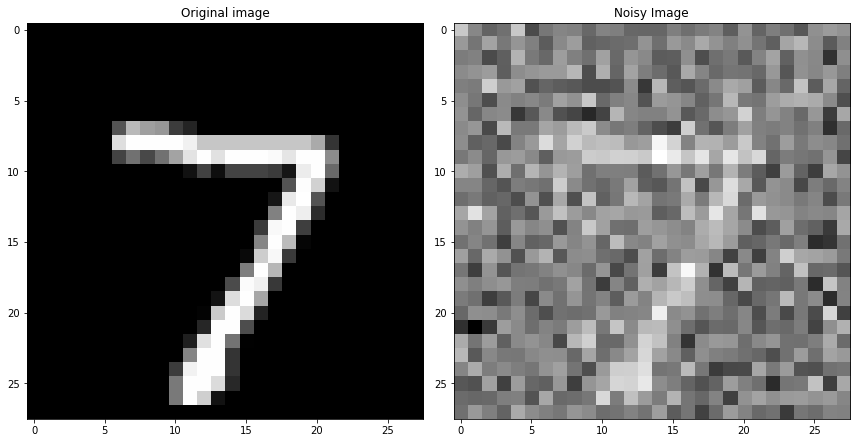

In [6]:
def add_noise(img, amount_noise):
    noise = torch.randn(img.size()) * amount_noise
    noisy_img = img + noise
    return noisy_img


img = test_dataset[0][0].unsqueeze(0)
#Apply noise 
noisy_img = add_noise(img, 0.4)

fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0].set_title('Original image')
axs[1].imshow(noisy_img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[1].set_title('Noisy Image')
plt.tight_layout()
plt.pause(0.1)

# Autoencoder

In [7]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,dropout=0.5, conv1=8,conv2=16,conv3=32,fc=64):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, conv1, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Second convolutional layer
            nn.Conv2d(conv1, conv2, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Third convolutional layer
            nn.Conv2d(conv2, conv3, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)#dimension 0 is the sample, so we flatten from dimension 1

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * conv3, fc),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            # Second linear layer
            nn.Linear(fc, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

## Decoder

In [8]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,dropout=0.5, conv1=8,conv2=16,conv3=32,fc=64):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, fc),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            # Second linear layer
            nn.Linear(fc, 3 * 3 * conv3),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(conv3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(conv3, conv2, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Second transposed convolution
            nn.ConvTranspose2d(conv2, conv1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Third transposed convolution
            nn.ConvTranspose2d(conv1, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

Initialize the two networks.

In [9]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

Let's check if all the shapes are correct.

In [10]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 2])
Decoded image shape: torch.Size([1, 1, 28, 28])


# Training

In [11]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

### Set the random seed for reproducible results
torch.manual_seed(0)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Dropout2d(p=0.5, inplace=False)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Training function

In [12]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_amount):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        
        #Apply noise 
        image_batch = add_noise(image_batch, noise_amount)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))

    return loss.data

## Testing function

In [13]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_amount):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
          #Apply noise 
            image_batch = add_noise(image_batch, noise_amount)
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## Training loop

In [14]:
### Training cycle
def training_cycle(num_epochs,early_stopping,encoder,decoder,loss_fn,optim,train_dataloader,device,test_dataset, noise_amount):
    train_loss_log = []
    val_loss_log = []
    
    #early stopping
    max_early=float("-inf")
    idx_early=-1
    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))
        ### Training (use the training function)
        train_loss=train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim, noise_amount = noise_amount)
      
        train_loss_log.append(train_loss)
        ### Validation  (use the testing function)
        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn, noise_amount = noise_amount)
        
        val_loss_log.append(val_loss)
        # Print Validationloss
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0].unsqueeze(0)
        #Apply noise 
        img = add_noise(img, noise_amount)
        img = img.to(device)

        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)
        # Save figures
        os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
        fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
        plt.show()
        plt.close()

        # Save network parameters
        torch.save(encoder.state_dict(), 'encoder_params.pth')
        torch.save(decoder.state_dict(), 'decoder_params.pth')
        torch.save(optim.state_dict(), 'optim_params.pth')
        
        #Early stopping:
        if idx_early==-1:
            idx_early=epoch
            max_early=val_loss
        elif round(float(val_loss),3)<round(float(max_early),3):
            idx_early=epoch
            max_early=val_loss
            
        elif epoch-idx_early>=early_stopping:
            print("STOPPED BY EARLY STOPPYNG")
            break

    return (train_loss_log,val_loss_log)


In [16]:
#just for simplicity we will chose the best hyper found for the ae
space_dim = [2]
num_epochs=100
early_stopping=60
Conv1=[8]
Conv2=[16]
Conv3=[64]
FC=[64]
LR=[0.001]
L2=[1e-5]
drop=[0.1]

In [17]:
hyperparams = [space_dim,Conv1,Conv2,Conv3,FC,LR,L2, drop]  

iterations=[]
import itertools
for hyper in itertools.product(*hyperparams):
    iterations.append(hyper)
print("Total Combinations:",len(iterations))


Total Combinations: 1




Iteration: 0 (2, 8, 16, 64, 64, 0.001, 1e-05, 0.1)
EPOCH 1/100
	 partial train loss (single batch): 0.385016
	 partial train loss (single batch): 0.385737
	 partial train loss (single batch): 0.382974
	 partial train loss (single batch): 0.382327
	 partial train loss (single batch): 0.381673
	 partial train loss (single batch): 0.380898
	 partial train loss (single batch): 0.382335
	 partial train loss (single batch): 0.380438
	 partial train loss (single batch): 0.380553
	 partial train loss (single batch): 0.379413
	 partial train loss (single batch): 0.376952
	 partial train loss (single batch): 0.375939
	 partial train loss (single batch): 0.375854
	 partial train loss (single batch): 0.374586
	 partial train loss (single batch): 0.369772
	 partial train loss (single batch): 0.368894
	 partial train loss (single batch): 0.363518
	 partial train loss (single batch): 0.360407
	 partial train loss (single batch): 0.353628
	 partial train loss (single batch): 0.344725
	 partial train

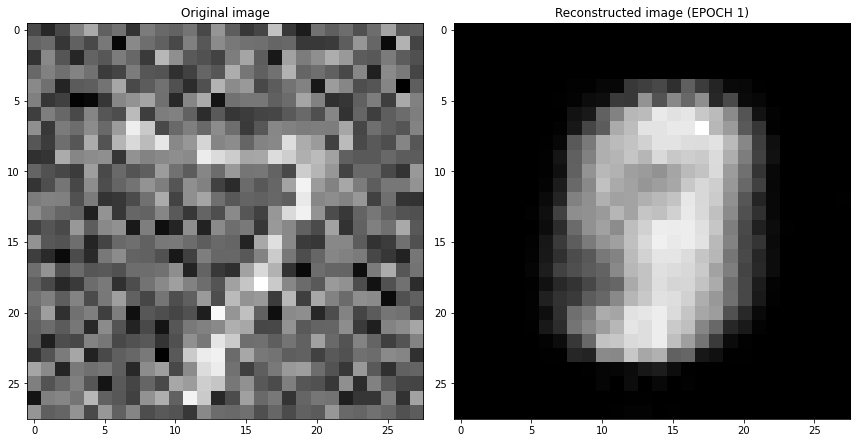

EPOCH 2/100
	 partial train loss (single batch): 0.225087
	 partial train loss (single batch): 0.225670
	 partial train loss (single batch): 0.224734
	 partial train loss (single batch): 0.226093
	 partial train loss (single batch): 0.226946
	 partial train loss (single batch): 0.224183
	 partial train loss (single batch): 0.224341
	 partial train loss (single batch): 0.227410
	 partial train loss (single batch): 0.226495
	 partial train loss (single batch): 0.228270
	 partial train loss (single batch): 0.226739
	 partial train loss (single batch): 0.227791
	 partial train loss (single batch): 0.226179
	 partial train loss (single batch): 0.225821
	 partial train loss (single batch): 0.226458
	 partial train loss (single batch): 0.226989
	 partial train loss (single batch): 0.225298
	 partial train loss (single batch): 0.225709
	 partial train loss (single batch): 0.224063
	 partial train loss (single batch): 0.225309
	 partial train loss (single batch): 0.225964
	 partial train loss (

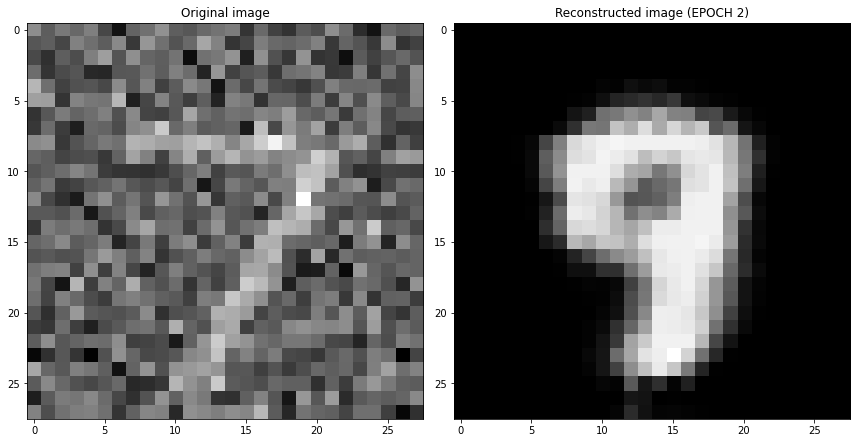

EPOCH 3/100
	 partial train loss (single batch): 0.218971
	 partial train loss (single batch): 0.217853
	 partial train loss (single batch): 0.220559
	 partial train loss (single batch): 0.217425
	 partial train loss (single batch): 0.217734
	 partial train loss (single batch): 0.218036
	 partial train loss (single batch): 0.217791
	 partial train loss (single batch): 0.217961
	 partial train loss (single batch): 0.217369
	 partial train loss (single batch): 0.217337
	 partial train loss (single batch): 0.220474
	 partial train loss (single batch): 0.218214
	 partial train loss (single batch): 0.218639
	 partial train loss (single batch): 0.216576
	 partial train loss (single batch): 0.217162
	 partial train loss (single batch): 0.217441
	 partial train loss (single batch): 0.215838
	 partial train loss (single batch): 0.217379
	 partial train loss (single batch): 0.219170
	 partial train loss (single batch): 0.218049
	 partial train loss (single batch): 0.219785
	 partial train loss (

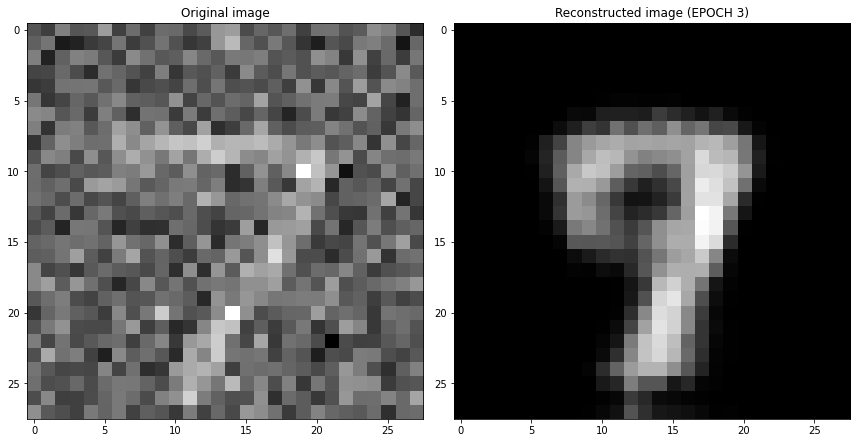

EPOCH 4/100
	 partial train loss (single batch): 0.212307
	 partial train loss (single batch): 0.214833
	 partial train loss (single batch): 0.211171
	 partial train loss (single batch): 0.214741
	 partial train loss (single batch): 0.213107
	 partial train loss (single batch): 0.212454
	 partial train loss (single batch): 0.213102
	 partial train loss (single batch): 0.212207
	 partial train loss (single batch): 0.214487
	 partial train loss (single batch): 0.214370
	 partial train loss (single batch): 0.214248
	 partial train loss (single batch): 0.214703
	 partial train loss (single batch): 0.214604
	 partial train loss (single batch): 0.214502
	 partial train loss (single batch): 0.212802
	 partial train loss (single batch): 0.213156
	 partial train loss (single batch): 0.213430
	 partial train loss (single batch): 0.210678
	 partial train loss (single batch): 0.213683
	 partial train loss (single batch): 0.213897
	 partial train loss (single batch): 0.211346
	 partial train loss (

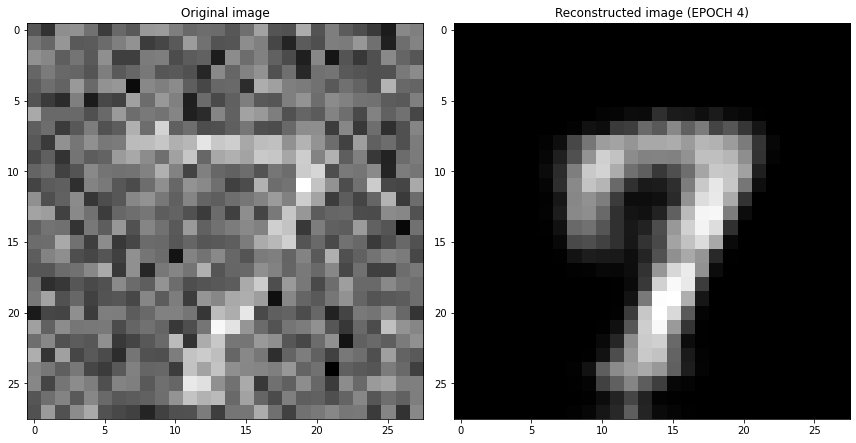

EPOCH 5/100
	 partial train loss (single batch): 0.209333
	 partial train loss (single batch): 0.211291
	 partial train loss (single batch): 0.210303
	 partial train loss (single batch): 0.209457
	 partial train loss (single batch): 0.208823
	 partial train loss (single batch): 0.210916
	 partial train loss (single batch): 0.209823
	 partial train loss (single batch): 0.212004
	 partial train loss (single batch): 0.209044
	 partial train loss (single batch): 0.211891
	 partial train loss (single batch): 0.213122
	 partial train loss (single batch): 0.209264
	 partial train loss (single batch): 0.210013
	 partial train loss (single batch): 0.211601
	 partial train loss (single batch): 0.210586
	 partial train loss (single batch): 0.212530
	 partial train loss (single batch): 0.210236
	 partial train loss (single batch): 0.211466
	 partial train loss (single batch): 0.210576
	 partial train loss (single batch): 0.210685
	 partial train loss (single batch): 0.210981
	 partial train loss (

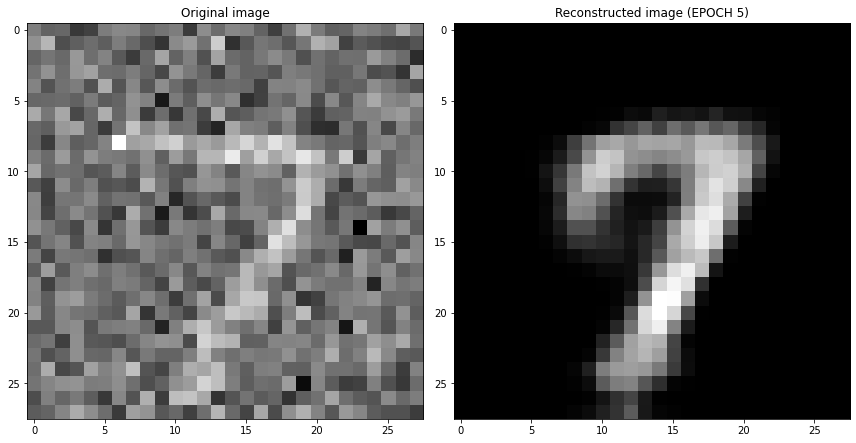

EPOCH 6/100
	 partial train loss (single batch): 0.210631
	 partial train loss (single batch): 0.207893
	 partial train loss (single batch): 0.210473
	 partial train loss (single batch): 0.210452
	 partial train loss (single batch): 0.208061
	 partial train loss (single batch): 0.210683
	 partial train loss (single batch): 0.209787
	 partial train loss (single batch): 0.210259
	 partial train loss (single batch): 0.210840
	 partial train loss (single batch): 0.209628
	 partial train loss (single batch): 0.210020
	 partial train loss (single batch): 0.208433
	 partial train loss (single batch): 0.209193
	 partial train loss (single batch): 0.209047
	 partial train loss (single batch): 0.210292
	 partial train loss (single batch): 0.208334
	 partial train loss (single batch): 0.209015
	 partial train loss (single batch): 0.209808
	 partial train loss (single batch): 0.207049
	 partial train loss (single batch): 0.209641
	 partial train loss (single batch): 0.209369
	 partial train loss (

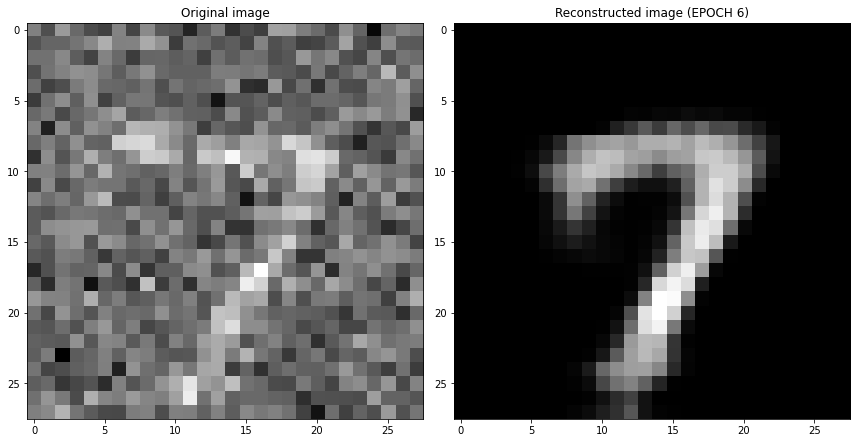

EPOCH 7/100
	 partial train loss (single batch): 0.206138
	 partial train loss (single batch): 0.207400
	 partial train loss (single batch): 0.209216
	 partial train loss (single batch): 0.208853
	 partial train loss (single batch): 0.207542
	 partial train loss (single batch): 0.209161
	 partial train loss (single batch): 0.209257
	 partial train loss (single batch): 0.206679
	 partial train loss (single batch): 0.207495
	 partial train loss (single batch): 0.208939
	 partial train loss (single batch): 0.205813
	 partial train loss (single batch): 0.211038
	 partial train loss (single batch): 0.207118
	 partial train loss (single batch): 0.209434
	 partial train loss (single batch): 0.209010
	 partial train loss (single batch): 0.208635
	 partial train loss (single batch): 0.206335
	 partial train loss (single batch): 0.209302
	 partial train loss (single batch): 0.209486
	 partial train loss (single batch): 0.206822
	 partial train loss (single batch): 0.208811
	 partial train loss (

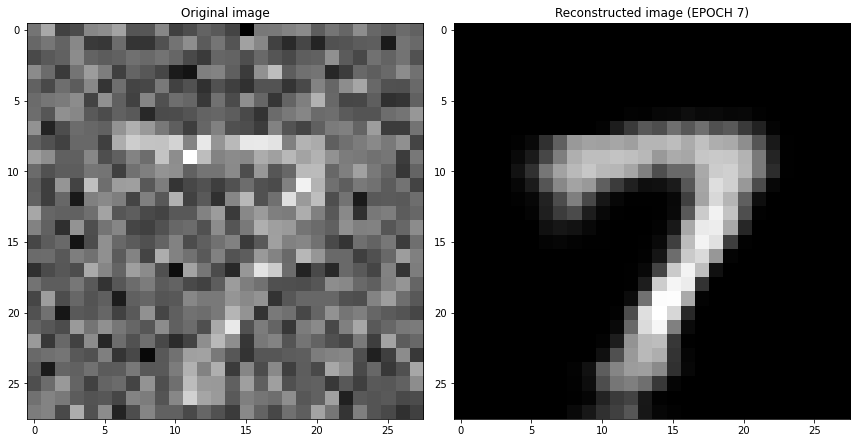

EPOCH 8/100
	 partial train loss (single batch): 0.208712
	 partial train loss (single batch): 0.206237
	 partial train loss (single batch): 0.207627
	 partial train loss (single batch): 0.208255
	 partial train loss (single batch): 0.207485
	 partial train loss (single batch): 0.207696
	 partial train loss (single batch): 0.205889
	 partial train loss (single batch): 0.207105
	 partial train loss (single batch): 0.205933
	 partial train loss (single batch): 0.206636
	 partial train loss (single batch): 0.208148
	 partial train loss (single batch): 0.210991
	 partial train loss (single batch): 0.206762
	 partial train loss (single batch): 0.202962
	 partial train loss (single batch): 0.205038
	 partial train loss (single batch): 0.207421
	 partial train loss (single batch): 0.206291
	 partial train loss (single batch): 0.209670
	 partial train loss (single batch): 0.209142
	 partial train loss (single batch): 0.206583
	 partial train loss (single batch): 0.210320
	 partial train loss (

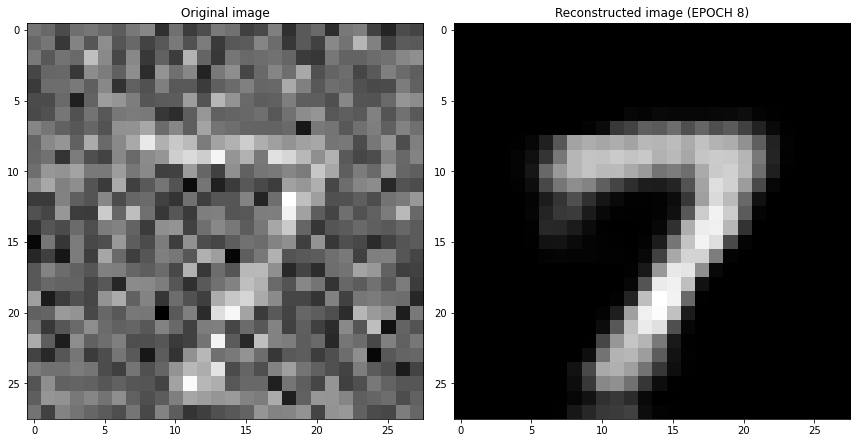

EPOCH 9/100
	 partial train loss (single batch): 0.204917
	 partial train loss (single batch): 0.207753
	 partial train loss (single batch): 0.205736
	 partial train loss (single batch): 0.207196
	 partial train loss (single batch): 0.206783
	 partial train loss (single batch): 0.205490
	 partial train loss (single batch): 0.204657
	 partial train loss (single batch): 0.205738
	 partial train loss (single batch): 0.205531
	 partial train loss (single batch): 0.207928
	 partial train loss (single batch): 0.205954
	 partial train loss (single batch): 0.208321
	 partial train loss (single batch): 0.207389
	 partial train loss (single batch): 0.208254
	 partial train loss (single batch): 0.208823
	 partial train loss (single batch): 0.207585
	 partial train loss (single batch): 0.207299
	 partial train loss (single batch): 0.208252
	 partial train loss (single batch): 0.206204
	 partial train loss (single batch): 0.207645
	 partial train loss (single batch): 0.207740
	 partial train loss (

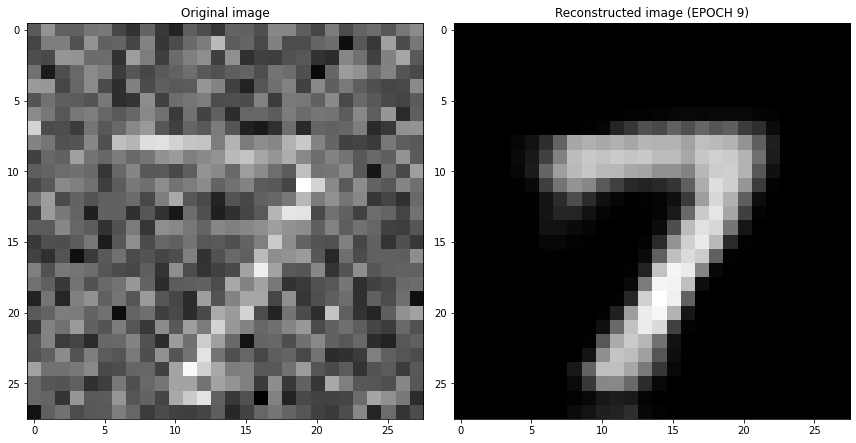

EPOCH 10/100
	 partial train loss (single batch): 0.207268
	 partial train loss (single batch): 0.206096
	 partial train loss (single batch): 0.203369
	 partial train loss (single batch): 0.206625
	 partial train loss (single batch): 0.206835
	 partial train loss (single batch): 0.208701
	 partial train loss (single batch): 0.204353
	 partial train loss (single batch): 0.205687
	 partial train loss (single batch): 0.204820
	 partial train loss (single batch): 0.204236
	 partial train loss (single batch): 0.204075
	 partial train loss (single batch): 0.207231
	 partial train loss (single batch): 0.206257
	 partial train loss (single batch): 0.206749
	 partial train loss (single batch): 0.205402
	 partial train loss (single batch): 0.206214
	 partial train loss (single batch): 0.205983
	 partial train loss (single batch): 0.205290
	 partial train loss (single batch): 0.206604
	 partial train loss (single batch): 0.206587
	 partial train loss (single batch): 0.206342
	 partial train loss 

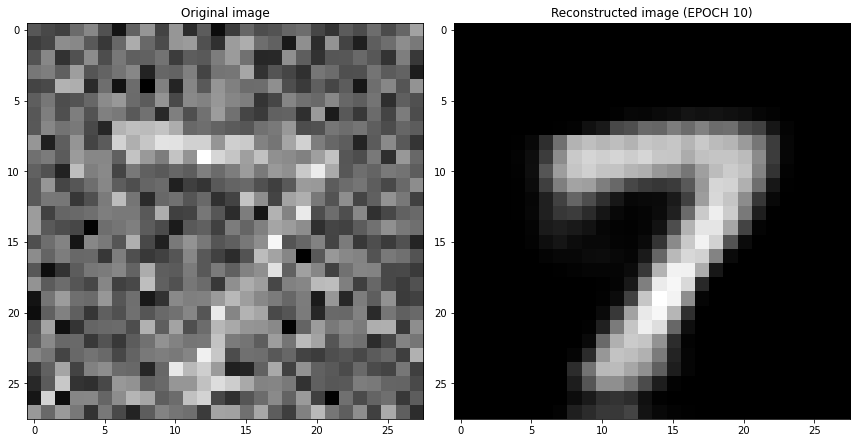

EPOCH 11/100
	 partial train loss (single batch): 0.205013
	 partial train loss (single batch): 0.204899
	 partial train loss (single batch): 0.208878
	 partial train loss (single batch): 0.206094
	 partial train loss (single batch): 0.206077
	 partial train loss (single batch): 0.207214
	 partial train loss (single batch): 0.203445
	 partial train loss (single batch): 0.204788
	 partial train loss (single batch): 0.203360
	 partial train loss (single batch): 0.204528
	 partial train loss (single batch): 0.205237
	 partial train loss (single batch): 0.207736
	 partial train loss (single batch): 0.204190
	 partial train loss (single batch): 0.206661
	 partial train loss (single batch): 0.208033
	 partial train loss (single batch): 0.205545
	 partial train loss (single batch): 0.205280
	 partial train loss (single batch): 0.202756
	 partial train loss (single batch): 0.203461
	 partial train loss (single batch): 0.205770
	 partial train loss (single batch): 0.208716
	 partial train loss 

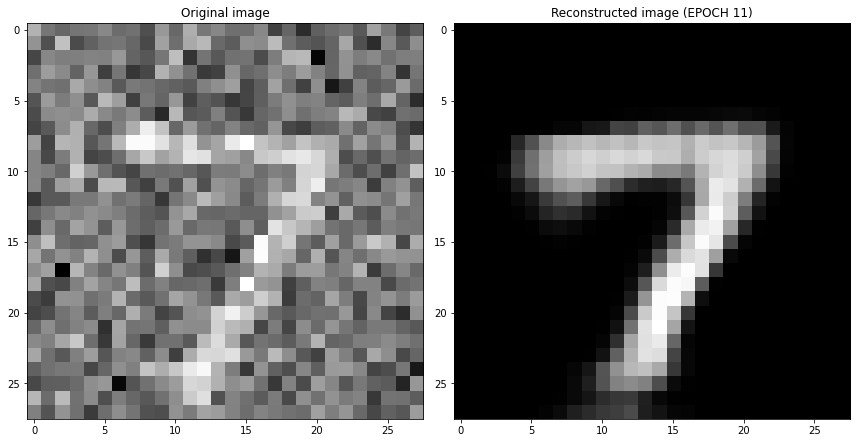

EPOCH 12/100
	 partial train loss (single batch): 0.204403
	 partial train loss (single batch): 0.206377
	 partial train loss (single batch): 0.206943
	 partial train loss (single batch): 0.204252
	 partial train loss (single batch): 0.205025
	 partial train loss (single batch): 0.203812
	 partial train loss (single batch): 0.206981
	 partial train loss (single batch): 0.205152
	 partial train loss (single batch): 0.207467
	 partial train loss (single batch): 0.203661
	 partial train loss (single batch): 0.204847
	 partial train loss (single batch): 0.206173
	 partial train loss (single batch): 0.205132
	 partial train loss (single batch): 0.206118
	 partial train loss (single batch): 0.208388
	 partial train loss (single batch): 0.206674
	 partial train loss (single batch): 0.210728
	 partial train loss (single batch): 0.204574
	 partial train loss (single batch): 0.205196
	 partial train loss (single batch): 0.204042
	 partial train loss (single batch): 0.202628
	 partial train loss 

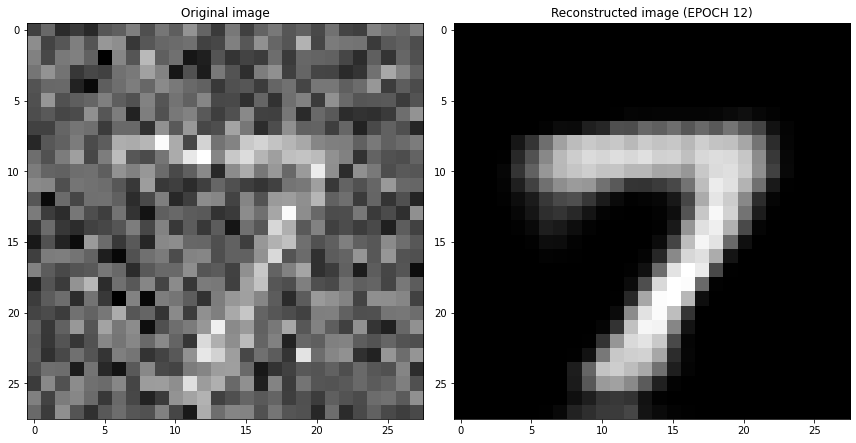

EPOCH 13/100
	 partial train loss (single batch): 0.205213
	 partial train loss (single batch): 0.206036
	 partial train loss (single batch): 0.204052
	 partial train loss (single batch): 0.204771
	 partial train loss (single batch): 0.206138
	 partial train loss (single batch): 0.207284
	 partial train loss (single batch): 0.205847
	 partial train loss (single batch): 0.205514
	 partial train loss (single batch): 0.206792
	 partial train loss (single batch): 0.205323
	 partial train loss (single batch): 0.204712
	 partial train loss (single batch): 0.205700
	 partial train loss (single batch): 0.205913
	 partial train loss (single batch): 0.207857
	 partial train loss (single batch): 0.204880
	 partial train loss (single batch): 0.205959
	 partial train loss (single batch): 0.205959
	 partial train loss (single batch): 0.204478
	 partial train loss (single batch): 0.206799
	 partial train loss (single batch): 0.205302
	 partial train loss (single batch): 0.205721
	 partial train loss 

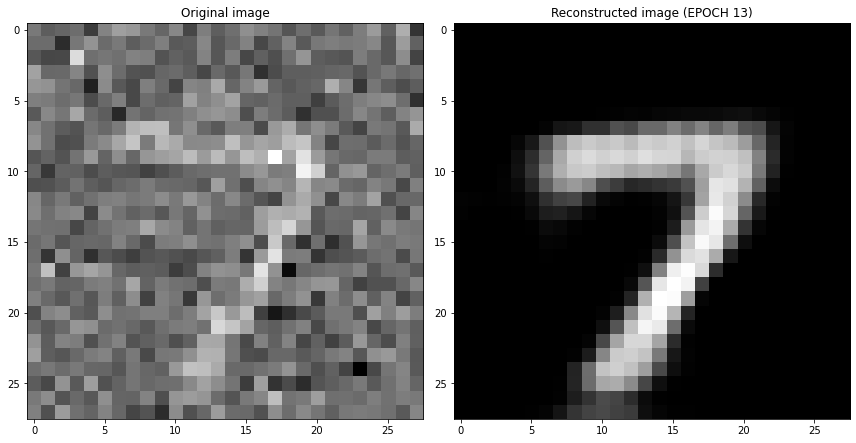

EPOCH 14/100
	 partial train loss (single batch): 0.203777
	 partial train loss (single batch): 0.205370
	 partial train loss (single batch): 0.204750
	 partial train loss (single batch): 0.204194
	 partial train loss (single batch): 0.203938
	 partial train loss (single batch): 0.202785
	 partial train loss (single batch): 0.206371
	 partial train loss (single batch): 0.203626
	 partial train loss (single batch): 0.204505
	 partial train loss (single batch): 0.206166
	 partial train loss (single batch): 0.206584
	 partial train loss (single batch): 0.202784
	 partial train loss (single batch): 0.205488
	 partial train loss (single batch): 0.203706
	 partial train loss (single batch): 0.203255
	 partial train loss (single batch): 0.204690
	 partial train loss (single batch): 0.205301
	 partial train loss (single batch): 0.206916
	 partial train loss (single batch): 0.203879
	 partial train loss (single batch): 0.206473
	 partial train loss (single batch): 0.203624
	 partial train loss 

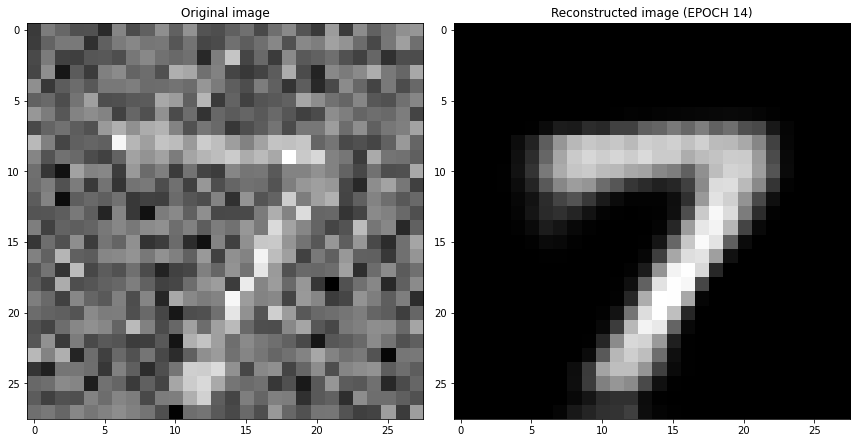

EPOCH 15/100
	 partial train loss (single batch): 0.204859
	 partial train loss (single batch): 0.205215
	 partial train loss (single batch): 0.204719
	 partial train loss (single batch): 0.204904
	 partial train loss (single batch): 0.205293
	 partial train loss (single batch): 0.204936
	 partial train loss (single batch): 0.205313
	 partial train loss (single batch): 0.204277
	 partial train loss (single batch): 0.207572
	 partial train loss (single batch): 0.202919
	 partial train loss (single batch): 0.203991
	 partial train loss (single batch): 0.205857
	 partial train loss (single batch): 0.203313
	 partial train loss (single batch): 0.205945
	 partial train loss (single batch): 0.203334
	 partial train loss (single batch): 0.203983
	 partial train loss (single batch): 0.205530
	 partial train loss (single batch): 0.204806
	 partial train loss (single batch): 0.202313
	 partial train loss (single batch): 0.204577
	 partial train loss (single batch): 0.204690
	 partial train loss 

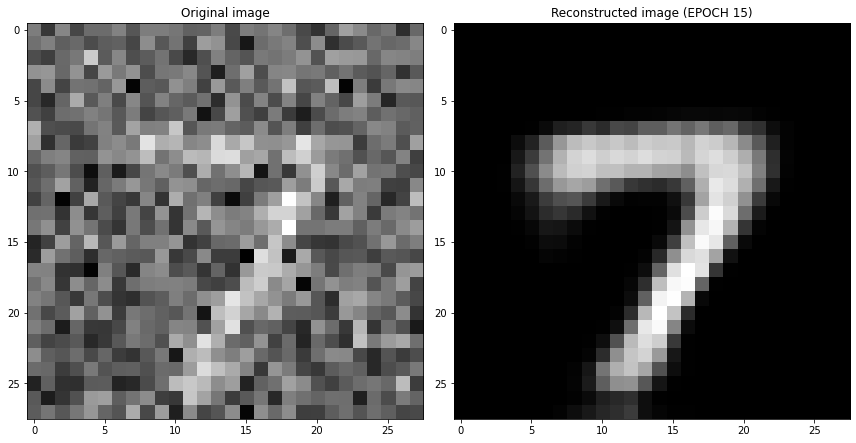

EPOCH 16/100
	 partial train loss (single batch): 0.206409
	 partial train loss (single batch): 0.206061
	 partial train loss (single batch): 0.202573
	 partial train loss (single batch): 0.207511
	 partial train loss (single batch): 0.204546
	 partial train loss (single batch): 0.206495
	 partial train loss (single batch): 0.202741
	 partial train loss (single batch): 0.205398
	 partial train loss (single batch): 0.204501
	 partial train loss (single batch): 0.203184
	 partial train loss (single batch): 0.203931
	 partial train loss (single batch): 0.203711
	 partial train loss (single batch): 0.203231
	 partial train loss (single batch): 0.203067
	 partial train loss (single batch): 0.206006
	 partial train loss (single batch): 0.203466
	 partial train loss (single batch): 0.205319
	 partial train loss (single batch): 0.203336
	 partial train loss (single batch): 0.203357
	 partial train loss (single batch): 0.204669
	 partial train loss (single batch): 0.203297
	 partial train loss 

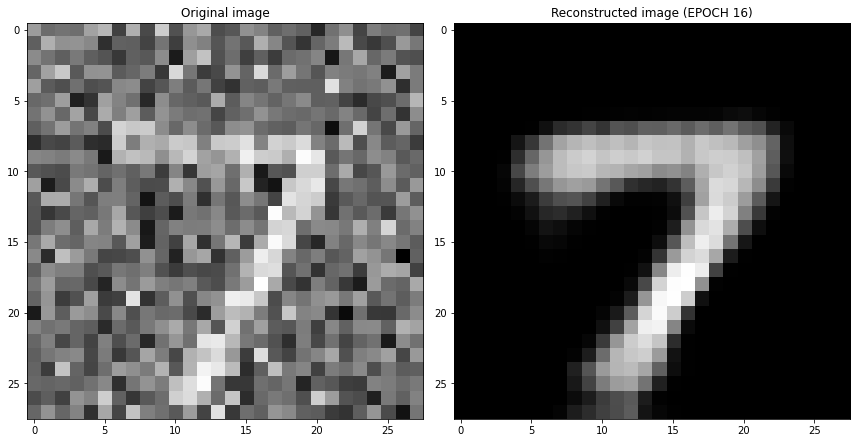

EPOCH 17/100
	 partial train loss (single batch): 0.203877
	 partial train loss (single batch): 0.205765
	 partial train loss (single batch): 0.205141
	 partial train loss (single batch): 0.204639
	 partial train loss (single batch): 0.206883
	 partial train loss (single batch): 0.204940
	 partial train loss (single batch): 0.203371
	 partial train loss (single batch): 0.204609
	 partial train loss (single batch): 0.202723
	 partial train loss (single batch): 0.206322
	 partial train loss (single batch): 0.202076
	 partial train loss (single batch): 0.204854
	 partial train loss (single batch): 0.204679
	 partial train loss (single batch): 0.203092
	 partial train loss (single batch): 0.202459
	 partial train loss (single batch): 0.203316
	 partial train loss (single batch): 0.203582
	 partial train loss (single batch): 0.204567
	 partial train loss (single batch): 0.205293
	 partial train loss (single batch): 0.204606
	 partial train loss (single batch): 0.204534
	 partial train loss 

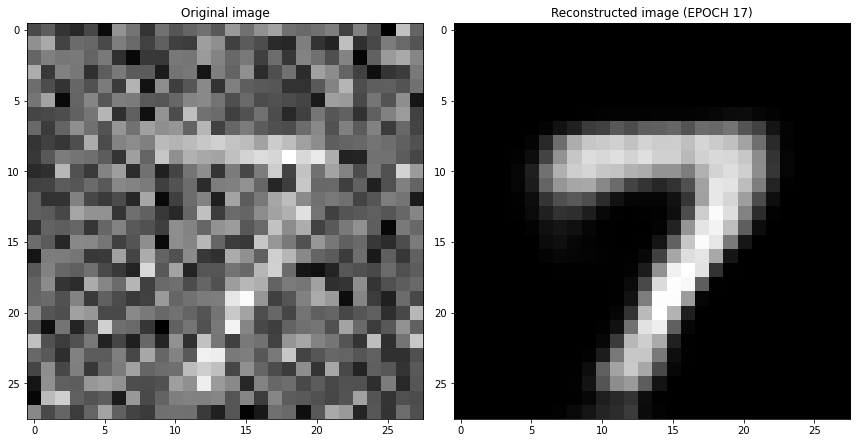

EPOCH 18/100
	 partial train loss (single batch): 0.203741
	 partial train loss (single batch): 0.203107
	 partial train loss (single batch): 0.203178
	 partial train loss (single batch): 0.204660
	 partial train loss (single batch): 0.205584
	 partial train loss (single batch): 0.203416
	 partial train loss (single batch): 0.207099
	 partial train loss (single batch): 0.205775
	 partial train loss (single batch): 0.204529
	 partial train loss (single batch): 0.202124
	 partial train loss (single batch): 0.204408
	 partial train loss (single batch): 0.201823
	 partial train loss (single batch): 0.203114
	 partial train loss (single batch): 0.203649
	 partial train loss (single batch): 0.206011
	 partial train loss (single batch): 0.205058
	 partial train loss (single batch): 0.205023
	 partial train loss (single batch): 0.203983
	 partial train loss (single batch): 0.205789
	 partial train loss (single batch): 0.204346
	 partial train loss (single batch): 0.202980
	 partial train loss 

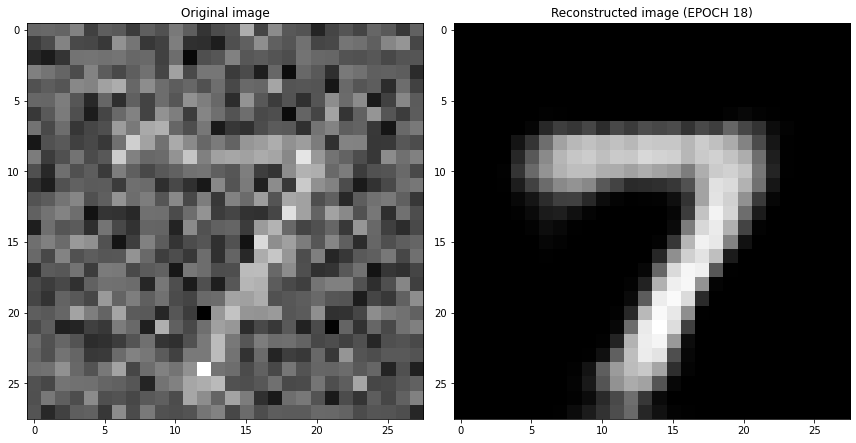

EPOCH 19/100
	 partial train loss (single batch): 0.207198
	 partial train loss (single batch): 0.203386
	 partial train loss (single batch): 0.204773
	 partial train loss (single batch): 0.205036
	 partial train loss (single batch): 0.202711
	 partial train loss (single batch): 0.204422
	 partial train loss (single batch): 0.202965
	 partial train loss (single batch): 0.206293
	 partial train loss (single batch): 0.204398
	 partial train loss (single batch): 0.203234
	 partial train loss (single batch): 0.205695
	 partial train loss (single batch): 0.204507
	 partial train loss (single batch): 0.205873
	 partial train loss (single batch): 0.201579
	 partial train loss (single batch): 0.204305
	 partial train loss (single batch): 0.202533
	 partial train loss (single batch): 0.204786
	 partial train loss (single batch): 0.202398
	 partial train loss (single batch): 0.204053
	 partial train loss (single batch): 0.205468
	 partial train loss (single batch): 0.207774
	 partial train loss 

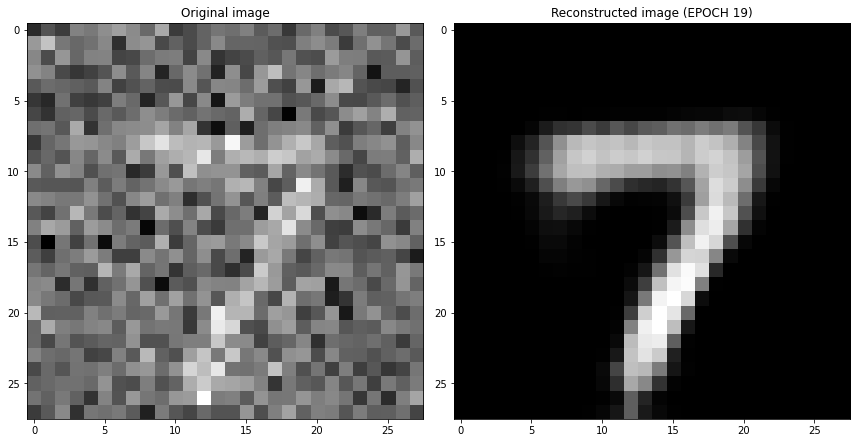

EPOCH 20/100
	 partial train loss (single batch): 0.201929
	 partial train loss (single batch): 0.203449
	 partial train loss (single batch): 0.203158
	 partial train loss (single batch): 0.205074
	 partial train loss (single batch): 0.206392
	 partial train loss (single batch): 0.203916
	 partial train loss (single batch): 0.203648
	 partial train loss (single batch): 0.203554
	 partial train loss (single batch): 0.204383
	 partial train loss (single batch): 0.205149
	 partial train loss (single batch): 0.206343
	 partial train loss (single batch): 0.203812
	 partial train loss (single batch): 0.207121
	 partial train loss (single batch): 0.204242
	 partial train loss (single batch): 0.203471
	 partial train loss (single batch): 0.205098
	 partial train loss (single batch): 0.203709
	 partial train loss (single batch): 0.205130
	 partial train loss (single batch): 0.203680
	 partial train loss (single batch): 0.203606
	 partial train loss (single batch): 0.204042
	 partial train loss 

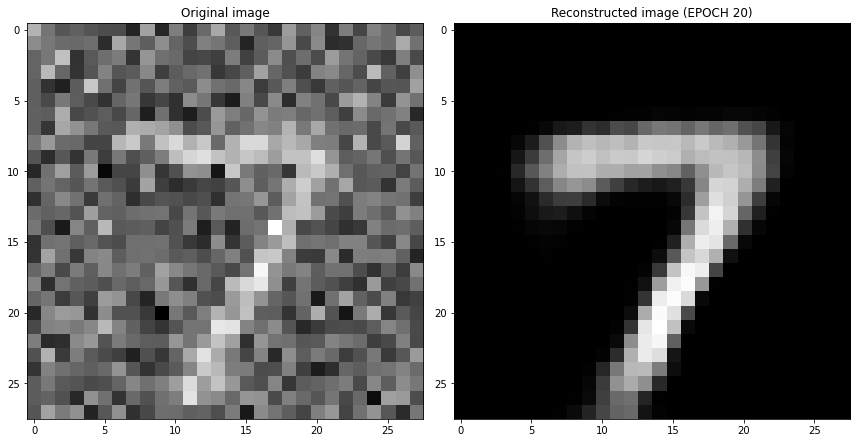

EPOCH 21/100
	 partial train loss (single batch): 0.203959
	 partial train loss (single batch): 0.200781
	 partial train loss (single batch): 0.201453
	 partial train loss (single batch): 0.204084
	 partial train loss (single batch): 0.201558
	 partial train loss (single batch): 0.203009
	 partial train loss (single batch): 0.203796
	 partial train loss (single batch): 0.203129
	 partial train loss (single batch): 0.203649
	 partial train loss (single batch): 0.204886
	 partial train loss (single batch): 0.203636
	 partial train loss (single batch): 0.203543
	 partial train loss (single batch): 0.205298
	 partial train loss (single batch): 0.205037
	 partial train loss (single batch): 0.201596
	 partial train loss (single batch): 0.201128
	 partial train loss (single batch): 0.205262
	 partial train loss (single batch): 0.204443
	 partial train loss (single batch): 0.205239
	 partial train loss (single batch): 0.203988
	 partial train loss (single batch): 0.204581
	 partial train loss 

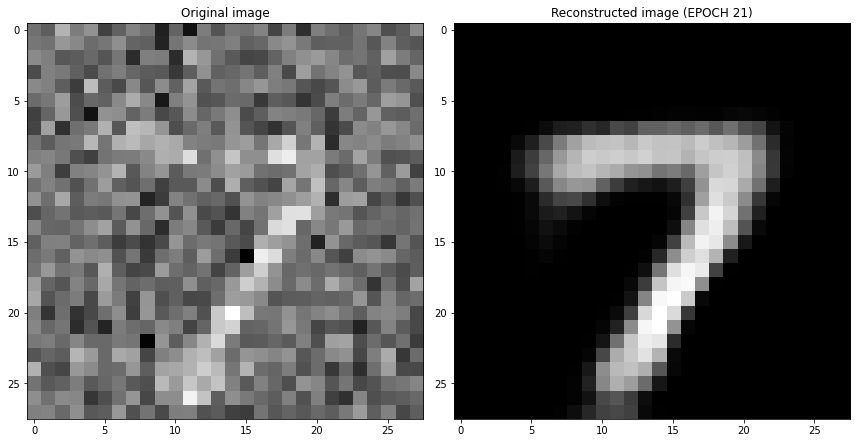

EPOCH 22/100
	 partial train loss (single batch): 0.203062
	 partial train loss (single batch): 0.204322
	 partial train loss (single batch): 0.204255
	 partial train loss (single batch): 0.201999
	 partial train loss (single batch): 0.203348
	 partial train loss (single batch): 0.206429
	 partial train loss (single batch): 0.203321
	 partial train loss (single batch): 0.205661
	 partial train loss (single batch): 0.203673
	 partial train loss (single batch): 0.204631
	 partial train loss (single batch): 0.203002
	 partial train loss (single batch): 0.205256
	 partial train loss (single batch): 0.203508
	 partial train loss (single batch): 0.204125
	 partial train loss (single batch): 0.204619
	 partial train loss (single batch): 0.202399
	 partial train loss (single batch): 0.201778
	 partial train loss (single batch): 0.205345
	 partial train loss (single batch): 0.204126
	 partial train loss (single batch): 0.203683
	 partial train loss (single batch): 0.204563
	 partial train loss 

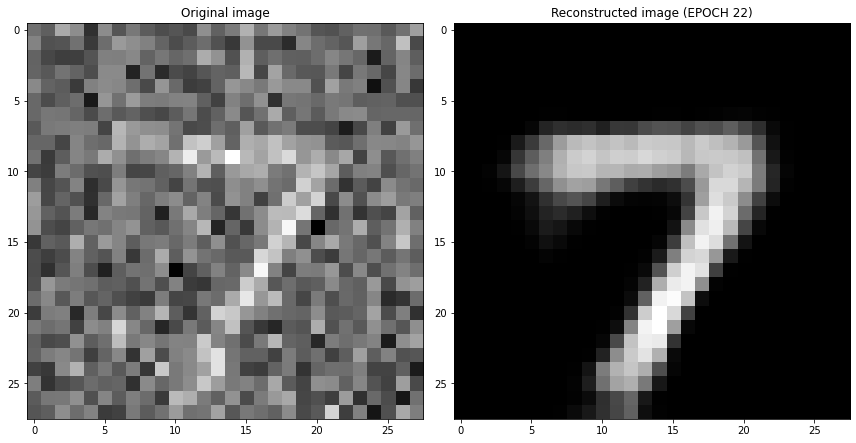

EPOCH 23/100
	 partial train loss (single batch): 0.205179
	 partial train loss (single batch): 0.202934
	 partial train loss (single batch): 0.202839
	 partial train loss (single batch): 0.204315
	 partial train loss (single batch): 0.204905
	 partial train loss (single batch): 0.206533
	 partial train loss (single batch): 0.202781
	 partial train loss (single batch): 0.203766
	 partial train loss (single batch): 0.203260
	 partial train loss (single batch): 0.203380
	 partial train loss (single batch): 0.204347
	 partial train loss (single batch): 0.204067
	 partial train loss (single batch): 0.203055
	 partial train loss (single batch): 0.203441
	 partial train loss (single batch): 0.206521
	 partial train loss (single batch): 0.202806
	 partial train loss (single batch): 0.204193
	 partial train loss (single batch): 0.205774
	 partial train loss (single batch): 0.201925
	 partial train loss (single batch): 0.204441
	 partial train loss (single batch): 0.202048
	 partial train loss 

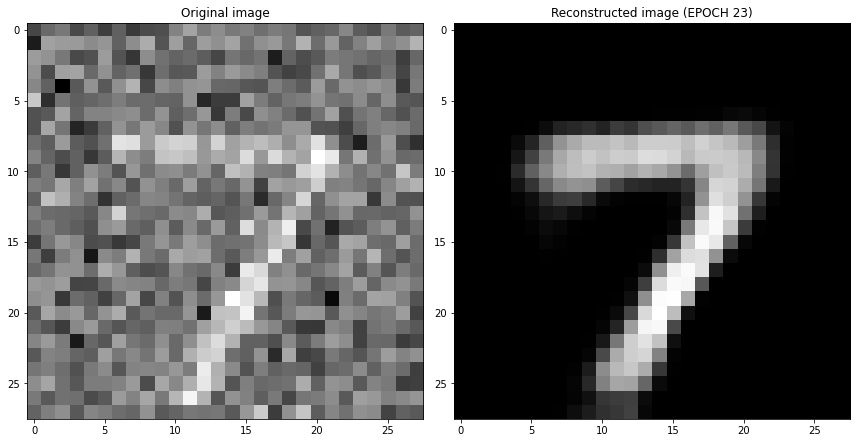

EPOCH 24/100
	 partial train loss (single batch): 0.201918
	 partial train loss (single batch): 0.201784
	 partial train loss (single batch): 0.202849
	 partial train loss (single batch): 0.204366
	 partial train loss (single batch): 0.204439
	 partial train loss (single batch): 0.204602
	 partial train loss (single batch): 0.203957
	 partial train loss (single batch): 0.203509
	 partial train loss (single batch): 0.205268
	 partial train loss (single batch): 0.202264
	 partial train loss (single batch): 0.205242
	 partial train loss (single batch): 0.204801
	 partial train loss (single batch): 0.204225
	 partial train loss (single batch): 0.203493
	 partial train loss (single batch): 0.204324
	 partial train loss (single batch): 0.204075
	 partial train loss (single batch): 0.201876
	 partial train loss (single batch): 0.205416
	 partial train loss (single batch): 0.205506
	 partial train loss (single batch): 0.202706
	 partial train loss (single batch): 0.207086
	 partial train loss 

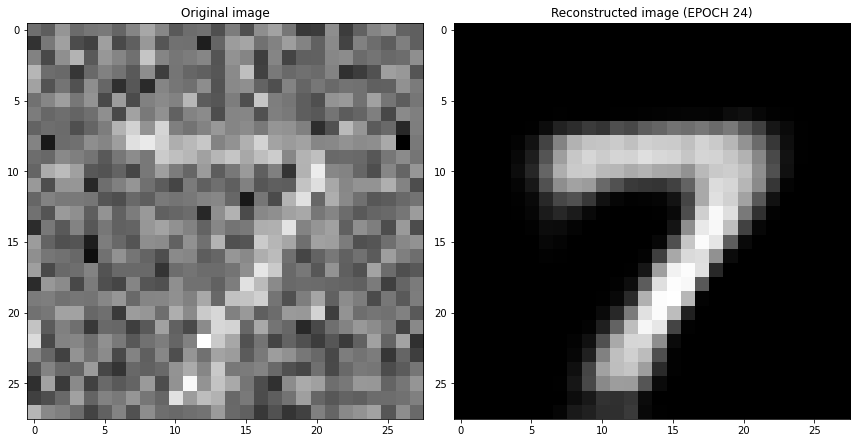

EPOCH 25/100
	 partial train loss (single batch): 0.202251
	 partial train loss (single batch): 0.202852
	 partial train loss (single batch): 0.203342
	 partial train loss (single batch): 0.203967
	 partial train loss (single batch): 0.199911
	 partial train loss (single batch): 0.204397
	 partial train loss (single batch): 0.204183
	 partial train loss (single batch): 0.200701
	 partial train loss (single batch): 0.203993
	 partial train loss (single batch): 0.203424
	 partial train loss (single batch): 0.203025
	 partial train loss (single batch): 0.203161
	 partial train loss (single batch): 0.204871
	 partial train loss (single batch): 0.204185
	 partial train loss (single batch): 0.202282
	 partial train loss (single batch): 0.205192
	 partial train loss (single batch): 0.204057
	 partial train loss (single batch): 0.203112
	 partial train loss (single batch): 0.203664
	 partial train loss (single batch): 0.204944
	 partial train loss (single batch): 0.203212
	 partial train loss 

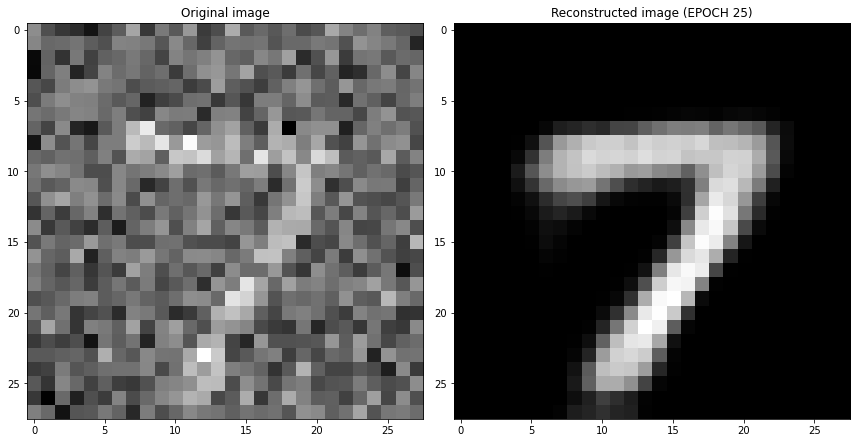

EPOCH 26/100
	 partial train loss (single batch): 0.204485
	 partial train loss (single batch): 0.200961
	 partial train loss (single batch): 0.204734
	 partial train loss (single batch): 0.204833
	 partial train loss (single batch): 0.205884
	 partial train loss (single batch): 0.201749
	 partial train loss (single batch): 0.204124
	 partial train loss (single batch): 0.203572
	 partial train loss (single batch): 0.204094
	 partial train loss (single batch): 0.203171
	 partial train loss (single batch): 0.203873
	 partial train loss (single batch): 0.204733
	 partial train loss (single batch): 0.201301
	 partial train loss (single batch): 0.204809
	 partial train loss (single batch): 0.204668
	 partial train loss (single batch): 0.206284
	 partial train loss (single batch): 0.205347
	 partial train loss (single batch): 0.202501
	 partial train loss (single batch): 0.204864
	 partial train loss (single batch): 0.202749
	 partial train loss (single batch): 0.203092
	 partial train loss 

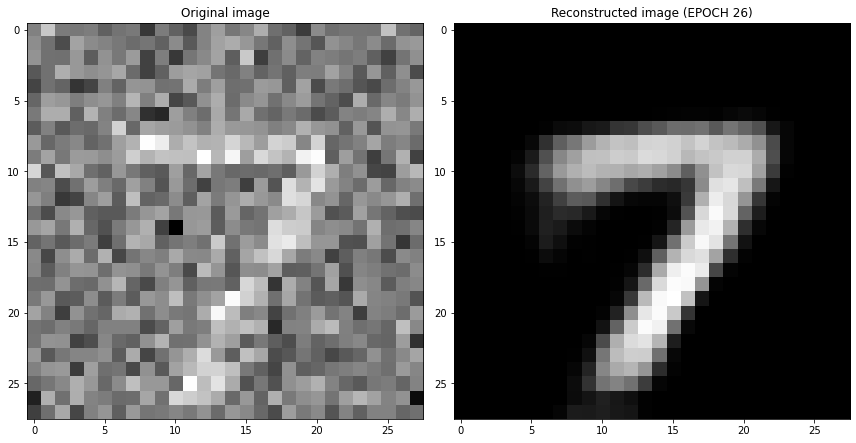

EPOCH 27/100
	 partial train loss (single batch): 0.205778
	 partial train loss (single batch): 0.204074
	 partial train loss (single batch): 0.201557
	 partial train loss (single batch): 0.201790
	 partial train loss (single batch): 0.204190
	 partial train loss (single batch): 0.203455
	 partial train loss (single batch): 0.203991
	 partial train loss (single batch): 0.204064
	 partial train loss (single batch): 0.202722
	 partial train loss (single batch): 0.204254
	 partial train loss (single batch): 0.203559
	 partial train loss (single batch): 0.202387
	 partial train loss (single batch): 0.204503
	 partial train loss (single batch): 0.203779
	 partial train loss (single batch): 0.203019
	 partial train loss (single batch): 0.202448
	 partial train loss (single batch): 0.200995
	 partial train loss (single batch): 0.203681
	 partial train loss (single batch): 0.204777
	 partial train loss (single batch): 0.202133
	 partial train loss (single batch): 0.204805
	 partial train loss 

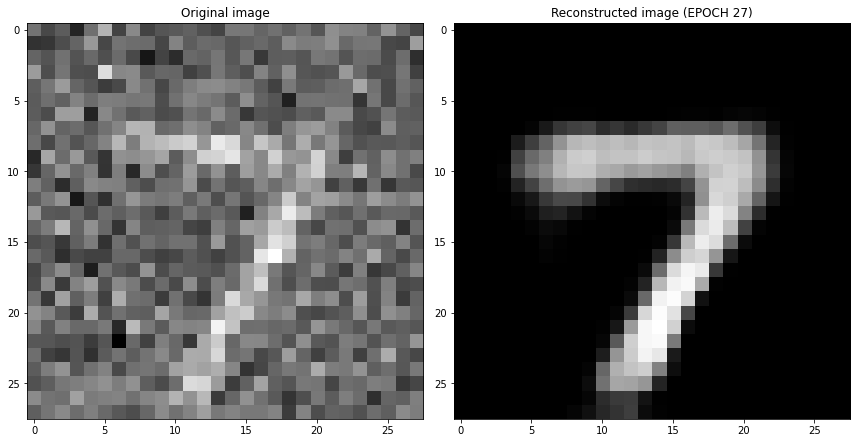

EPOCH 28/100
	 partial train loss (single batch): 0.201349
	 partial train loss (single batch): 0.202839
	 partial train loss (single batch): 0.202339
	 partial train loss (single batch): 0.202588
	 partial train loss (single batch): 0.204160
	 partial train loss (single batch): 0.202119
	 partial train loss (single batch): 0.204752
	 partial train loss (single batch): 0.203029
	 partial train loss (single batch): 0.200106
	 partial train loss (single batch): 0.205449
	 partial train loss (single batch): 0.202518
	 partial train loss (single batch): 0.203450
	 partial train loss (single batch): 0.203060
	 partial train loss (single batch): 0.201181
	 partial train loss (single batch): 0.205728
	 partial train loss (single batch): 0.200703
	 partial train loss (single batch): 0.202572
	 partial train loss (single batch): 0.202577
	 partial train loss (single batch): 0.203814
	 partial train loss (single batch): 0.203326
	 partial train loss (single batch): 0.202405
	 partial train loss 

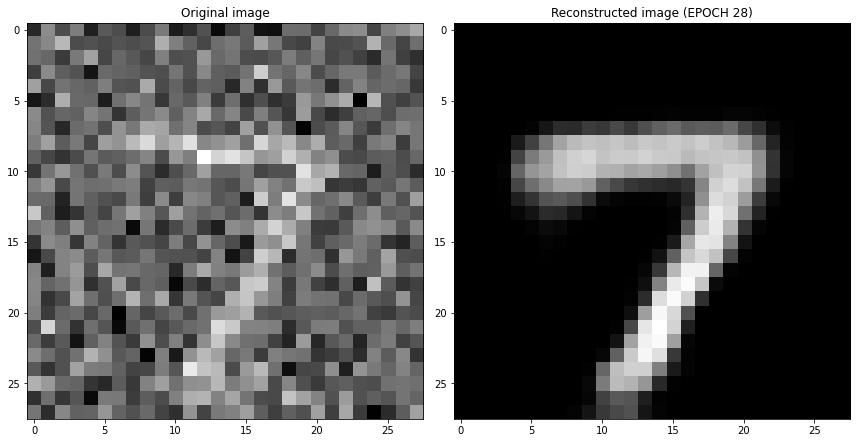

EPOCH 29/100
	 partial train loss (single batch): 0.206732
	 partial train loss (single batch): 0.204339
	 partial train loss (single batch): 0.203227
	 partial train loss (single batch): 0.202008
	 partial train loss (single batch): 0.204828
	 partial train loss (single batch): 0.206813
	 partial train loss (single batch): 0.205123
	 partial train loss (single batch): 0.204790
	 partial train loss (single batch): 0.203467
	 partial train loss (single batch): 0.206788
	 partial train loss (single batch): 0.203145
	 partial train loss (single batch): 0.203485
	 partial train loss (single batch): 0.202275
	 partial train loss (single batch): 0.202142
	 partial train loss (single batch): 0.203448
	 partial train loss (single batch): 0.200433
	 partial train loss (single batch): 0.203105
	 partial train loss (single batch): 0.204250
	 partial train loss (single batch): 0.203030
	 partial train loss (single batch): 0.206483
	 partial train loss (single batch): 0.204030
	 partial train loss 

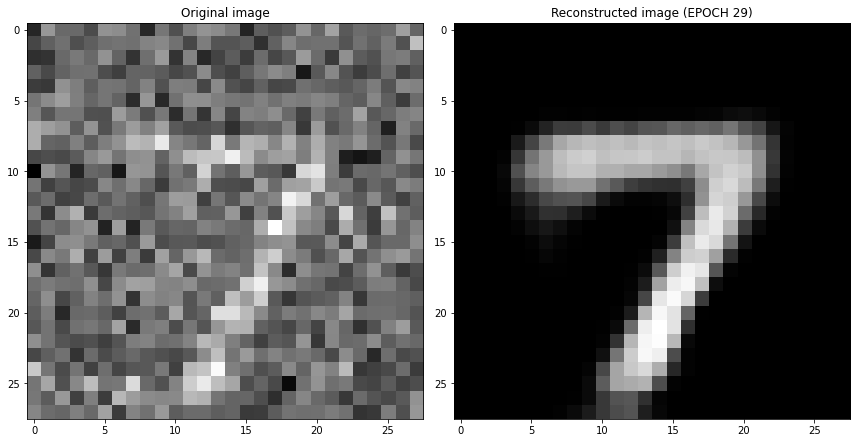

EPOCH 30/100
	 partial train loss (single batch): 0.204621
	 partial train loss (single batch): 0.205298
	 partial train loss (single batch): 0.202931
	 partial train loss (single batch): 0.203249
	 partial train loss (single batch): 0.203373
	 partial train loss (single batch): 0.203051
	 partial train loss (single batch): 0.204319
	 partial train loss (single batch): 0.200779
	 partial train loss (single batch): 0.205501
	 partial train loss (single batch): 0.201955
	 partial train loss (single batch): 0.203600
	 partial train loss (single batch): 0.203192
	 partial train loss (single batch): 0.202251
	 partial train loss (single batch): 0.201998
	 partial train loss (single batch): 0.202425
	 partial train loss (single batch): 0.203333
	 partial train loss (single batch): 0.203430
	 partial train loss (single batch): 0.203941
	 partial train loss (single batch): 0.204456
	 partial train loss (single batch): 0.203920
	 partial train loss (single batch): 0.203762
	 partial train loss 

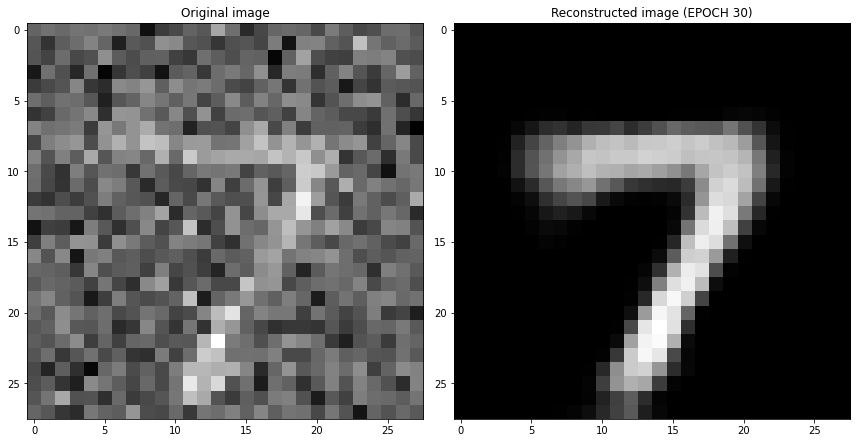

EPOCH 31/100
	 partial train loss (single batch): 0.200718
	 partial train loss (single batch): 0.203787
	 partial train loss (single batch): 0.203434
	 partial train loss (single batch): 0.203989
	 partial train loss (single batch): 0.202878
	 partial train loss (single batch): 0.203990
	 partial train loss (single batch): 0.202122
	 partial train loss (single batch): 0.203325
	 partial train loss (single batch): 0.203494
	 partial train loss (single batch): 0.202492
	 partial train loss (single batch): 0.203790
	 partial train loss (single batch): 0.202957
	 partial train loss (single batch): 0.201456
	 partial train loss (single batch): 0.203525
	 partial train loss (single batch): 0.204838
	 partial train loss (single batch): 0.204352
	 partial train loss (single batch): 0.201751
	 partial train loss (single batch): 0.203680
	 partial train loss (single batch): 0.202794
	 partial train loss (single batch): 0.200371
	 partial train loss (single batch): 0.204867
	 partial train loss 

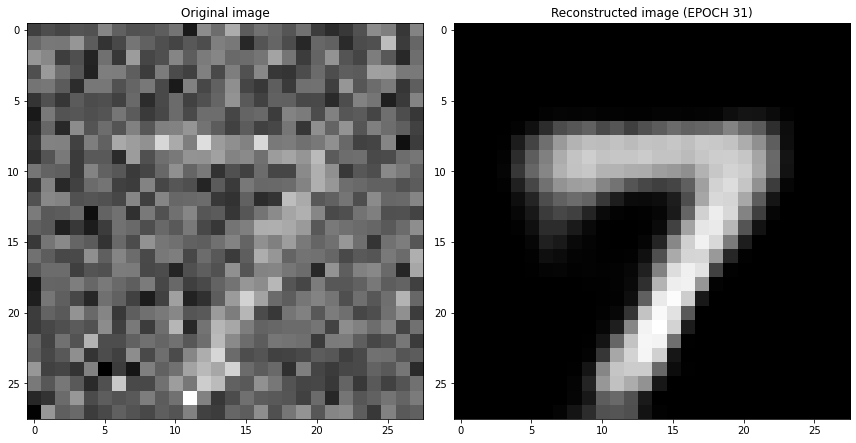

EPOCH 32/100
	 partial train loss (single batch): 0.201986
	 partial train loss (single batch): 0.204033
	 partial train loss (single batch): 0.200699
	 partial train loss (single batch): 0.202538
	 partial train loss (single batch): 0.204157
	 partial train loss (single batch): 0.203010
	 partial train loss (single batch): 0.203756
	 partial train loss (single batch): 0.204706
	 partial train loss (single batch): 0.202744
	 partial train loss (single batch): 0.200506
	 partial train loss (single batch): 0.203449
	 partial train loss (single batch): 0.203866
	 partial train loss (single batch): 0.200250
	 partial train loss (single batch): 0.204154
	 partial train loss (single batch): 0.201661
	 partial train loss (single batch): 0.202478
	 partial train loss (single batch): 0.204202
	 partial train loss (single batch): 0.202536
	 partial train loss (single batch): 0.204631
	 partial train loss (single batch): 0.203062
	 partial train loss (single batch): 0.203619
	 partial train loss 

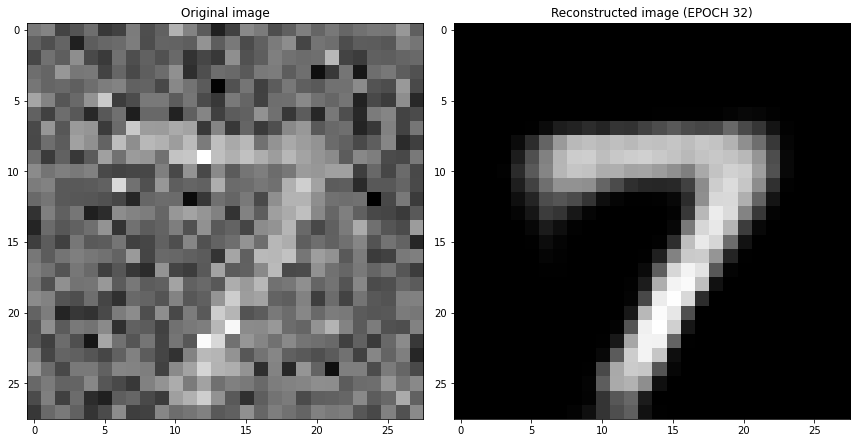

EPOCH 33/100
	 partial train loss (single batch): 0.205133
	 partial train loss (single batch): 0.203841
	 partial train loss (single batch): 0.202498
	 partial train loss (single batch): 0.203474
	 partial train loss (single batch): 0.203428
	 partial train loss (single batch): 0.203297
	 partial train loss (single batch): 0.202343
	 partial train loss (single batch): 0.202553
	 partial train loss (single batch): 0.203186
	 partial train loss (single batch): 0.202916
	 partial train loss (single batch): 0.200381
	 partial train loss (single batch): 0.203663
	 partial train loss (single batch): 0.202659
	 partial train loss (single batch): 0.201347
	 partial train loss (single batch): 0.203265
	 partial train loss (single batch): 0.204542
	 partial train loss (single batch): 0.202119
	 partial train loss (single batch): 0.203825
	 partial train loss (single batch): 0.203147
	 partial train loss (single batch): 0.201575
	 partial train loss (single batch): 0.204115
	 partial train loss 

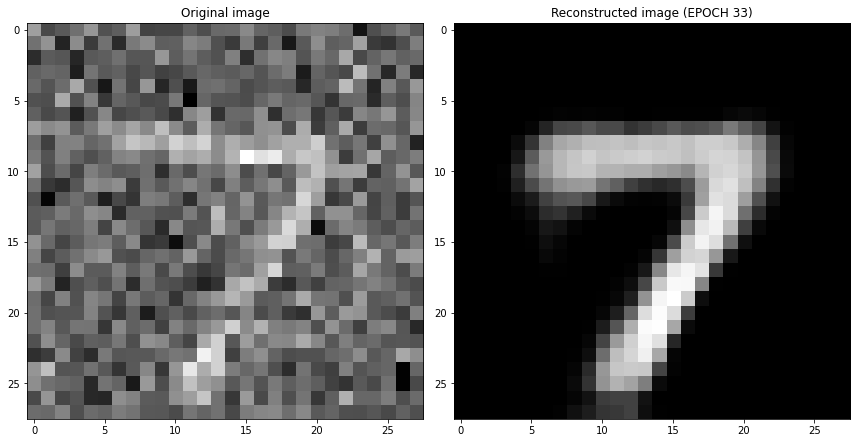

EPOCH 34/100
	 partial train loss (single batch): 0.201326
	 partial train loss (single batch): 0.207001
	 partial train loss (single batch): 0.205226
	 partial train loss (single batch): 0.202979
	 partial train loss (single batch): 0.202989
	 partial train loss (single batch): 0.203917
	 partial train loss (single batch): 0.202339
	 partial train loss (single batch): 0.202737
	 partial train loss (single batch): 0.204498
	 partial train loss (single batch): 0.203222
	 partial train loss (single batch): 0.202651
	 partial train loss (single batch): 0.202290
	 partial train loss (single batch): 0.203833
	 partial train loss (single batch): 0.202165
	 partial train loss (single batch): 0.201638
	 partial train loss (single batch): 0.203194
	 partial train loss (single batch): 0.203322
	 partial train loss (single batch): 0.202402
	 partial train loss (single batch): 0.200588
	 partial train loss (single batch): 0.201015
	 partial train loss (single batch): 0.205962
	 partial train loss 

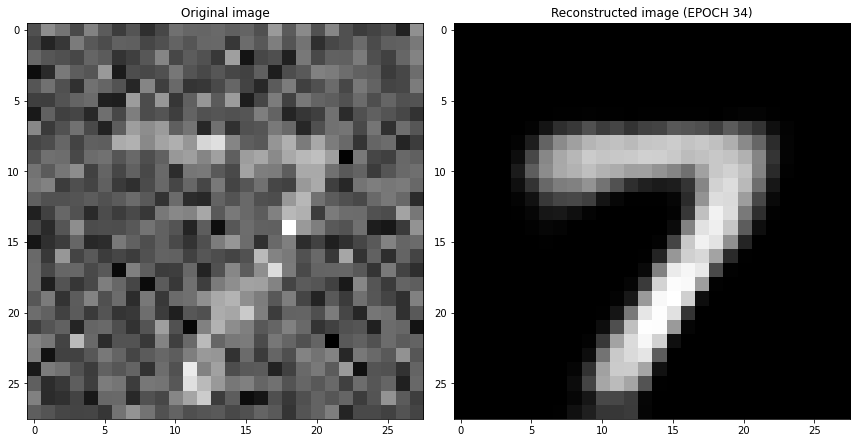

EPOCH 35/100
	 partial train loss (single batch): 0.204654
	 partial train loss (single batch): 0.203163
	 partial train loss (single batch): 0.203488
	 partial train loss (single batch): 0.205176
	 partial train loss (single batch): 0.204623
	 partial train loss (single batch): 0.201728
	 partial train loss (single batch): 0.202914
	 partial train loss (single batch): 0.203386
	 partial train loss (single batch): 0.204686
	 partial train loss (single batch): 0.202713
	 partial train loss (single batch): 0.203657
	 partial train loss (single batch): 0.205130
	 partial train loss (single batch): 0.205111
	 partial train loss (single batch): 0.204099
	 partial train loss (single batch): 0.201353
	 partial train loss (single batch): 0.203930
	 partial train loss (single batch): 0.202981
	 partial train loss (single batch): 0.203186
	 partial train loss (single batch): 0.203528
	 partial train loss (single batch): 0.203617
	 partial train loss (single batch): 0.201086
	 partial train loss 

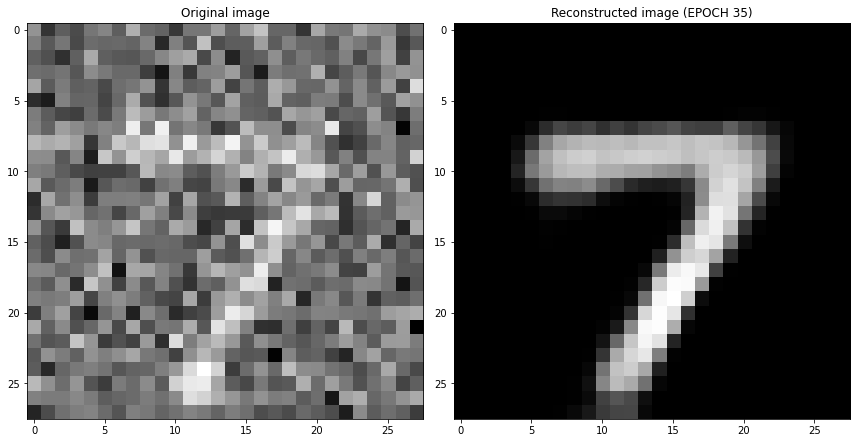

EPOCH 36/100
	 partial train loss (single batch): 0.204261
	 partial train loss (single batch): 0.201008
	 partial train loss (single batch): 0.203921
	 partial train loss (single batch): 0.204178
	 partial train loss (single batch): 0.203069
	 partial train loss (single batch): 0.202386
	 partial train loss (single batch): 0.201253
	 partial train loss (single batch): 0.202391
	 partial train loss (single batch): 0.203956
	 partial train loss (single batch): 0.204213
	 partial train loss (single batch): 0.202058
	 partial train loss (single batch): 0.204609
	 partial train loss (single batch): 0.200008
	 partial train loss (single batch): 0.203588
	 partial train loss (single batch): 0.202535
	 partial train loss (single batch): 0.203320
	 partial train loss (single batch): 0.204986
	 partial train loss (single batch): 0.202884
	 partial train loss (single batch): 0.202502
	 partial train loss (single batch): 0.203739
	 partial train loss (single batch): 0.203019
	 partial train loss 

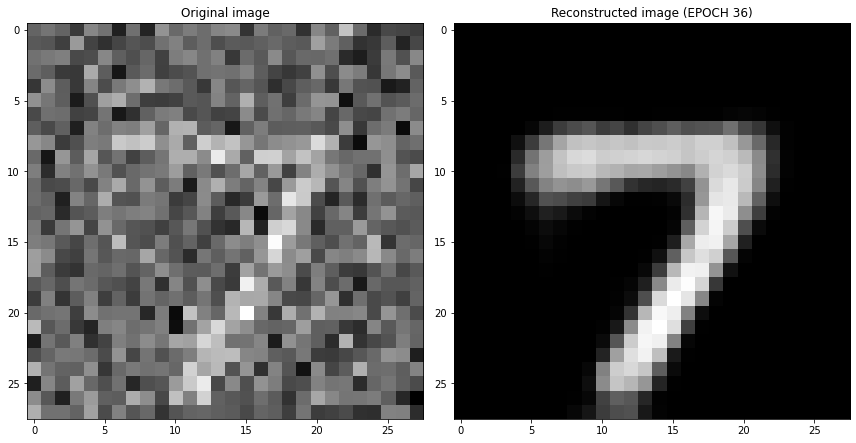

EPOCH 37/100
	 partial train loss (single batch): 0.202086
	 partial train loss (single batch): 0.203480
	 partial train loss (single batch): 0.204780
	 partial train loss (single batch): 0.204354
	 partial train loss (single batch): 0.202344
	 partial train loss (single batch): 0.203374
	 partial train loss (single batch): 0.203986
	 partial train loss (single batch): 0.203415
	 partial train loss (single batch): 0.204197
	 partial train loss (single batch): 0.203908
	 partial train loss (single batch): 0.202230
	 partial train loss (single batch): 0.203275
	 partial train loss (single batch): 0.202265
	 partial train loss (single batch): 0.205448
	 partial train loss (single batch): 0.202418
	 partial train loss (single batch): 0.202641
	 partial train loss (single batch): 0.203468
	 partial train loss (single batch): 0.202922
	 partial train loss (single batch): 0.201646
	 partial train loss (single batch): 0.201987
	 partial train loss (single batch): 0.201602
	 partial train loss 

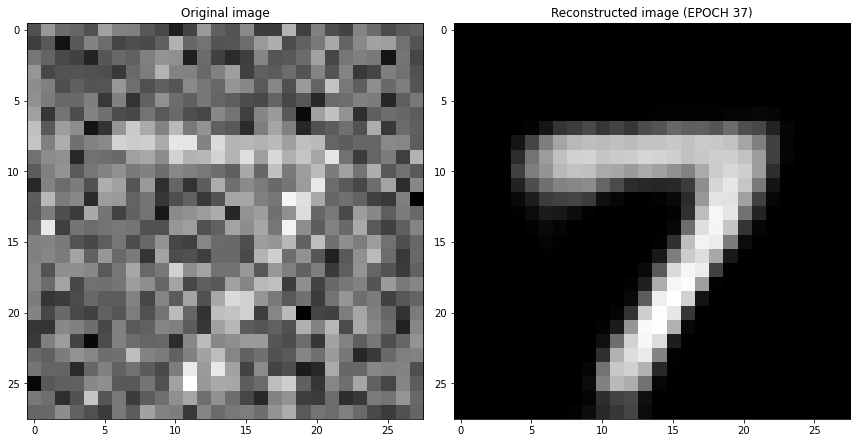

EPOCH 38/100
	 partial train loss (single batch): 0.203796
	 partial train loss (single batch): 0.202805
	 partial train loss (single batch): 0.202499
	 partial train loss (single batch): 0.201622
	 partial train loss (single batch): 0.203141
	 partial train loss (single batch): 0.203852
	 partial train loss (single batch): 0.202809
	 partial train loss (single batch): 0.202394
	 partial train loss (single batch): 0.202961
	 partial train loss (single batch): 0.201850
	 partial train loss (single batch): 0.203454
	 partial train loss (single batch): 0.205091
	 partial train loss (single batch): 0.203440
	 partial train loss (single batch): 0.204009
	 partial train loss (single batch): 0.199235
	 partial train loss (single batch): 0.203600
	 partial train loss (single batch): 0.202175
	 partial train loss (single batch): 0.201024
	 partial train loss (single batch): 0.203513
	 partial train loss (single batch): 0.203129
	 partial train loss (single batch): 0.203437
	 partial train loss 

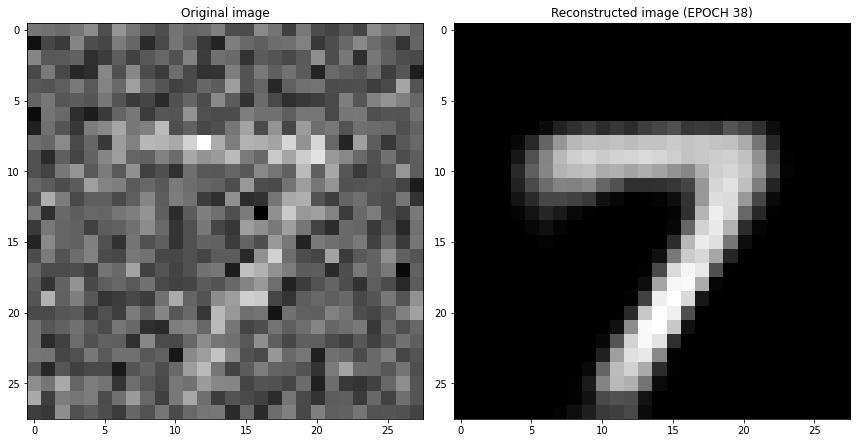

EPOCH 39/100
	 partial train loss (single batch): 0.203296
	 partial train loss (single batch): 0.202865
	 partial train loss (single batch): 0.201834
	 partial train loss (single batch): 0.202846
	 partial train loss (single batch): 0.203429
	 partial train loss (single batch): 0.200416
	 partial train loss (single batch): 0.202895
	 partial train loss (single batch): 0.201657
	 partial train loss (single batch): 0.201987
	 partial train loss (single batch): 0.203526
	 partial train loss (single batch): 0.204610
	 partial train loss (single batch): 0.200555
	 partial train loss (single batch): 0.205158
	 partial train loss (single batch): 0.202466
	 partial train loss (single batch): 0.201724
	 partial train loss (single batch): 0.204653
	 partial train loss (single batch): 0.202040
	 partial train loss (single batch): 0.203761
	 partial train loss (single batch): 0.205376
	 partial train loss (single batch): 0.201106
	 partial train loss (single batch): 0.203196
	 partial train loss 

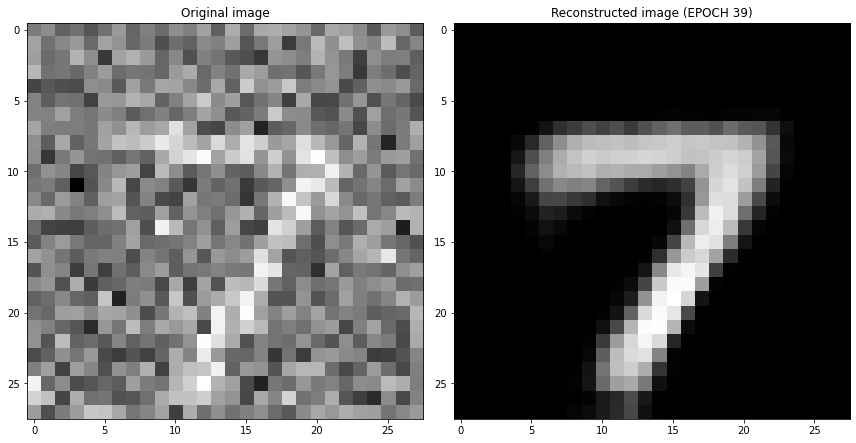

EPOCH 40/100
	 partial train loss (single batch): 0.202277
	 partial train loss (single batch): 0.202289
	 partial train loss (single batch): 0.204284
	 partial train loss (single batch): 0.203487
	 partial train loss (single batch): 0.201775
	 partial train loss (single batch): 0.203125
	 partial train loss (single batch): 0.202398
	 partial train loss (single batch): 0.202415
	 partial train loss (single batch): 0.202631
	 partial train loss (single batch): 0.203155
	 partial train loss (single batch): 0.202907
	 partial train loss (single batch): 0.203192
	 partial train loss (single batch): 0.203142
	 partial train loss (single batch): 0.203280
	 partial train loss (single batch): 0.203808
	 partial train loss (single batch): 0.204113
	 partial train loss (single batch): 0.203868
	 partial train loss (single batch): 0.203270
	 partial train loss (single batch): 0.203022
	 partial train loss (single batch): 0.201274
	 partial train loss (single batch): 0.201306
	 partial train loss 

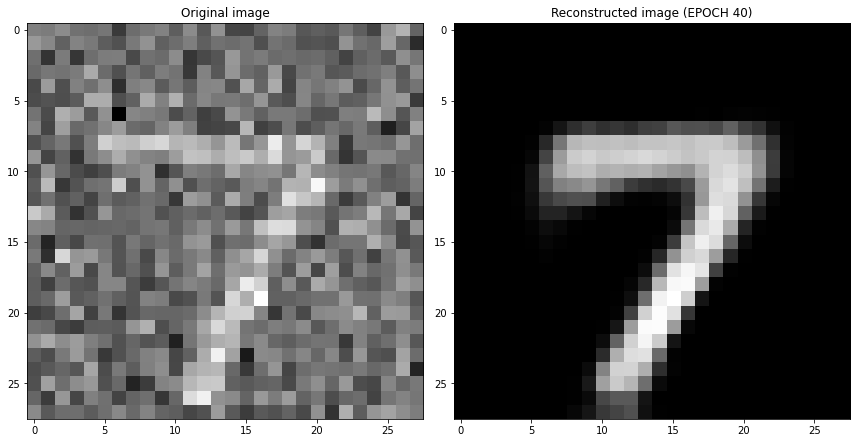

EPOCH 41/100
	 partial train loss (single batch): 0.203356
	 partial train loss (single batch): 0.200178
	 partial train loss (single batch): 0.202464
	 partial train loss (single batch): 0.200151
	 partial train loss (single batch): 0.203978
	 partial train loss (single batch): 0.199102
	 partial train loss (single batch): 0.204513
	 partial train loss (single batch): 0.204273
	 partial train loss (single batch): 0.202569
	 partial train loss (single batch): 0.201670
	 partial train loss (single batch): 0.203323
	 partial train loss (single batch): 0.202384
	 partial train loss (single batch): 0.200595
	 partial train loss (single batch): 0.202074
	 partial train loss (single batch): 0.201124
	 partial train loss (single batch): 0.201976
	 partial train loss (single batch): 0.201019
	 partial train loss (single batch): 0.200701
	 partial train loss (single batch): 0.203597
	 partial train loss (single batch): 0.202442
	 partial train loss (single batch): 0.203888
	 partial train loss 

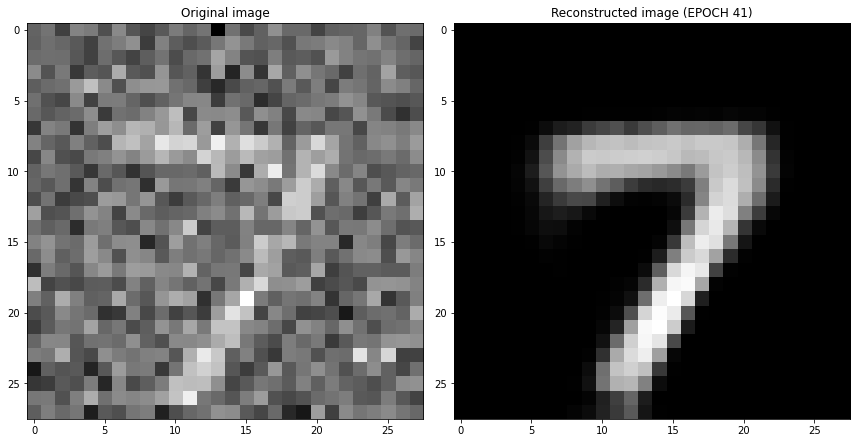

EPOCH 42/100
	 partial train loss (single batch): 0.204044
	 partial train loss (single batch): 0.202471
	 partial train loss (single batch): 0.205024
	 partial train loss (single batch): 0.204367
	 partial train loss (single batch): 0.203282
	 partial train loss (single batch): 0.202399
	 partial train loss (single batch): 0.204095
	 partial train loss (single batch): 0.201251
	 partial train loss (single batch): 0.203556
	 partial train loss (single batch): 0.203380
	 partial train loss (single batch): 0.202743
	 partial train loss (single batch): 0.202121
	 partial train loss (single batch): 0.202120
	 partial train loss (single batch): 0.202870
	 partial train loss (single batch): 0.202594
	 partial train loss (single batch): 0.201841
	 partial train loss (single batch): 0.201024
	 partial train loss (single batch): 0.203624
	 partial train loss (single batch): 0.204384
	 partial train loss (single batch): 0.204282
	 partial train loss (single batch): 0.202374
	 partial train loss 

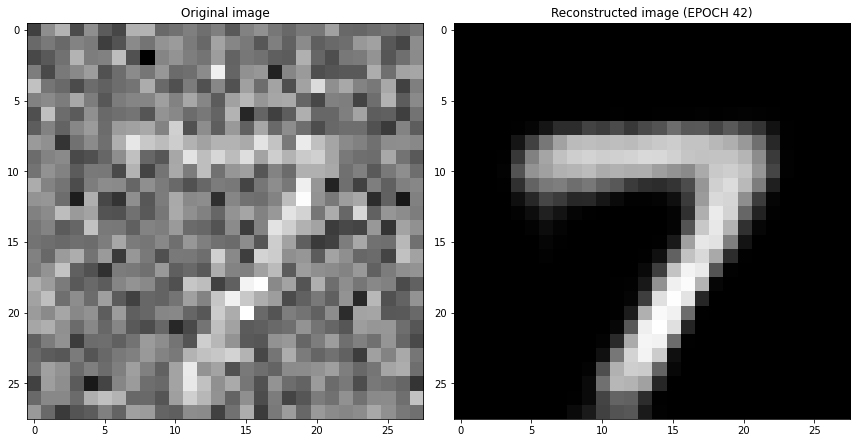

EPOCH 43/100
	 partial train loss (single batch): 0.204579
	 partial train loss (single batch): 0.204693
	 partial train loss (single batch): 0.202551
	 partial train loss (single batch): 0.204063
	 partial train loss (single batch): 0.204794
	 partial train loss (single batch): 0.202054
	 partial train loss (single batch): 0.202092
	 partial train loss (single batch): 0.202132
	 partial train loss (single batch): 0.201173
	 partial train loss (single batch): 0.204218
	 partial train loss (single batch): 0.202852
	 partial train loss (single batch): 0.203176
	 partial train loss (single batch): 0.200004
	 partial train loss (single batch): 0.201439
	 partial train loss (single batch): 0.204582
	 partial train loss (single batch): 0.201564
	 partial train loss (single batch): 0.203444
	 partial train loss (single batch): 0.203216
	 partial train loss (single batch): 0.201032
	 partial train loss (single batch): 0.202567
	 partial train loss (single batch): 0.201907
	 partial train loss 

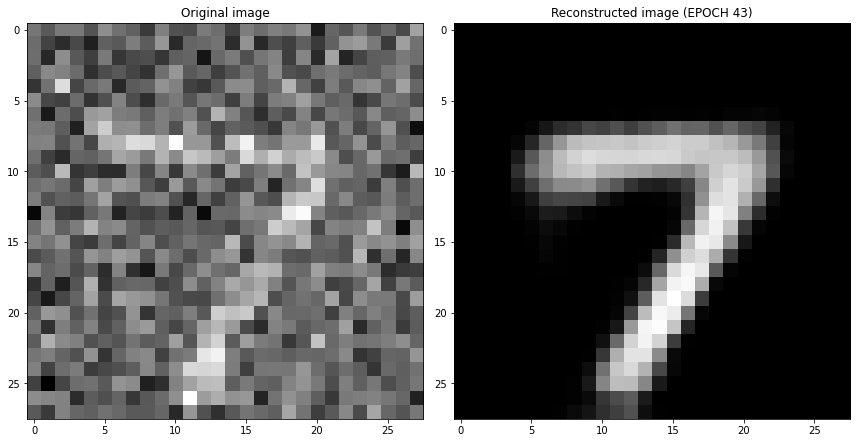

EPOCH 44/100
	 partial train loss (single batch): 0.203468
	 partial train loss (single batch): 0.202899
	 partial train loss (single batch): 0.202955
	 partial train loss (single batch): 0.204687
	 partial train loss (single batch): 0.203452
	 partial train loss (single batch): 0.205302
	 partial train loss (single batch): 0.203288
	 partial train loss (single batch): 0.202335
	 partial train loss (single batch): 0.202424
	 partial train loss (single batch): 0.200897
	 partial train loss (single batch): 0.204477
	 partial train loss (single batch): 0.202060
	 partial train loss (single batch): 0.201918
	 partial train loss (single batch): 0.202655
	 partial train loss (single batch): 0.202863
	 partial train loss (single batch): 0.203623
	 partial train loss (single batch): 0.202060
	 partial train loss (single batch): 0.202144
	 partial train loss (single batch): 0.202180
	 partial train loss (single batch): 0.202979
	 partial train loss (single batch): 0.203574
	 partial train loss 

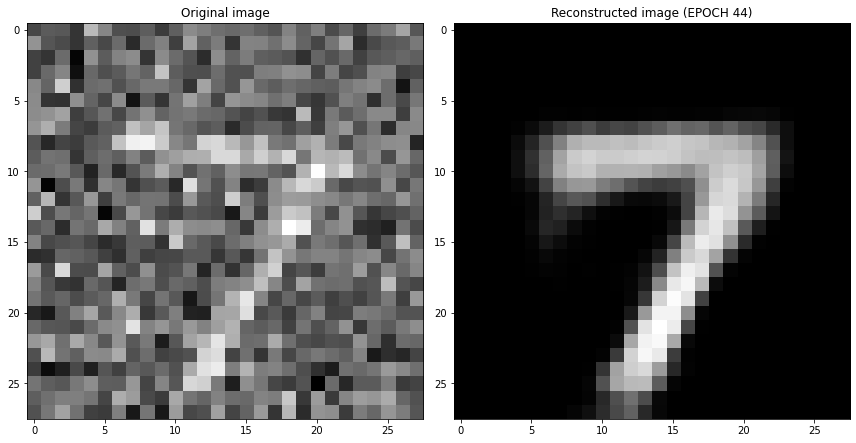

EPOCH 45/100
	 partial train loss (single batch): 0.203880
	 partial train loss (single batch): 0.203150
	 partial train loss (single batch): 0.205474
	 partial train loss (single batch): 0.203337
	 partial train loss (single batch): 0.202385
	 partial train loss (single batch): 0.202293
	 partial train loss (single batch): 0.201630
	 partial train loss (single batch): 0.203068
	 partial train loss (single batch): 0.203325
	 partial train loss (single batch): 0.201493
	 partial train loss (single batch): 0.203175
	 partial train loss (single batch): 0.201853
	 partial train loss (single batch): 0.201242
	 partial train loss (single batch): 0.204013
	 partial train loss (single batch): 0.201816
	 partial train loss (single batch): 0.202266
	 partial train loss (single batch): 0.202543
	 partial train loss (single batch): 0.201725
	 partial train loss (single batch): 0.202063
	 partial train loss (single batch): 0.203982
	 partial train loss (single batch): 0.203239
	 partial train loss 

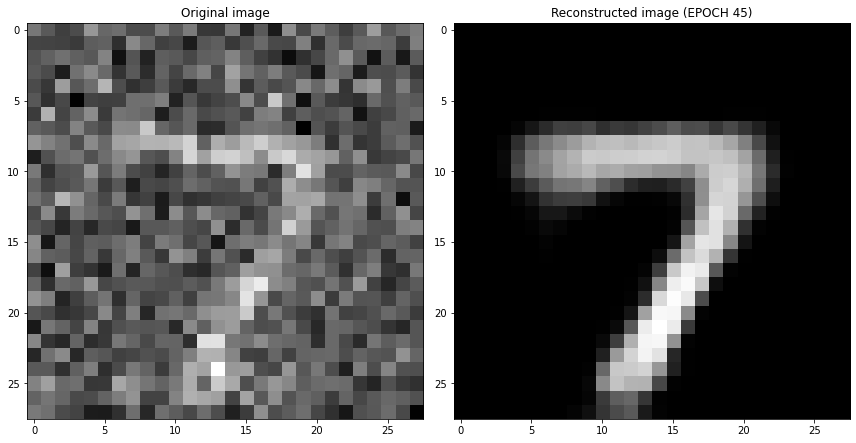

EPOCH 46/100
	 partial train loss (single batch): 0.201597
	 partial train loss (single batch): 0.204602
	 partial train loss (single batch): 0.202456
	 partial train loss (single batch): 0.201884
	 partial train loss (single batch): 0.202358
	 partial train loss (single batch): 0.203055
	 partial train loss (single batch): 0.202786
	 partial train loss (single batch): 0.202606
	 partial train loss (single batch): 0.202259
	 partial train loss (single batch): 0.203428
	 partial train loss (single batch): 0.201430
	 partial train loss (single batch): 0.202554
	 partial train loss (single batch): 0.199957
	 partial train loss (single batch): 0.202741
	 partial train loss (single batch): 0.204656
	 partial train loss (single batch): 0.203595
	 partial train loss (single batch): 0.203487
	 partial train loss (single batch): 0.202894
	 partial train loss (single batch): 0.205276
	 partial train loss (single batch): 0.202551
	 partial train loss (single batch): 0.201707
	 partial train loss 

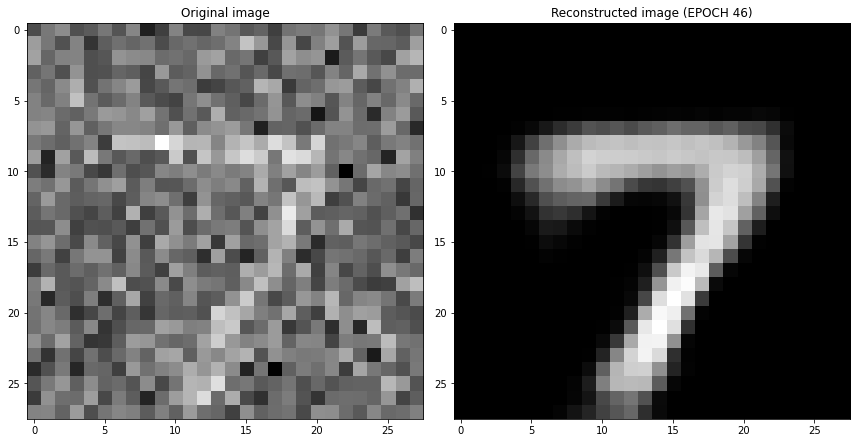

EPOCH 47/100
	 partial train loss (single batch): 0.201548
	 partial train loss (single batch): 0.203918
	 partial train loss (single batch): 0.201716
	 partial train loss (single batch): 0.200526
	 partial train loss (single batch): 0.201319
	 partial train loss (single batch): 0.203074
	 partial train loss (single batch): 0.201313
	 partial train loss (single batch): 0.200955
	 partial train loss (single batch): 0.205551
	 partial train loss (single batch): 0.203304
	 partial train loss (single batch): 0.201504
	 partial train loss (single batch): 0.202845
	 partial train loss (single batch): 0.203588
	 partial train loss (single batch): 0.202839
	 partial train loss (single batch): 0.203068
	 partial train loss (single batch): 0.205881
	 partial train loss (single batch): 0.203282
	 partial train loss (single batch): 0.203230
	 partial train loss (single batch): 0.202468
	 partial train loss (single batch): 0.202930
	 partial train loss (single batch): 0.200228
	 partial train loss 

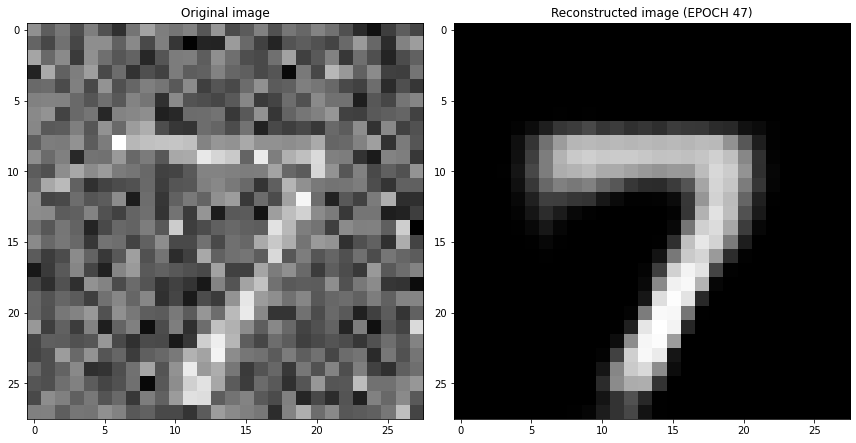

EPOCH 48/100
	 partial train loss (single batch): 0.202783
	 partial train loss (single batch): 0.204120
	 partial train loss (single batch): 0.203155
	 partial train loss (single batch): 0.203481
	 partial train loss (single batch): 0.202298
	 partial train loss (single batch): 0.204392
	 partial train loss (single batch): 0.203516
	 partial train loss (single batch): 0.202450
	 partial train loss (single batch): 0.203638
	 partial train loss (single batch): 0.203099
	 partial train loss (single batch): 0.200869
	 partial train loss (single batch): 0.203373
	 partial train loss (single batch): 0.200620
	 partial train loss (single batch): 0.204689
	 partial train loss (single batch): 0.201122
	 partial train loss (single batch): 0.201177
	 partial train loss (single batch): 0.202689
	 partial train loss (single batch): 0.200637
	 partial train loss (single batch): 0.202029
	 partial train loss (single batch): 0.201954
	 partial train loss (single batch): 0.203170
	 partial train loss 

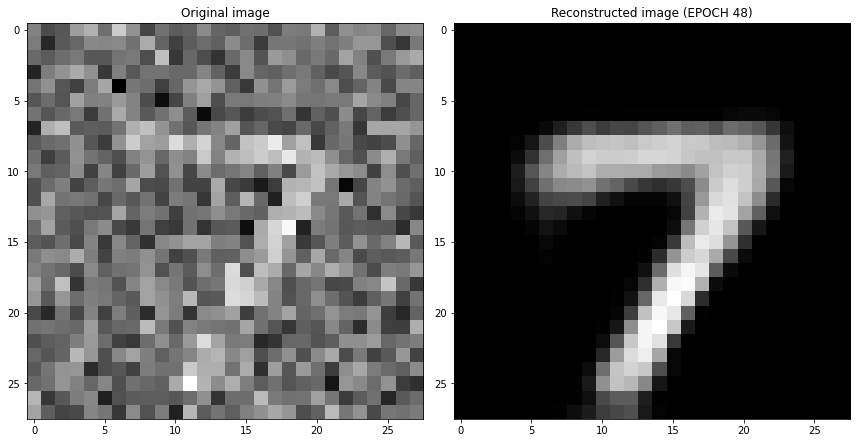

EPOCH 49/100
	 partial train loss (single batch): 0.203623
	 partial train loss (single batch): 0.202291
	 partial train loss (single batch): 0.204143
	 partial train loss (single batch): 0.200650
	 partial train loss (single batch): 0.201435
	 partial train loss (single batch): 0.202982
	 partial train loss (single batch): 0.202679
	 partial train loss (single batch): 0.204559
	 partial train loss (single batch): 0.201674
	 partial train loss (single batch): 0.201375
	 partial train loss (single batch): 0.202923
	 partial train loss (single batch): 0.202706
	 partial train loss (single batch): 0.201534
	 partial train loss (single batch): 0.200259
	 partial train loss (single batch): 0.202690
	 partial train loss (single batch): 0.201583
	 partial train loss (single batch): 0.201311
	 partial train loss (single batch): 0.203221
	 partial train loss (single batch): 0.203338
	 partial train loss (single batch): 0.201246
	 partial train loss (single batch): 0.201684
	 partial train loss 

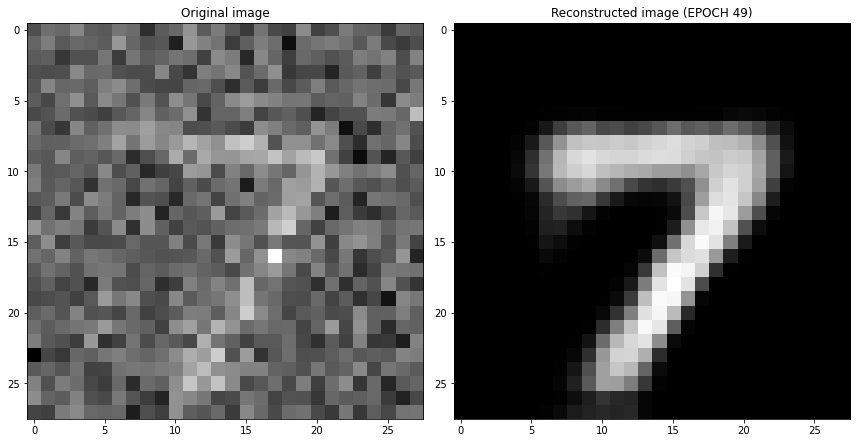

EPOCH 50/100
	 partial train loss (single batch): 0.202354
	 partial train loss (single batch): 0.200984
	 partial train loss (single batch): 0.202939
	 partial train loss (single batch): 0.203063
	 partial train loss (single batch): 0.201843
	 partial train loss (single batch): 0.201965
	 partial train loss (single batch): 0.199427
	 partial train loss (single batch): 0.204127
	 partial train loss (single batch): 0.206849
	 partial train loss (single batch): 0.205147
	 partial train loss (single batch): 0.204210
	 partial train loss (single batch): 0.201413
	 partial train loss (single batch): 0.201163
	 partial train loss (single batch): 0.203159
	 partial train loss (single batch): 0.202073
	 partial train loss (single batch): 0.205401
	 partial train loss (single batch): 0.202808
	 partial train loss (single batch): 0.201144
	 partial train loss (single batch): 0.205494
	 partial train loss (single batch): 0.200899
	 partial train loss (single batch): 0.201025
	 partial train loss 

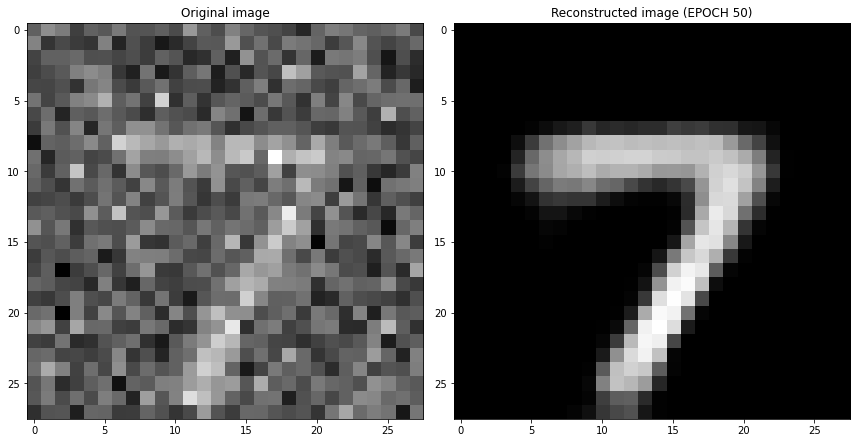

EPOCH 51/100
	 partial train loss (single batch): 0.200660
	 partial train loss (single batch): 0.202077
	 partial train loss (single batch): 0.202138
	 partial train loss (single batch): 0.203331
	 partial train loss (single batch): 0.204465
	 partial train loss (single batch): 0.201565
	 partial train loss (single batch): 0.199735
	 partial train loss (single batch): 0.200197
	 partial train loss (single batch): 0.202494
	 partial train loss (single batch): 0.201467
	 partial train loss (single batch): 0.201173
	 partial train loss (single batch): 0.202587
	 partial train loss (single batch): 0.202584
	 partial train loss (single batch): 0.206287
	 partial train loss (single batch): 0.199913
	 partial train loss (single batch): 0.202994
	 partial train loss (single batch): 0.201923
	 partial train loss (single batch): 0.203523
	 partial train loss (single batch): 0.204610
	 partial train loss (single batch): 0.200189
	 partial train loss (single batch): 0.202680
	 partial train loss 

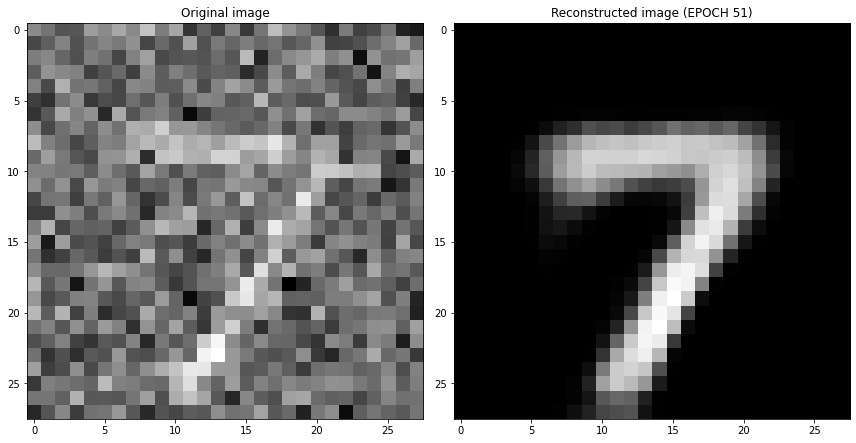

EPOCH 52/100
	 partial train loss (single batch): 0.202304
	 partial train loss (single batch): 0.203009
	 partial train loss (single batch): 0.201016
	 partial train loss (single batch): 0.201058
	 partial train loss (single batch): 0.201160
	 partial train loss (single batch): 0.205372
	 partial train loss (single batch): 0.203777
	 partial train loss (single batch): 0.202508
	 partial train loss (single batch): 0.201716
	 partial train loss (single batch): 0.200551
	 partial train loss (single batch): 0.203812
	 partial train loss (single batch): 0.203923
	 partial train loss (single batch): 0.203915
	 partial train loss (single batch): 0.199619
	 partial train loss (single batch): 0.204232
	 partial train loss (single batch): 0.202129
	 partial train loss (single batch): 0.202788
	 partial train loss (single batch): 0.202745
	 partial train loss (single batch): 0.201486
	 partial train loss (single batch): 0.203160
	 partial train loss (single batch): 0.200855
	 partial train loss 

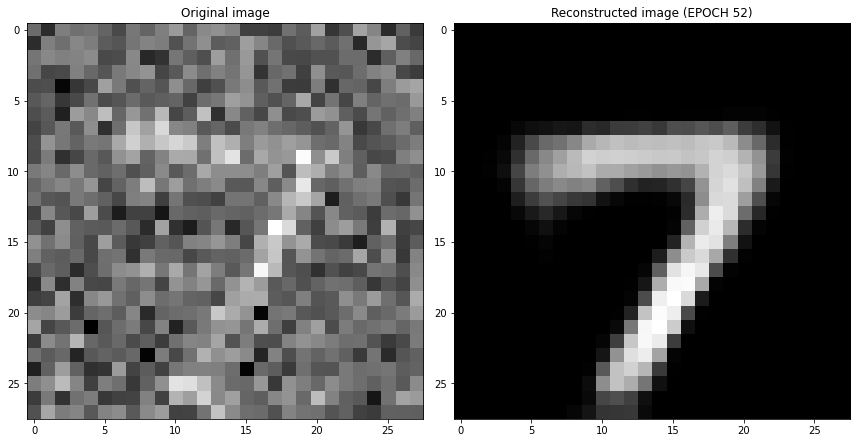

EPOCH 53/100
	 partial train loss (single batch): 0.202903
	 partial train loss (single batch): 0.203387
	 partial train loss (single batch): 0.203873
	 partial train loss (single batch): 0.202931
	 partial train loss (single batch): 0.202888
	 partial train loss (single batch): 0.201449
	 partial train loss (single batch): 0.201786
	 partial train loss (single batch): 0.202865
	 partial train loss (single batch): 0.200754
	 partial train loss (single batch): 0.202262
	 partial train loss (single batch): 0.202410
	 partial train loss (single batch): 0.202671
	 partial train loss (single batch): 0.201343
	 partial train loss (single batch): 0.203605
	 partial train loss (single batch): 0.200770
	 partial train loss (single batch): 0.202077
	 partial train loss (single batch): 0.204007
	 partial train loss (single batch): 0.202264
	 partial train loss (single batch): 0.203877
	 partial train loss (single batch): 0.202704
	 partial train loss (single batch): 0.202788
	 partial train loss 

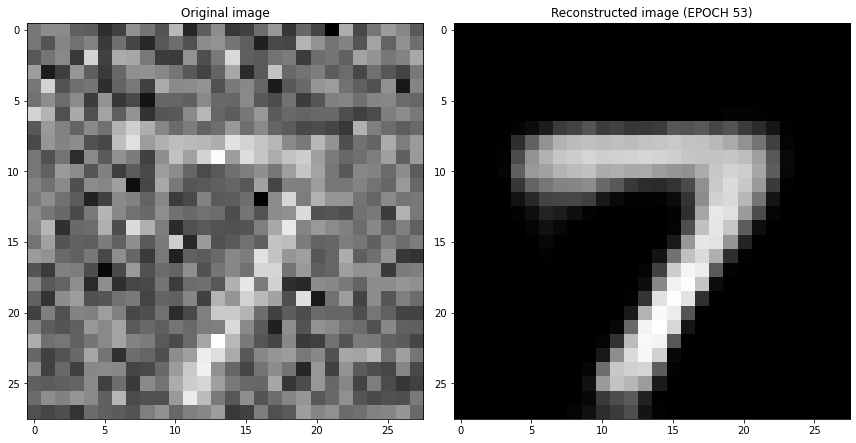

EPOCH 54/100
	 partial train loss (single batch): 0.199705
	 partial train loss (single batch): 0.202536
	 partial train loss (single batch): 0.201403
	 partial train loss (single batch): 0.200317
	 partial train loss (single batch): 0.204005
	 partial train loss (single batch): 0.202790
	 partial train loss (single batch): 0.204212
	 partial train loss (single batch): 0.203655
	 partial train loss (single batch): 0.203780
	 partial train loss (single batch): 0.199895
	 partial train loss (single batch): 0.203864
	 partial train loss (single batch): 0.202113
	 partial train loss (single batch): 0.203573
	 partial train loss (single batch): 0.202375
	 partial train loss (single batch): 0.203094
	 partial train loss (single batch): 0.200881
	 partial train loss (single batch): 0.200526
	 partial train loss (single batch): 0.204873
	 partial train loss (single batch): 0.203080
	 partial train loss (single batch): 0.203152
	 partial train loss (single batch): 0.201521
	 partial train loss 

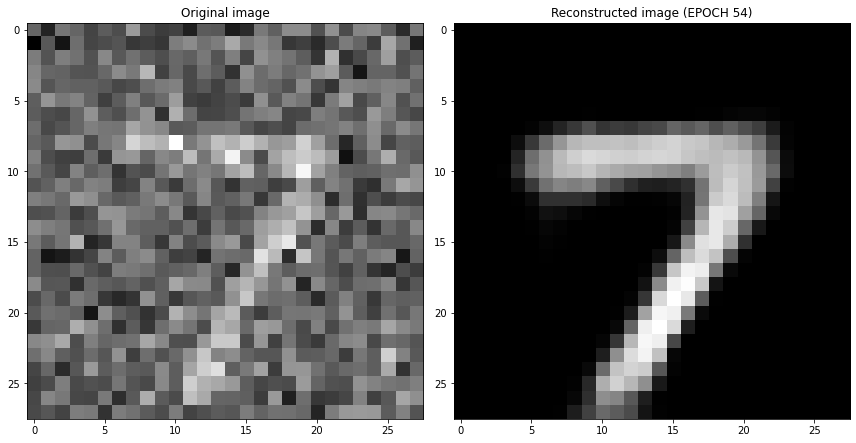

EPOCH 55/100
	 partial train loss (single batch): 0.202673
	 partial train loss (single batch): 0.201085
	 partial train loss (single batch): 0.202481
	 partial train loss (single batch): 0.200925
	 partial train loss (single batch): 0.202470
	 partial train loss (single batch): 0.204838
	 partial train loss (single batch): 0.201544
	 partial train loss (single batch): 0.202765
	 partial train loss (single batch): 0.200705
	 partial train loss (single batch): 0.201212
	 partial train loss (single batch): 0.202161
	 partial train loss (single batch): 0.203719
	 partial train loss (single batch): 0.202664
	 partial train loss (single batch): 0.198182
	 partial train loss (single batch): 0.201847
	 partial train loss (single batch): 0.202009
	 partial train loss (single batch): 0.201197
	 partial train loss (single batch): 0.202688
	 partial train loss (single batch): 0.203073
	 partial train loss (single batch): 0.202969
	 partial train loss (single batch): 0.205442
	 partial train loss 

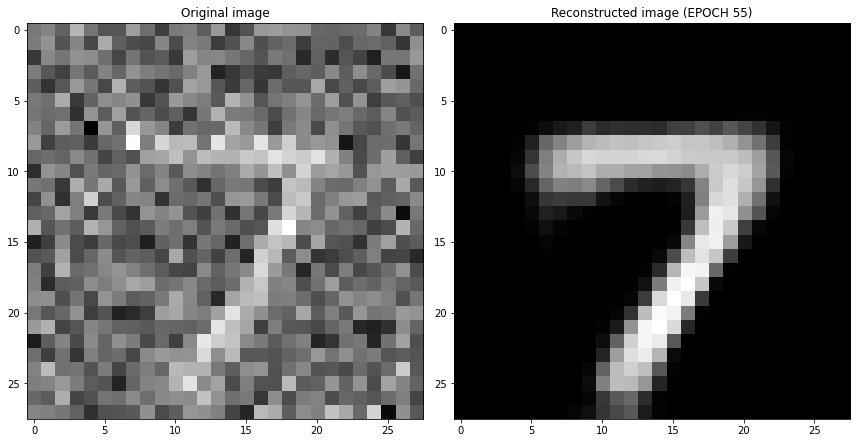

EPOCH 56/100
	 partial train loss (single batch): 0.203461
	 partial train loss (single batch): 0.200193
	 partial train loss (single batch): 0.202605
	 partial train loss (single batch): 0.201707
	 partial train loss (single batch): 0.204593
	 partial train loss (single batch): 0.202866
	 partial train loss (single batch): 0.201786
	 partial train loss (single batch): 0.200808
	 partial train loss (single batch): 0.203220
	 partial train loss (single batch): 0.203135
	 partial train loss (single batch): 0.201781
	 partial train loss (single batch): 0.202127
	 partial train loss (single batch): 0.202128
	 partial train loss (single batch): 0.202103
	 partial train loss (single batch): 0.204134
	 partial train loss (single batch): 0.203917
	 partial train loss (single batch): 0.201686
	 partial train loss (single batch): 0.203924
	 partial train loss (single batch): 0.202272
	 partial train loss (single batch): 0.203295
	 partial train loss (single batch): 0.201970
	 partial train loss 

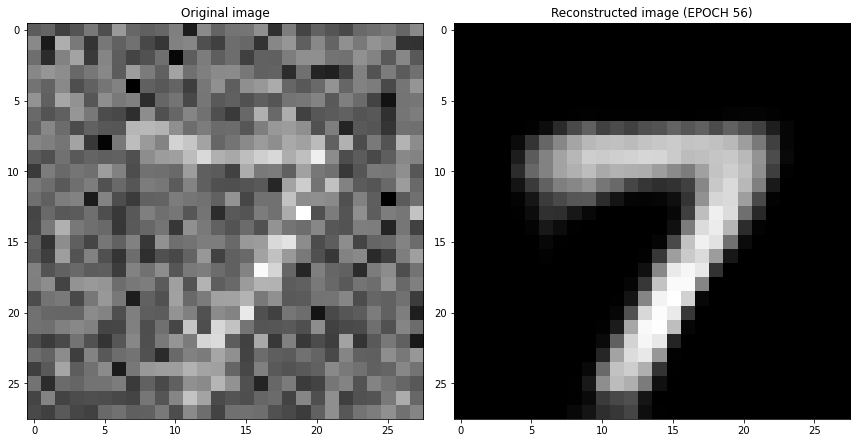

EPOCH 57/100
	 partial train loss (single batch): 0.202567
	 partial train loss (single batch): 0.202945
	 partial train loss (single batch): 0.203859
	 partial train loss (single batch): 0.201752
	 partial train loss (single batch): 0.200929
	 partial train loss (single batch): 0.203571
	 partial train loss (single batch): 0.203335
	 partial train loss (single batch): 0.200499
	 partial train loss (single batch): 0.204500
	 partial train loss (single batch): 0.200693
	 partial train loss (single batch): 0.203236
	 partial train loss (single batch): 0.202970
	 partial train loss (single batch): 0.201639
	 partial train loss (single batch): 0.200601
	 partial train loss (single batch): 0.202005
	 partial train loss (single batch): 0.203200
	 partial train loss (single batch): 0.201544
	 partial train loss (single batch): 0.202437
	 partial train loss (single batch): 0.204591
	 partial train loss (single batch): 0.198569
	 partial train loss (single batch): 0.202266
	 partial train loss 

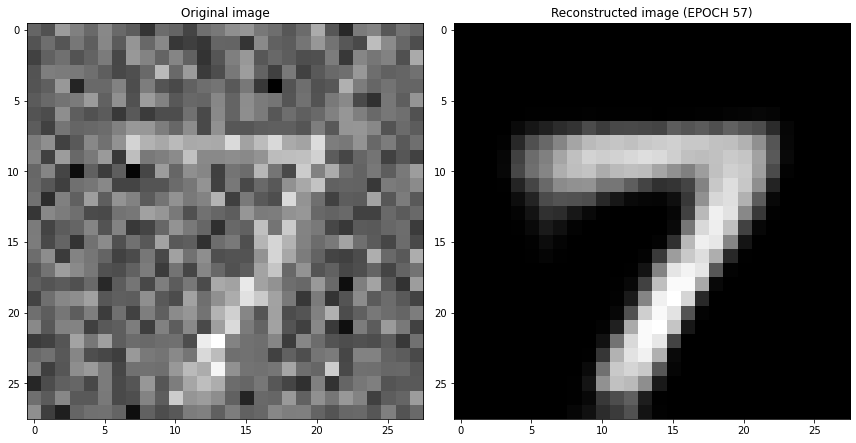

EPOCH 58/100
	 partial train loss (single batch): 0.202323
	 partial train loss (single batch): 0.204977
	 partial train loss (single batch): 0.202075
	 partial train loss (single batch): 0.202646
	 partial train loss (single batch): 0.202379
	 partial train loss (single batch): 0.201306
	 partial train loss (single batch): 0.201464
	 partial train loss (single batch): 0.200693
	 partial train loss (single batch): 0.201114
	 partial train loss (single batch): 0.200502
	 partial train loss (single batch): 0.202932
	 partial train loss (single batch): 0.202317
	 partial train loss (single batch): 0.201968
	 partial train loss (single batch): 0.203225
	 partial train loss (single batch): 0.203996
	 partial train loss (single batch): 0.203459
	 partial train loss (single batch): 0.201890
	 partial train loss (single batch): 0.201960
	 partial train loss (single batch): 0.203158
	 partial train loss (single batch): 0.202284
	 partial train loss (single batch): 0.200581
	 partial train loss 

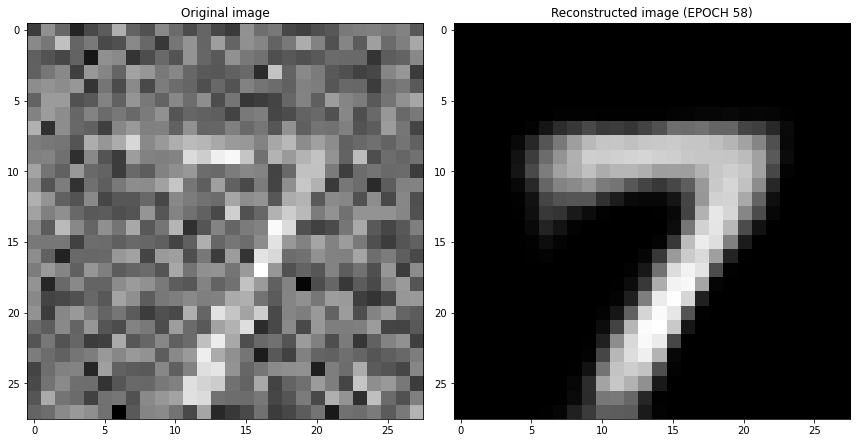

EPOCH 59/100
	 partial train loss (single batch): 0.203195
	 partial train loss (single batch): 0.203328
	 partial train loss (single batch): 0.202448
	 partial train loss (single batch): 0.204075
	 partial train loss (single batch): 0.201503
	 partial train loss (single batch): 0.202003
	 partial train loss (single batch): 0.202848
	 partial train loss (single batch): 0.204425
	 partial train loss (single batch): 0.203683
	 partial train loss (single batch): 0.201753
	 partial train loss (single batch): 0.201433
	 partial train loss (single batch): 0.202406
	 partial train loss (single batch): 0.202999
	 partial train loss (single batch): 0.202300
	 partial train loss (single batch): 0.201854
	 partial train loss (single batch): 0.202298
	 partial train loss (single batch): 0.202381
	 partial train loss (single batch): 0.200847
	 partial train loss (single batch): 0.201863
	 partial train loss (single batch): 0.202343
	 partial train loss (single batch): 0.203403
	 partial train loss 

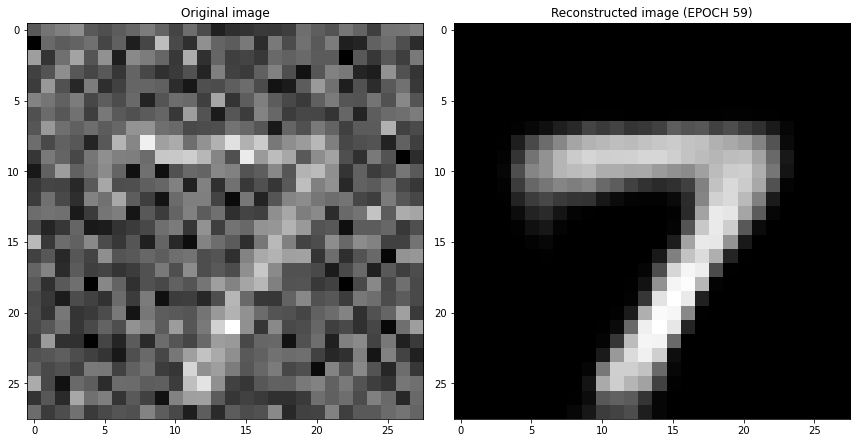

EPOCH 60/100
	 partial train loss (single batch): 0.203334
	 partial train loss (single batch): 0.203291
	 partial train loss (single batch): 0.202293
	 partial train loss (single batch): 0.202942
	 partial train loss (single batch): 0.202868
	 partial train loss (single batch): 0.200800
	 partial train loss (single batch): 0.201312
	 partial train loss (single batch): 0.204907
	 partial train loss (single batch): 0.202576
	 partial train loss (single batch): 0.202746
	 partial train loss (single batch): 0.202482
	 partial train loss (single batch): 0.201567
	 partial train loss (single batch): 0.203951
	 partial train loss (single batch): 0.202089
	 partial train loss (single batch): 0.201974
	 partial train loss (single batch): 0.203754
	 partial train loss (single batch): 0.199486
	 partial train loss (single batch): 0.202293
	 partial train loss (single batch): 0.201543
	 partial train loss (single batch): 0.202440
	 partial train loss (single batch): 0.201527
	 partial train loss 

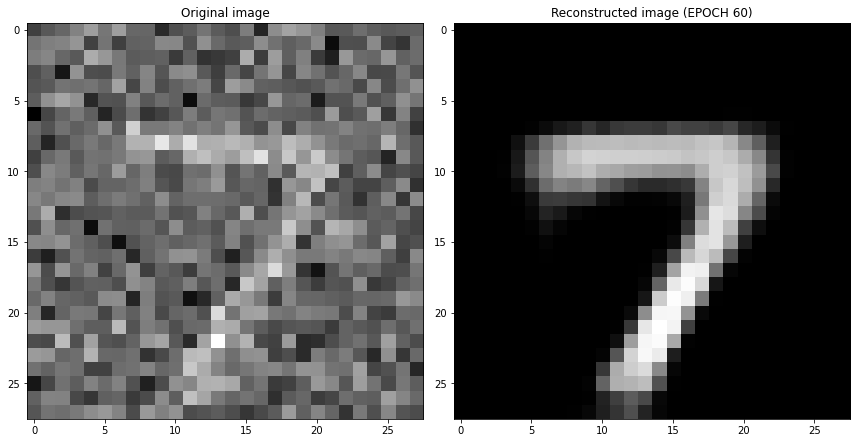

EPOCH 61/100
	 partial train loss (single batch): 0.202018
	 partial train loss (single batch): 0.203576
	 partial train loss (single batch): 0.203119
	 partial train loss (single batch): 0.200217
	 partial train loss (single batch): 0.200678
	 partial train loss (single batch): 0.199857
	 partial train loss (single batch): 0.200376
	 partial train loss (single batch): 0.201713
	 partial train loss (single batch): 0.202252
	 partial train loss (single batch): 0.203278
	 partial train loss (single batch): 0.202156
	 partial train loss (single batch): 0.201017
	 partial train loss (single batch): 0.201050
	 partial train loss (single batch): 0.202788
	 partial train loss (single batch): 0.201361
	 partial train loss (single batch): 0.205868
	 partial train loss (single batch): 0.199936
	 partial train loss (single batch): 0.200689
	 partial train loss (single batch): 0.202029
	 partial train loss (single batch): 0.202153
	 partial train loss (single batch): 0.202688
	 partial train loss 

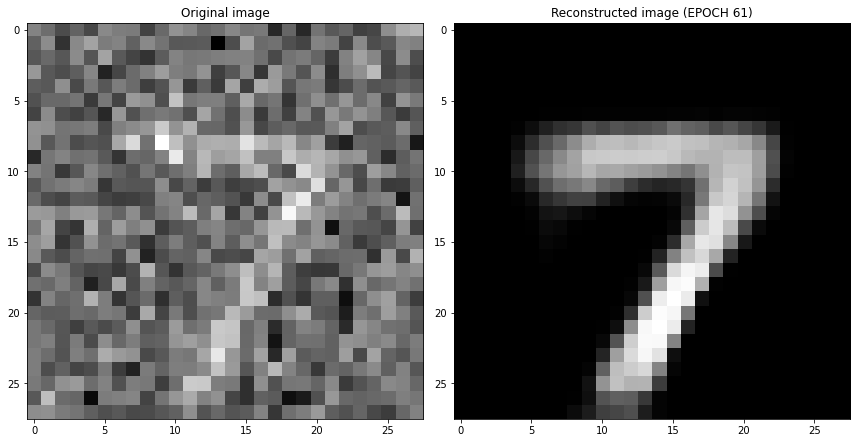

EPOCH 62/100
	 partial train loss (single batch): 0.201085
	 partial train loss (single batch): 0.199634
	 partial train loss (single batch): 0.202187
	 partial train loss (single batch): 0.202309
	 partial train loss (single batch): 0.201859
	 partial train loss (single batch): 0.202305
	 partial train loss (single batch): 0.200824
	 partial train loss (single batch): 0.199497
	 partial train loss (single batch): 0.202199
	 partial train loss (single batch): 0.201944
	 partial train loss (single batch): 0.202016
	 partial train loss (single batch): 0.201266
	 partial train loss (single batch): 0.201790
	 partial train loss (single batch): 0.202334
	 partial train loss (single batch): 0.203315
	 partial train loss (single batch): 0.202468
	 partial train loss (single batch): 0.201816
	 partial train loss (single batch): 0.201458
	 partial train loss (single batch): 0.202686
	 partial train loss (single batch): 0.200411
	 partial train loss (single batch): 0.201794
	 partial train loss 

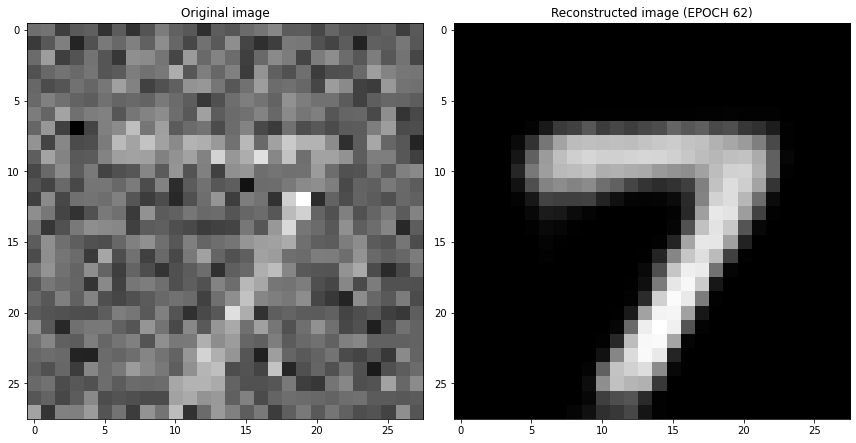

EPOCH 63/100
	 partial train loss (single batch): 0.203133
	 partial train loss (single batch): 0.203133
	 partial train loss (single batch): 0.200758
	 partial train loss (single batch): 0.201539
	 partial train loss (single batch): 0.201824
	 partial train loss (single batch): 0.202066
	 partial train loss (single batch): 0.202006
	 partial train loss (single batch): 0.203068
	 partial train loss (single batch): 0.202227
	 partial train loss (single batch): 0.201777
	 partial train loss (single batch): 0.201536
	 partial train loss (single batch): 0.203276
	 partial train loss (single batch): 0.204571
	 partial train loss (single batch): 0.199808
	 partial train loss (single batch): 0.200177
	 partial train loss (single batch): 0.202611
	 partial train loss (single batch): 0.204576
	 partial train loss (single batch): 0.203922
	 partial train loss (single batch): 0.204116
	 partial train loss (single batch): 0.203744
	 partial train loss (single batch): 0.203305
	 partial train loss 

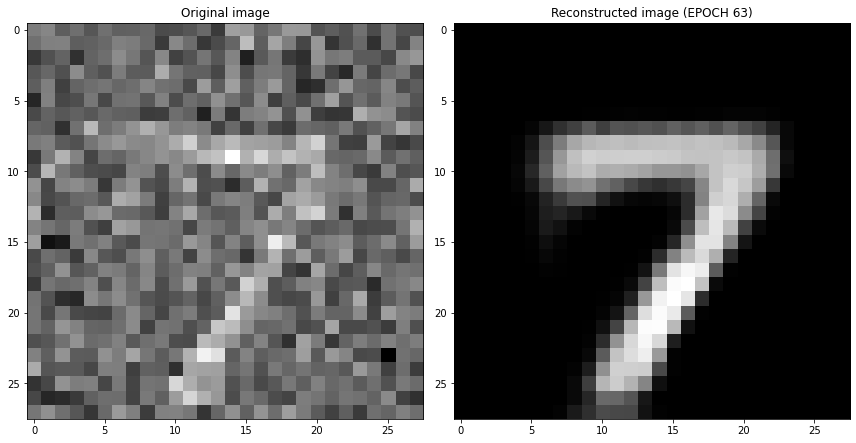

EPOCH 64/100
	 partial train loss (single batch): 0.202939
	 partial train loss (single batch): 0.202574
	 partial train loss (single batch): 0.202562
	 partial train loss (single batch): 0.204201
	 partial train loss (single batch): 0.202290
	 partial train loss (single batch): 0.202445
	 partial train loss (single batch): 0.201944
	 partial train loss (single batch): 0.202115
	 partial train loss (single batch): 0.203904
	 partial train loss (single batch): 0.201678
	 partial train loss (single batch): 0.200620
	 partial train loss (single batch): 0.200554
	 partial train loss (single batch): 0.201705
	 partial train loss (single batch): 0.203601
	 partial train loss (single batch): 0.202346
	 partial train loss (single batch): 0.201322
	 partial train loss (single batch): 0.203360
	 partial train loss (single batch): 0.200609
	 partial train loss (single batch): 0.203325
	 partial train loss (single batch): 0.201609
	 partial train loss (single batch): 0.205323
	 partial train loss 

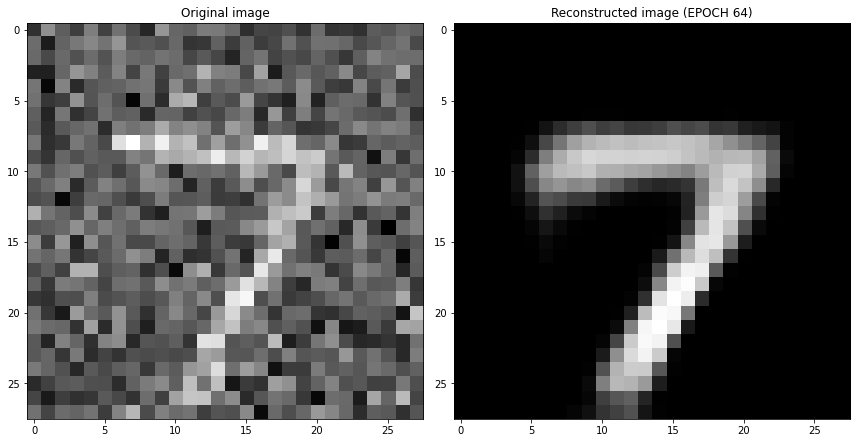

EPOCH 65/100
	 partial train loss (single batch): 0.202034
	 partial train loss (single batch): 0.202847
	 partial train loss (single batch): 0.201196
	 partial train loss (single batch): 0.203256
	 partial train loss (single batch): 0.201787
	 partial train loss (single batch): 0.201950
	 partial train loss (single batch): 0.203401
	 partial train loss (single batch): 0.202204
	 partial train loss (single batch): 0.203114
	 partial train loss (single batch): 0.203135
	 partial train loss (single batch): 0.200319
	 partial train loss (single batch): 0.199688
	 partial train loss (single batch): 0.202779
	 partial train loss (single batch): 0.200968
	 partial train loss (single batch): 0.203104
	 partial train loss (single batch): 0.202346
	 partial train loss (single batch): 0.202951
	 partial train loss (single batch): 0.203890
	 partial train loss (single batch): 0.204806
	 partial train loss (single batch): 0.204919
	 partial train loss (single batch): 0.202733
	 partial train loss 

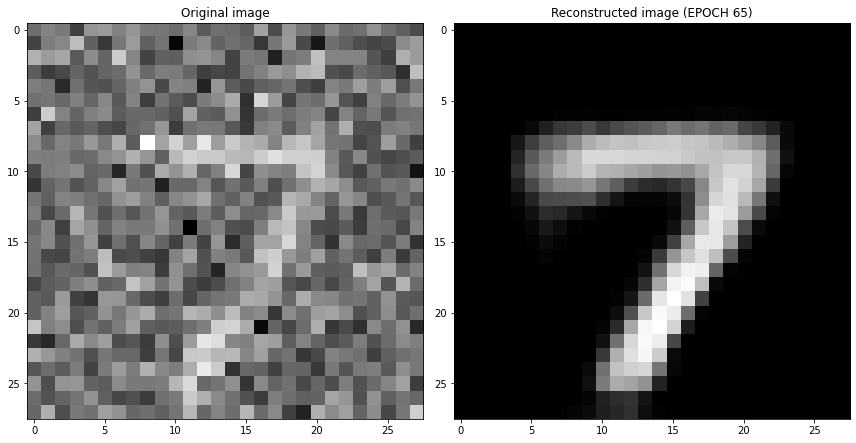

EPOCH 66/100
	 partial train loss (single batch): 0.202526
	 partial train loss (single batch): 0.203528
	 partial train loss (single batch): 0.201262
	 partial train loss (single batch): 0.202815
	 partial train loss (single batch): 0.203042
	 partial train loss (single batch): 0.202856
	 partial train loss (single batch): 0.205300
	 partial train loss (single batch): 0.201124
	 partial train loss (single batch): 0.203384
	 partial train loss (single batch): 0.203117
	 partial train loss (single batch): 0.201464
	 partial train loss (single batch): 0.203375
	 partial train loss (single batch): 0.204876
	 partial train loss (single batch): 0.203213
	 partial train loss (single batch): 0.204265
	 partial train loss (single batch): 0.201880
	 partial train loss (single batch): 0.203269
	 partial train loss (single batch): 0.200482
	 partial train loss (single batch): 0.204954
	 partial train loss (single batch): 0.202746
	 partial train loss (single batch): 0.202933
	 partial train loss 

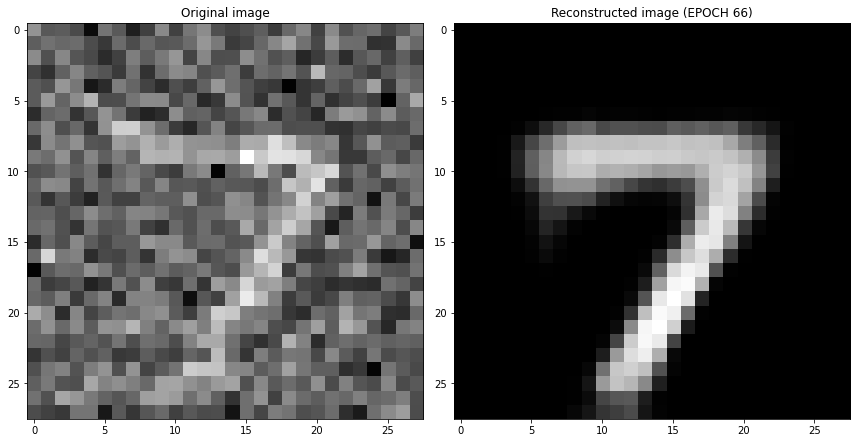

EPOCH 67/100
	 partial train loss (single batch): 0.201643
	 partial train loss (single batch): 0.203683
	 partial train loss (single batch): 0.202594
	 partial train loss (single batch): 0.201187
	 partial train loss (single batch): 0.204083
	 partial train loss (single batch): 0.204529
	 partial train loss (single batch): 0.202230
	 partial train loss (single batch): 0.202257
	 partial train loss (single batch): 0.202631
	 partial train loss (single batch): 0.202395
	 partial train loss (single batch): 0.202597
	 partial train loss (single batch): 0.203393
	 partial train loss (single batch): 0.202953
	 partial train loss (single batch): 0.204298
	 partial train loss (single batch): 0.201344
	 partial train loss (single batch): 0.201560
	 partial train loss (single batch): 0.203819
	 partial train loss (single batch): 0.200045
	 partial train loss (single batch): 0.202497
	 partial train loss (single batch): 0.203619
	 partial train loss (single batch): 0.202075
	 partial train loss 

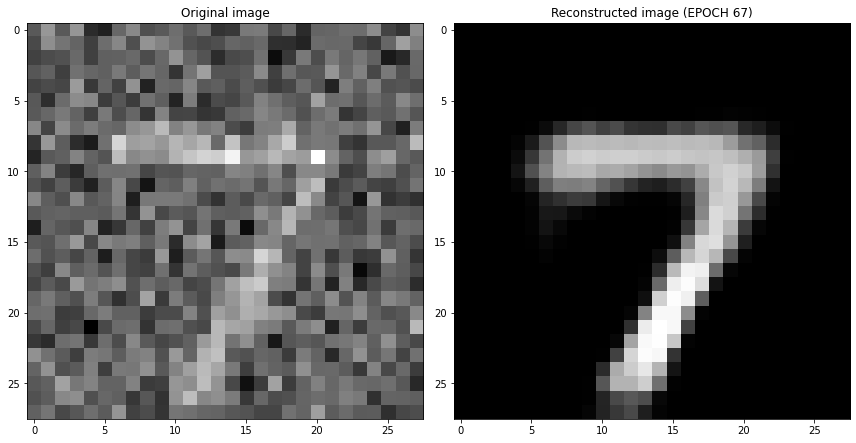

EPOCH 68/100
	 partial train loss (single batch): 0.200283
	 partial train loss (single batch): 0.201670
	 partial train loss (single batch): 0.202775
	 partial train loss (single batch): 0.204306
	 partial train loss (single batch): 0.202696
	 partial train loss (single batch): 0.203280
	 partial train loss (single batch): 0.201228
	 partial train loss (single batch): 0.202862
	 partial train loss (single batch): 0.203145
	 partial train loss (single batch): 0.201043
	 partial train loss (single batch): 0.200812
	 partial train loss (single batch): 0.202028
	 partial train loss (single batch): 0.202671
	 partial train loss (single batch): 0.203140
	 partial train loss (single batch): 0.200090
	 partial train loss (single batch): 0.201710
	 partial train loss (single batch): 0.201364
	 partial train loss (single batch): 0.200726
	 partial train loss (single batch): 0.202577
	 partial train loss (single batch): 0.202780
	 partial train loss (single batch): 0.202265
	 partial train loss 

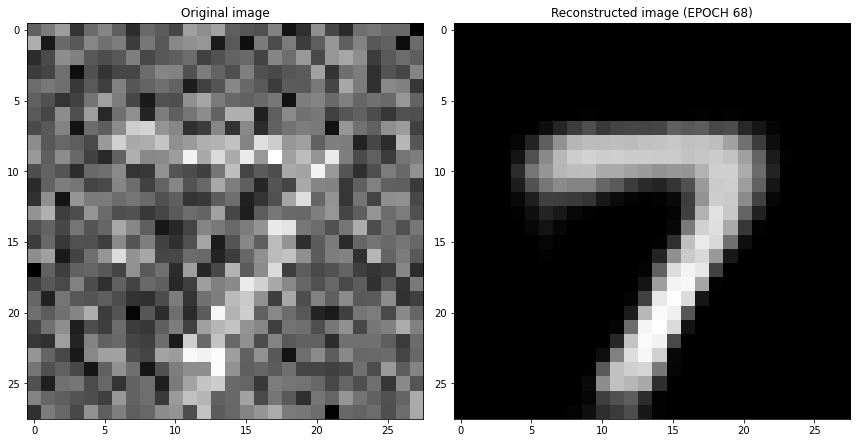

EPOCH 69/100
	 partial train loss (single batch): 0.202086
	 partial train loss (single batch): 0.201497
	 partial train loss (single batch): 0.202005
	 partial train loss (single batch): 0.201255
	 partial train loss (single batch): 0.202687
	 partial train loss (single batch): 0.201961
	 partial train loss (single batch): 0.202859
	 partial train loss (single batch): 0.202281
	 partial train loss (single batch): 0.200324
	 partial train loss (single batch): 0.201005
	 partial train loss (single batch): 0.202294
	 partial train loss (single batch): 0.201693
	 partial train loss (single batch): 0.203345
	 partial train loss (single batch): 0.201152
	 partial train loss (single batch): 0.201460
	 partial train loss (single batch): 0.202381
	 partial train loss (single batch): 0.203047
	 partial train loss (single batch): 0.201704
	 partial train loss (single batch): 0.200679
	 partial train loss (single batch): 0.202997
	 partial train loss (single batch): 0.201718
	 partial train loss 

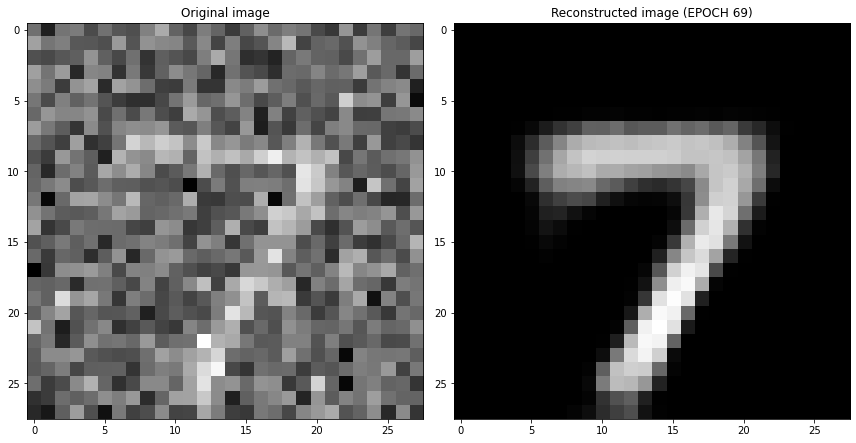

EPOCH 70/100
	 partial train loss (single batch): 0.201039
	 partial train loss (single batch): 0.199249
	 partial train loss (single batch): 0.203329
	 partial train loss (single batch): 0.200762
	 partial train loss (single batch): 0.200821
	 partial train loss (single batch): 0.200930
	 partial train loss (single batch): 0.201561
	 partial train loss (single batch): 0.201974
	 partial train loss (single batch): 0.202179
	 partial train loss (single batch): 0.200932
	 partial train loss (single batch): 0.200437
	 partial train loss (single batch): 0.201918
	 partial train loss (single batch): 0.205088
	 partial train loss (single batch): 0.200213
	 partial train loss (single batch): 0.202951
	 partial train loss (single batch): 0.203827
	 partial train loss (single batch): 0.201502
	 partial train loss (single batch): 0.203590
	 partial train loss (single batch): 0.203951
	 partial train loss (single batch): 0.202160
	 partial train loss (single batch): 0.204370
	 partial train loss 

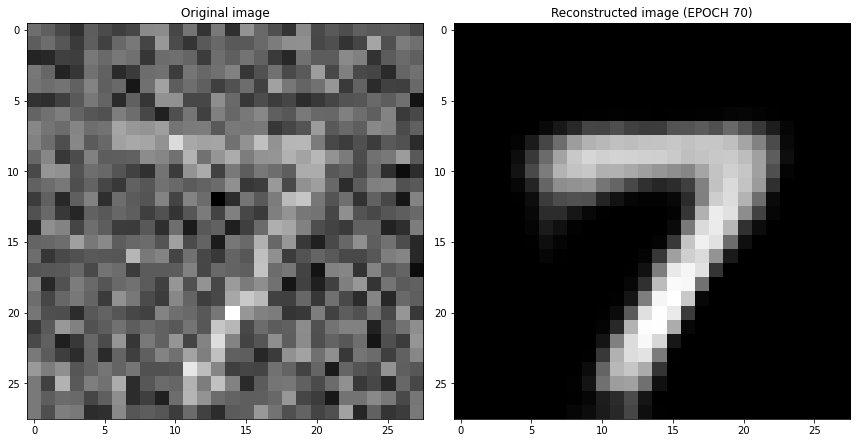

EPOCH 71/100
	 partial train loss (single batch): 0.201368
	 partial train loss (single batch): 0.201884
	 partial train loss (single batch): 0.202999
	 partial train loss (single batch): 0.205497
	 partial train loss (single batch): 0.202317
	 partial train loss (single batch): 0.202875
	 partial train loss (single batch): 0.201380
	 partial train loss (single batch): 0.201502
	 partial train loss (single batch): 0.203056
	 partial train loss (single batch): 0.204066
	 partial train loss (single batch): 0.202764
	 partial train loss (single batch): 0.201252
	 partial train loss (single batch): 0.202285
	 partial train loss (single batch): 0.202230
	 partial train loss (single batch): 0.202589
	 partial train loss (single batch): 0.203967
	 partial train loss (single batch): 0.200938
	 partial train loss (single batch): 0.201312
	 partial train loss (single batch): 0.202658
	 partial train loss (single batch): 0.202699
	 partial train loss (single batch): 0.202420
	 partial train loss 

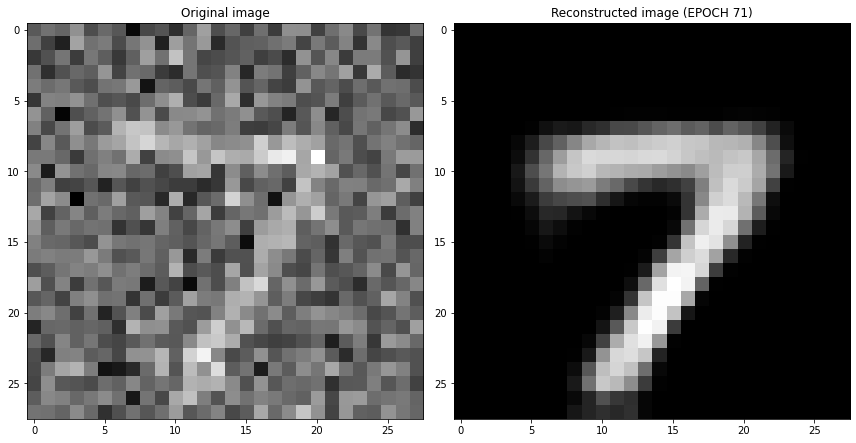

EPOCH 72/100
	 partial train loss (single batch): 0.202875
	 partial train loss (single batch): 0.202413
	 partial train loss (single batch): 0.202134
	 partial train loss (single batch): 0.202456
	 partial train loss (single batch): 0.203432
	 partial train loss (single batch): 0.202690
	 partial train loss (single batch): 0.202620
	 partial train loss (single batch): 0.203676
	 partial train loss (single batch): 0.202681
	 partial train loss (single batch): 0.203130
	 partial train loss (single batch): 0.200343
	 partial train loss (single batch): 0.203306
	 partial train loss (single batch): 0.204561
	 partial train loss (single batch): 0.201661
	 partial train loss (single batch): 0.199467
	 partial train loss (single batch): 0.202633
	 partial train loss (single batch): 0.203955
	 partial train loss (single batch): 0.205001
	 partial train loss (single batch): 0.202671
	 partial train loss (single batch): 0.201935
	 partial train loss (single batch): 0.201025
	 partial train loss 

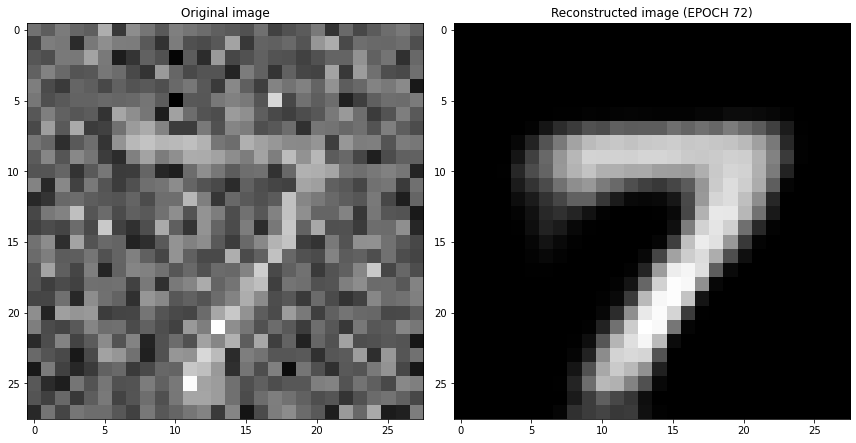

EPOCH 73/100
	 partial train loss (single batch): 0.202066
	 partial train loss (single batch): 0.200815
	 partial train loss (single batch): 0.201467
	 partial train loss (single batch): 0.202910
	 partial train loss (single batch): 0.202025
	 partial train loss (single batch): 0.203344
	 partial train loss (single batch): 0.201469
	 partial train loss (single batch): 0.201444
	 partial train loss (single batch): 0.204106
	 partial train loss (single batch): 0.202723
	 partial train loss (single batch): 0.200966
	 partial train loss (single batch): 0.203159
	 partial train loss (single batch): 0.200729
	 partial train loss (single batch): 0.203731
	 partial train loss (single batch): 0.201763
	 partial train loss (single batch): 0.203764
	 partial train loss (single batch): 0.204052
	 partial train loss (single batch): 0.202487
	 partial train loss (single batch): 0.202372
	 partial train loss (single batch): 0.200524
	 partial train loss (single batch): 0.203074
	 partial train loss 

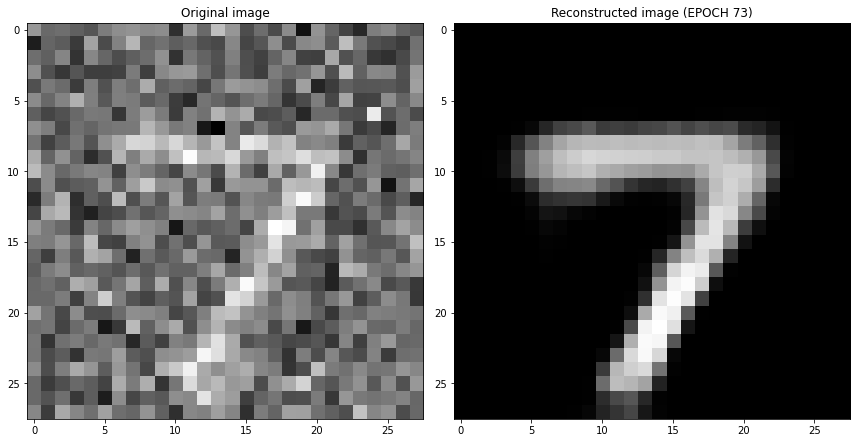

EPOCH 74/100
	 partial train loss (single batch): 0.200868
	 partial train loss (single batch): 0.198987
	 partial train loss (single batch): 0.202872
	 partial train loss (single batch): 0.202982
	 partial train loss (single batch): 0.204531
	 partial train loss (single batch): 0.199946
	 partial train loss (single batch): 0.200600
	 partial train loss (single batch): 0.201633
	 partial train loss (single batch): 0.199532
	 partial train loss (single batch): 0.201811
	 partial train loss (single batch): 0.204823
	 partial train loss (single batch): 0.203267
	 partial train loss (single batch): 0.201161
	 partial train loss (single batch): 0.202844
	 partial train loss (single batch): 0.201468
	 partial train loss (single batch): 0.202017
	 partial train loss (single batch): 0.200818
	 partial train loss (single batch): 0.202063
	 partial train loss (single batch): 0.202080
	 partial train loss (single batch): 0.201458
	 partial train loss (single batch): 0.202900
	 partial train loss 

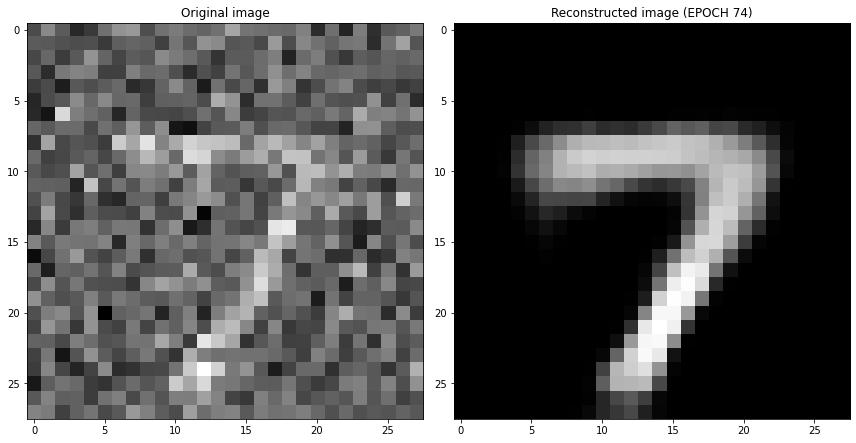

EPOCH 75/100
	 partial train loss (single batch): 0.201047
	 partial train loss (single batch): 0.200565
	 partial train loss (single batch): 0.200782
	 partial train loss (single batch): 0.203391
	 partial train loss (single batch): 0.202569
	 partial train loss (single batch): 0.203388
	 partial train loss (single batch): 0.202103
	 partial train loss (single batch): 0.201908
	 partial train loss (single batch): 0.201693
	 partial train loss (single batch): 0.203008
	 partial train loss (single batch): 0.202102
	 partial train loss (single batch): 0.199348
	 partial train loss (single batch): 0.204009
	 partial train loss (single batch): 0.202641
	 partial train loss (single batch): 0.202200
	 partial train loss (single batch): 0.202754
	 partial train loss (single batch): 0.201502
	 partial train loss (single batch): 0.201696
	 partial train loss (single batch): 0.202717
	 partial train loss (single batch): 0.201170
	 partial train loss (single batch): 0.201855
	 partial train loss 

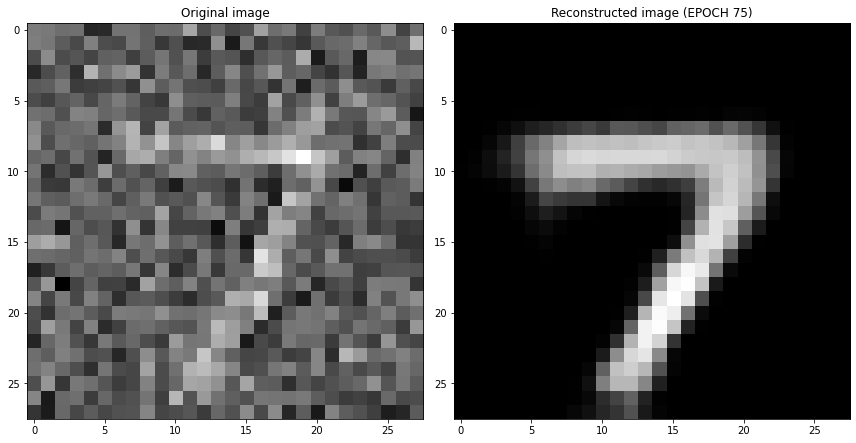

EPOCH 76/100
	 partial train loss (single batch): 0.202269
	 partial train loss (single batch): 0.202685
	 partial train loss (single batch): 0.201177
	 partial train loss (single batch): 0.204159
	 partial train loss (single batch): 0.204612
	 partial train loss (single batch): 0.202420
	 partial train loss (single batch): 0.201463
	 partial train loss (single batch): 0.202854
	 partial train loss (single batch): 0.204586
	 partial train loss (single batch): 0.203207
	 partial train loss (single batch): 0.203500
	 partial train loss (single batch): 0.201523
	 partial train loss (single batch): 0.201826
	 partial train loss (single batch): 0.202697
	 partial train loss (single batch): 0.203073
	 partial train loss (single batch): 0.201936
	 partial train loss (single batch): 0.202661
	 partial train loss (single batch): 0.201257
	 partial train loss (single batch): 0.202379
	 partial train loss (single batch): 0.201925
	 partial train loss (single batch): 0.201154
	 partial train loss 

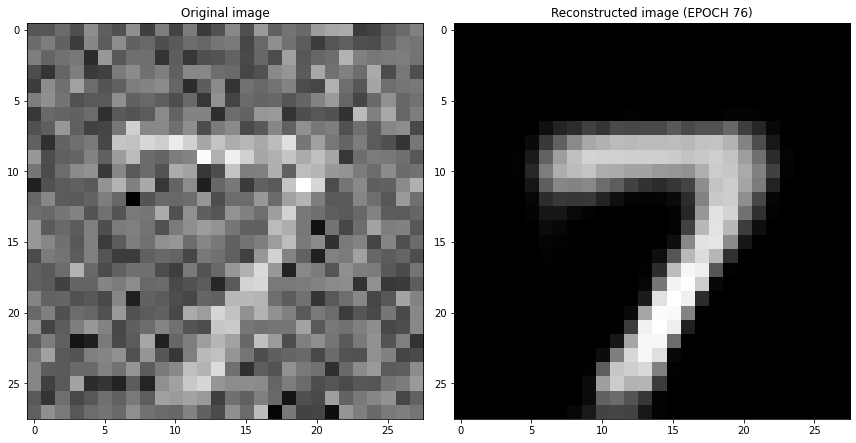

EPOCH 77/100
	 partial train loss (single batch): 0.202421
	 partial train loss (single batch): 0.200058
	 partial train loss (single batch): 0.200884
	 partial train loss (single batch): 0.201407
	 partial train loss (single batch): 0.201477
	 partial train loss (single batch): 0.202105
	 partial train loss (single batch): 0.201316
	 partial train loss (single batch): 0.202992
	 partial train loss (single batch): 0.203010
	 partial train loss (single batch): 0.201525
	 partial train loss (single batch): 0.202103
	 partial train loss (single batch): 0.201565
	 partial train loss (single batch): 0.203771
	 partial train loss (single batch): 0.202271
	 partial train loss (single batch): 0.202273
	 partial train loss (single batch): 0.202524
	 partial train loss (single batch): 0.202116
	 partial train loss (single batch): 0.201429
	 partial train loss (single batch): 0.202573
	 partial train loss (single batch): 0.201267
	 partial train loss (single batch): 0.202628
	 partial train loss 

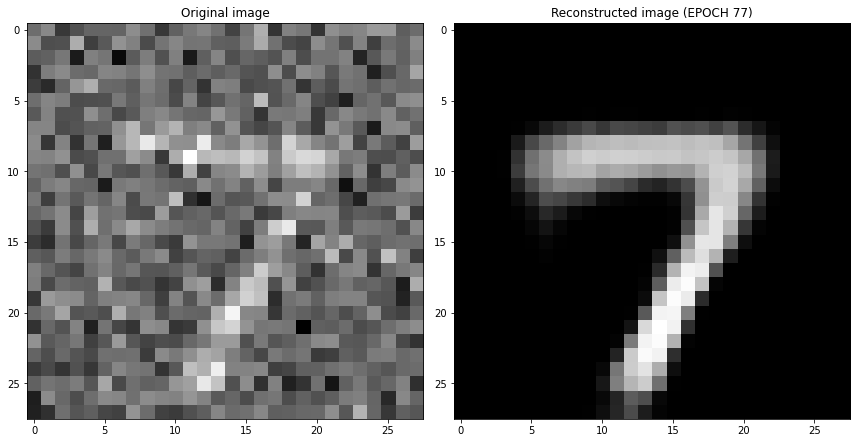

EPOCH 78/100
	 partial train loss (single batch): 0.203407
	 partial train loss (single batch): 0.202639
	 partial train loss (single batch): 0.201833
	 partial train loss (single batch): 0.202961
	 partial train loss (single batch): 0.203723
	 partial train loss (single batch): 0.200007
	 partial train loss (single batch): 0.202485
	 partial train loss (single batch): 0.199848
	 partial train loss (single batch): 0.205757
	 partial train loss (single batch): 0.203240
	 partial train loss (single batch): 0.200564
	 partial train loss (single batch): 0.202837
	 partial train loss (single batch): 0.202227
	 partial train loss (single batch): 0.201158
	 partial train loss (single batch): 0.200911
	 partial train loss (single batch): 0.202605
	 partial train loss (single batch): 0.203132
	 partial train loss (single batch): 0.203183
	 partial train loss (single batch): 0.199425
	 partial train loss (single batch): 0.202847
	 partial train loss (single batch): 0.203740
	 partial train loss 

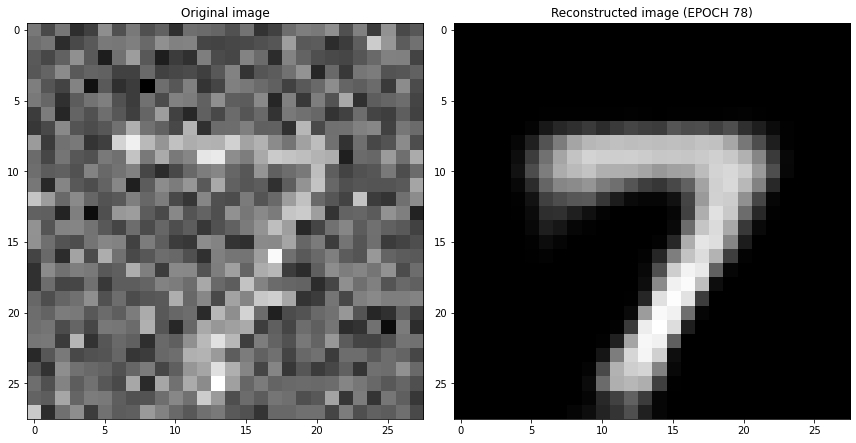

EPOCH 79/100
	 partial train loss (single batch): 0.201279
	 partial train loss (single batch): 0.203927
	 partial train loss (single batch): 0.203901
	 partial train loss (single batch): 0.202655
	 partial train loss (single batch): 0.200765
	 partial train loss (single batch): 0.202086
	 partial train loss (single batch): 0.202042
	 partial train loss (single batch): 0.203342
	 partial train loss (single batch): 0.201791
	 partial train loss (single batch): 0.203684
	 partial train loss (single batch): 0.200095
	 partial train loss (single batch): 0.202417
	 partial train loss (single batch): 0.203650
	 partial train loss (single batch): 0.203901
	 partial train loss (single batch): 0.200875
	 partial train loss (single batch): 0.202432
	 partial train loss (single batch): 0.201622
	 partial train loss (single batch): 0.202725
	 partial train loss (single batch): 0.200494
	 partial train loss (single batch): 0.202541
	 partial train loss (single batch): 0.201664
	 partial train loss 

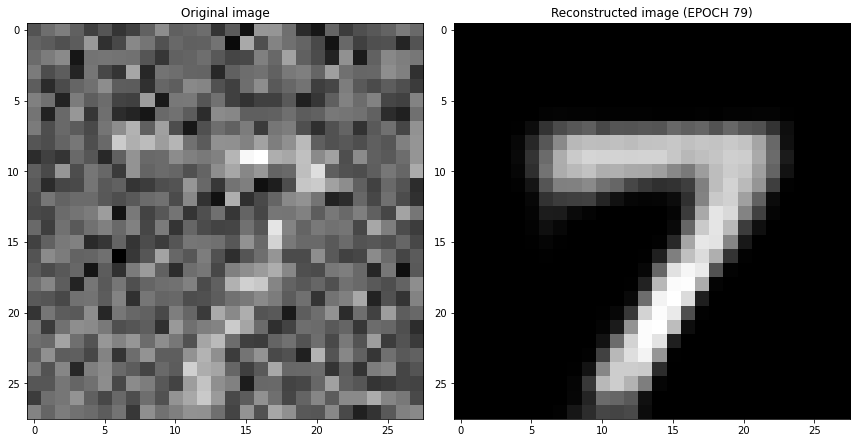

EPOCH 80/100
	 partial train loss (single batch): 0.200990
	 partial train loss (single batch): 0.204488
	 partial train loss (single batch): 0.201391
	 partial train loss (single batch): 0.202251
	 partial train loss (single batch): 0.200210
	 partial train loss (single batch): 0.200767
	 partial train loss (single batch): 0.203930
	 partial train loss (single batch): 0.202866
	 partial train loss (single batch): 0.202139
	 partial train loss (single batch): 0.203614
	 partial train loss (single batch): 0.203614
	 partial train loss (single batch): 0.201722
	 partial train loss (single batch): 0.203861
	 partial train loss (single batch): 0.202981
	 partial train loss (single batch): 0.201306
	 partial train loss (single batch): 0.205276
	 partial train loss (single batch): 0.203338
	 partial train loss (single batch): 0.201748
	 partial train loss (single batch): 0.201555
	 partial train loss (single batch): 0.201348
	 partial train loss (single batch): 0.202311
	 partial train loss 

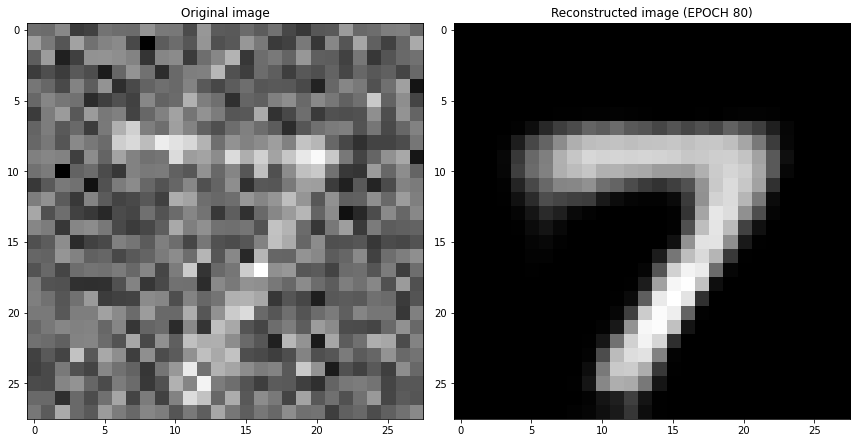

EPOCH 81/100
	 partial train loss (single batch): 0.200098
	 partial train loss (single batch): 0.201282
	 partial train loss (single batch): 0.202340
	 partial train loss (single batch): 0.200598
	 partial train loss (single batch): 0.202875
	 partial train loss (single batch): 0.201383
	 partial train loss (single batch): 0.202334
	 partial train loss (single batch): 0.205593
	 partial train loss (single batch): 0.203222
	 partial train loss (single batch): 0.202611
	 partial train loss (single batch): 0.200913
	 partial train loss (single batch): 0.203027
	 partial train loss (single batch): 0.203969
	 partial train loss (single batch): 0.200130
	 partial train loss (single batch): 0.202727
	 partial train loss (single batch): 0.204286
	 partial train loss (single batch): 0.202285
	 partial train loss (single batch): 0.202731
	 partial train loss (single batch): 0.202852
	 partial train loss (single batch): 0.201904
	 partial train loss (single batch): 0.200313
	 partial train loss 

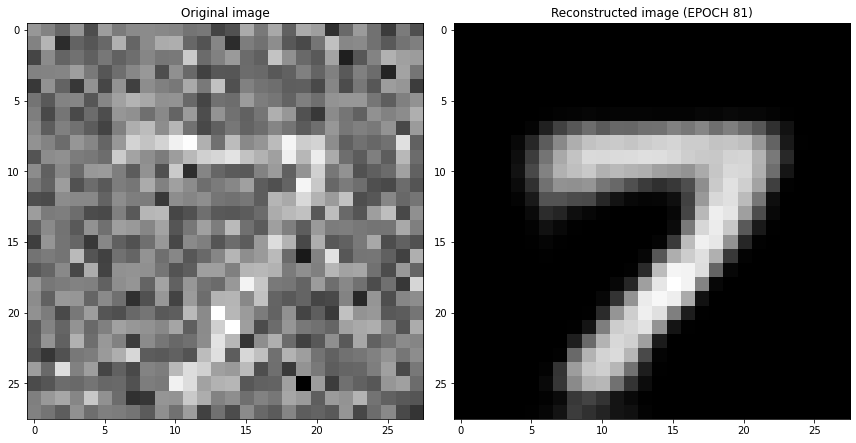

EPOCH 82/100
	 partial train loss (single batch): 0.203035
	 partial train loss (single batch): 0.203388
	 partial train loss (single batch): 0.204964
	 partial train loss (single batch): 0.203183
	 partial train loss (single batch): 0.202225
	 partial train loss (single batch): 0.198965
	 partial train loss (single batch): 0.199969
	 partial train loss (single batch): 0.203839
	 partial train loss (single batch): 0.203702
	 partial train loss (single batch): 0.201499
	 partial train loss (single batch): 0.202889
	 partial train loss (single batch): 0.202249
	 partial train loss (single batch): 0.201099
	 partial train loss (single batch): 0.204681
	 partial train loss (single batch): 0.202085
	 partial train loss (single batch): 0.202476
	 partial train loss (single batch): 0.200096
	 partial train loss (single batch): 0.200669
	 partial train loss (single batch): 0.200865
	 partial train loss (single batch): 0.202463
	 partial train loss (single batch): 0.201243
	 partial train loss 

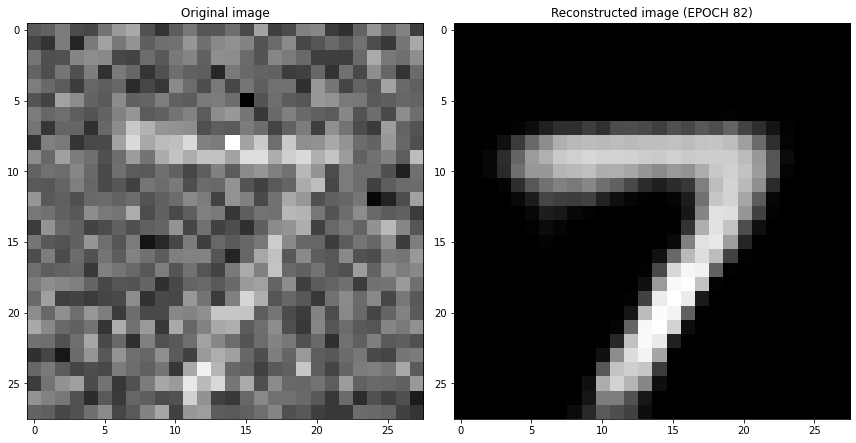

EPOCH 83/100
	 partial train loss (single batch): 0.200792
	 partial train loss (single batch): 0.202102
	 partial train loss (single batch): 0.201916
	 partial train loss (single batch): 0.202224
	 partial train loss (single batch): 0.202123
	 partial train loss (single batch): 0.202664
	 partial train loss (single batch): 0.203192
	 partial train loss (single batch): 0.204140
	 partial train loss (single batch): 0.202570
	 partial train loss (single batch): 0.201822
	 partial train loss (single batch): 0.202225
	 partial train loss (single batch): 0.201619
	 partial train loss (single batch): 0.203540
	 partial train loss (single batch): 0.200694
	 partial train loss (single batch): 0.200084
	 partial train loss (single batch): 0.200970
	 partial train loss (single batch): 0.202889
	 partial train loss (single batch): 0.204178
	 partial train loss (single batch): 0.204397
	 partial train loss (single batch): 0.201586
	 partial train loss (single batch): 0.203061
	 partial train loss 

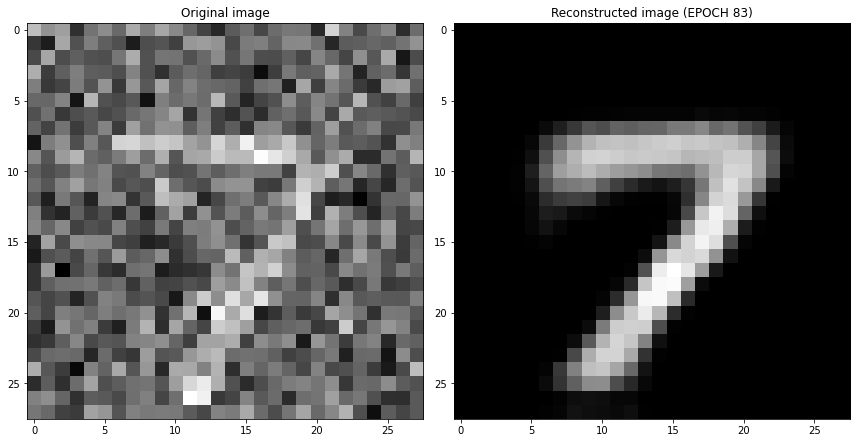

EPOCH 84/100
	 partial train loss (single batch): 0.200415
	 partial train loss (single batch): 0.202023
	 partial train loss (single batch): 0.201375
	 partial train loss (single batch): 0.203624
	 partial train loss (single batch): 0.201002
	 partial train loss (single batch): 0.201640
	 partial train loss (single batch): 0.202103
	 partial train loss (single batch): 0.202134
	 partial train loss (single batch): 0.202414
	 partial train loss (single batch): 0.200644
	 partial train loss (single batch): 0.204118
	 partial train loss (single batch): 0.199635
	 partial train loss (single batch): 0.201214
	 partial train loss (single batch): 0.199752
	 partial train loss (single batch): 0.201179
	 partial train loss (single batch): 0.201165
	 partial train loss (single batch): 0.203594
	 partial train loss (single batch): 0.202357
	 partial train loss (single batch): 0.204509
	 partial train loss (single batch): 0.201554
	 partial train loss (single batch): 0.201782
	 partial train loss 

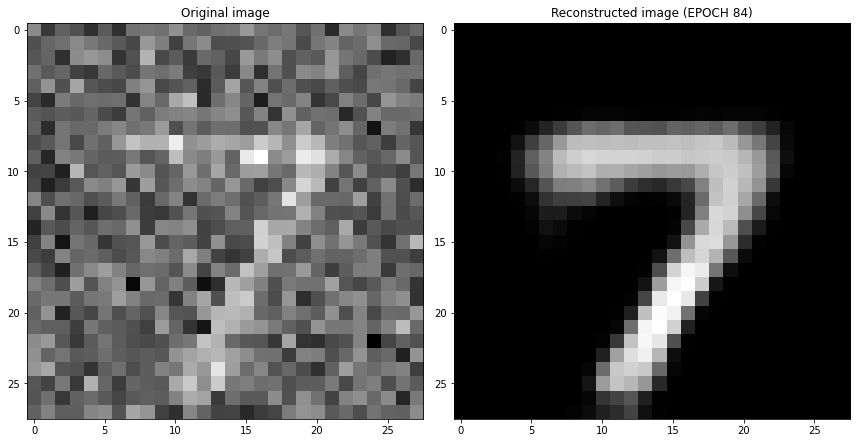

EPOCH 85/100
	 partial train loss (single batch): 0.200859
	 partial train loss (single batch): 0.201683
	 partial train loss (single batch): 0.202430
	 partial train loss (single batch): 0.201397
	 partial train loss (single batch): 0.204114
	 partial train loss (single batch): 0.201635
	 partial train loss (single batch): 0.205402
	 partial train loss (single batch): 0.204947
	 partial train loss (single batch): 0.202266
	 partial train loss (single batch): 0.203923
	 partial train loss (single batch): 0.202864
	 partial train loss (single batch): 0.202621
	 partial train loss (single batch): 0.203820
	 partial train loss (single batch): 0.202498
	 partial train loss (single batch): 0.202958
	 partial train loss (single batch): 0.200037
	 partial train loss (single batch): 0.201425
	 partial train loss (single batch): 0.202660
	 partial train loss (single batch): 0.201122
	 partial train loss (single batch): 0.201674
	 partial train loss (single batch): 0.203999
	 partial train loss 

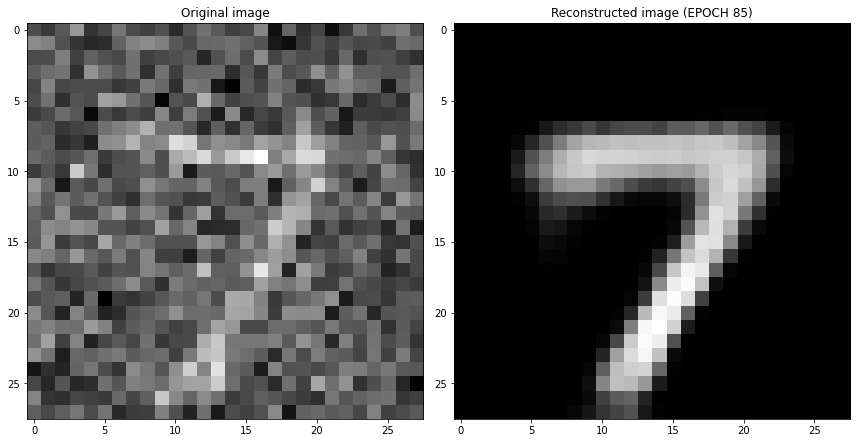

EPOCH 86/100
	 partial train loss (single batch): 0.202439
	 partial train loss (single batch): 0.201743
	 partial train loss (single batch): 0.200517
	 partial train loss (single batch): 0.203155
	 partial train loss (single batch): 0.202790
	 partial train loss (single batch): 0.201837
	 partial train loss (single batch): 0.202032
	 partial train loss (single batch): 0.200970
	 partial train loss (single batch): 0.203440
	 partial train loss (single batch): 0.203440
	 partial train loss (single batch): 0.202884
	 partial train loss (single batch): 0.201527
	 partial train loss (single batch): 0.202676
	 partial train loss (single batch): 0.202710
	 partial train loss (single batch): 0.201854
	 partial train loss (single batch): 0.203876
	 partial train loss (single batch): 0.201203
	 partial train loss (single batch): 0.201944
	 partial train loss (single batch): 0.203116
	 partial train loss (single batch): 0.204149
	 partial train loss (single batch): 0.203690
	 partial train loss 

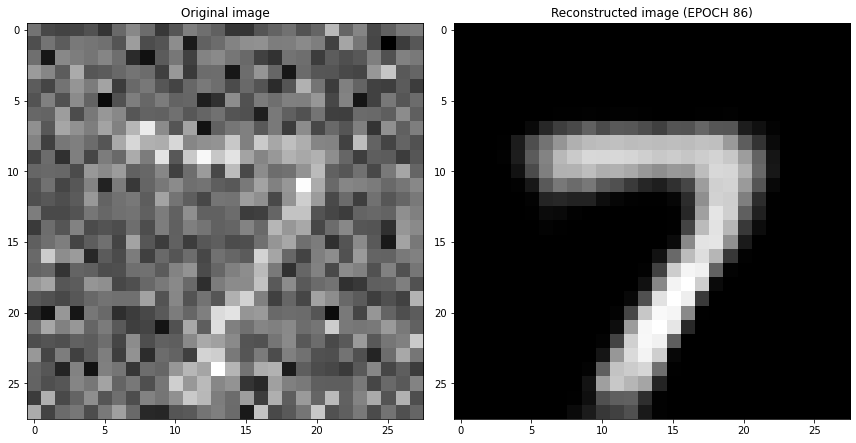

EPOCH 87/100
	 partial train loss (single batch): 0.203099
	 partial train loss (single batch): 0.202803
	 partial train loss (single batch): 0.199718
	 partial train loss (single batch): 0.203498
	 partial train loss (single batch): 0.202804
	 partial train loss (single batch): 0.204343
	 partial train loss (single batch): 0.201227
	 partial train loss (single batch): 0.203483
	 partial train loss (single batch): 0.202617
	 partial train loss (single batch): 0.203457
	 partial train loss (single batch): 0.203405
	 partial train loss (single batch): 0.202378
	 partial train loss (single batch): 0.202647
	 partial train loss (single batch): 0.200188
	 partial train loss (single batch): 0.205320
	 partial train loss (single batch): 0.203057
	 partial train loss (single batch): 0.203473
	 partial train loss (single batch): 0.203309
	 partial train loss (single batch): 0.200928
	 partial train loss (single batch): 0.204624
	 partial train loss (single batch): 0.201292
	 partial train loss 

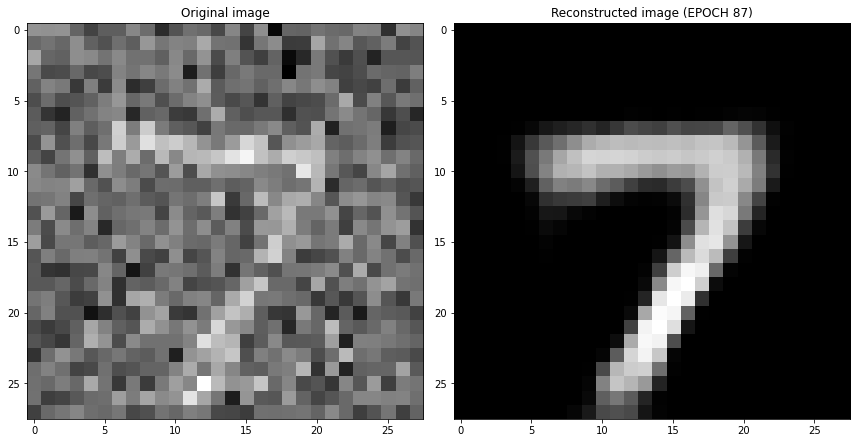

EPOCH 88/100
	 partial train loss (single batch): 0.201616
	 partial train loss (single batch): 0.202488
	 partial train loss (single batch): 0.200288
	 partial train loss (single batch): 0.201757
	 partial train loss (single batch): 0.202427
	 partial train loss (single batch): 0.201608
	 partial train loss (single batch): 0.201086
	 partial train loss (single batch): 0.200783
	 partial train loss (single batch): 0.200761
	 partial train loss (single batch): 0.202577
	 partial train loss (single batch): 0.200833
	 partial train loss (single batch): 0.202337
	 partial train loss (single batch): 0.202556
	 partial train loss (single batch): 0.202093
	 partial train loss (single batch): 0.202220
	 partial train loss (single batch): 0.200282
	 partial train loss (single batch): 0.202727
	 partial train loss (single batch): 0.204422
	 partial train loss (single batch): 0.204048
	 partial train loss (single batch): 0.204197
	 partial train loss (single batch): 0.203767
	 partial train loss 

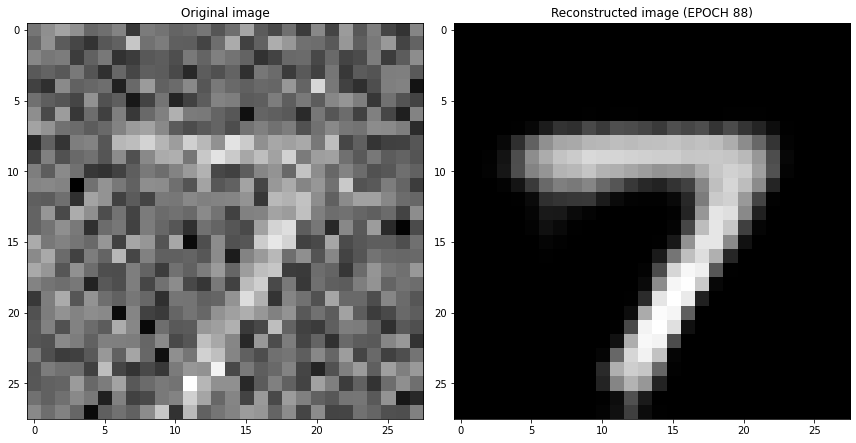

EPOCH 89/100
	 partial train loss (single batch): 0.202857
	 partial train loss (single batch): 0.201377
	 partial train loss (single batch): 0.204530
	 partial train loss (single batch): 0.202293
	 partial train loss (single batch): 0.199972
	 partial train loss (single batch): 0.204001
	 partial train loss (single batch): 0.201408
	 partial train loss (single batch): 0.201385
	 partial train loss (single batch): 0.201805
	 partial train loss (single batch): 0.202772
	 partial train loss (single batch): 0.202996
	 partial train loss (single batch): 0.200019
	 partial train loss (single batch): 0.200918
	 partial train loss (single batch): 0.202095
	 partial train loss (single batch): 0.203423
	 partial train loss (single batch): 0.203633
	 partial train loss (single batch): 0.203200
	 partial train loss (single batch): 0.201281
	 partial train loss (single batch): 0.202852
	 partial train loss (single batch): 0.204269
	 partial train loss (single batch): 0.201930
	 partial train loss 

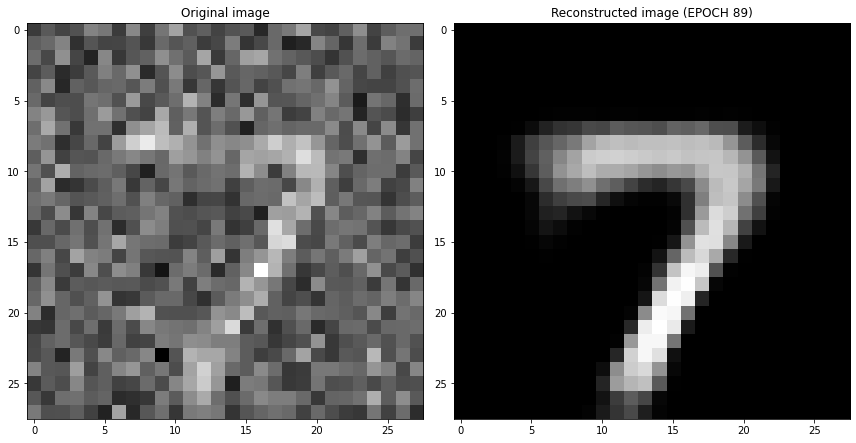

EPOCH 90/100
	 partial train loss (single batch): 0.202238
	 partial train loss (single batch): 0.202876
	 partial train loss (single batch): 0.201858
	 partial train loss (single batch): 0.201782
	 partial train loss (single batch): 0.203364
	 partial train loss (single batch): 0.201338
	 partial train loss (single batch): 0.201773
	 partial train loss (single batch): 0.201148
	 partial train loss (single batch): 0.202736
	 partial train loss (single batch): 0.202453
	 partial train loss (single batch): 0.201539
	 partial train loss (single batch): 0.205107
	 partial train loss (single batch): 0.203030
	 partial train loss (single batch): 0.203290
	 partial train loss (single batch): 0.202465
	 partial train loss (single batch): 0.202691
	 partial train loss (single batch): 0.203318
	 partial train loss (single batch): 0.200332
	 partial train loss (single batch): 0.199996
	 partial train loss (single batch): 0.202172
	 partial train loss (single batch): 0.203023
	 partial train loss 

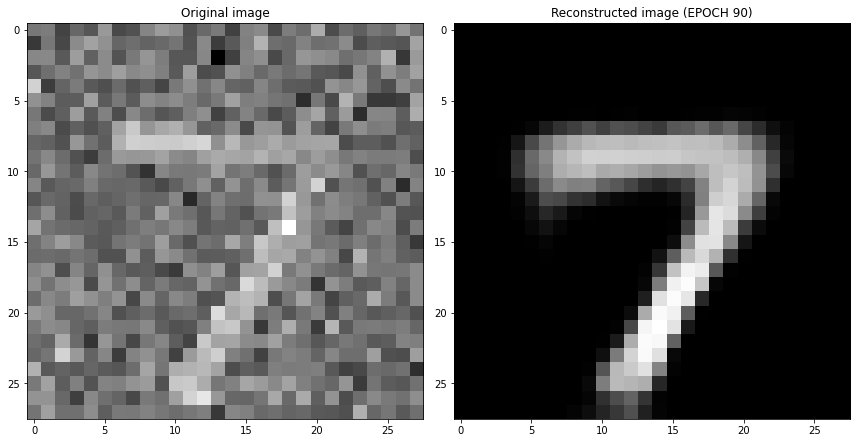

EPOCH 91/100
	 partial train loss (single batch): 0.202777
	 partial train loss (single batch): 0.205867
	 partial train loss (single batch): 0.199953
	 partial train loss (single batch): 0.201346
	 partial train loss (single batch): 0.202283
	 partial train loss (single batch): 0.203137
	 partial train loss (single batch): 0.201562
	 partial train loss (single batch): 0.203885
	 partial train loss (single batch): 0.202830
	 partial train loss (single batch): 0.206559
	 partial train loss (single batch): 0.203190
	 partial train loss (single batch): 0.197932
	 partial train loss (single batch): 0.201688
	 partial train loss (single batch): 0.201727
	 partial train loss (single batch): 0.201811
	 partial train loss (single batch): 0.201845
	 partial train loss (single batch): 0.203127
	 partial train loss (single batch): 0.199285
	 partial train loss (single batch): 0.201731
	 partial train loss (single batch): 0.200646
	 partial train loss (single batch): 0.203719
	 partial train loss 

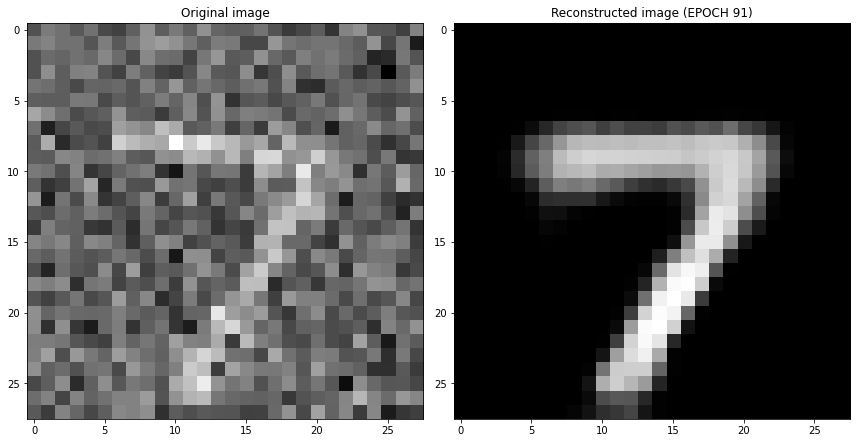

EPOCH 92/100
	 partial train loss (single batch): 0.199941
	 partial train loss (single batch): 0.202906
	 partial train loss (single batch): 0.201724
	 partial train loss (single batch): 0.200626
	 partial train loss (single batch): 0.199492
	 partial train loss (single batch): 0.204752
	 partial train loss (single batch): 0.201227
	 partial train loss (single batch): 0.201349
	 partial train loss (single batch): 0.201455
	 partial train loss (single batch): 0.200806
	 partial train loss (single batch): 0.204183
	 partial train loss (single batch): 0.200143
	 partial train loss (single batch): 0.202271
	 partial train loss (single batch): 0.199334
	 partial train loss (single batch): 0.202722
	 partial train loss (single batch): 0.203263
	 partial train loss (single batch): 0.204627
	 partial train loss (single batch): 0.203544
	 partial train loss (single batch): 0.202358
	 partial train loss (single batch): 0.201269
	 partial train loss (single batch): 0.202083
	 partial train loss 

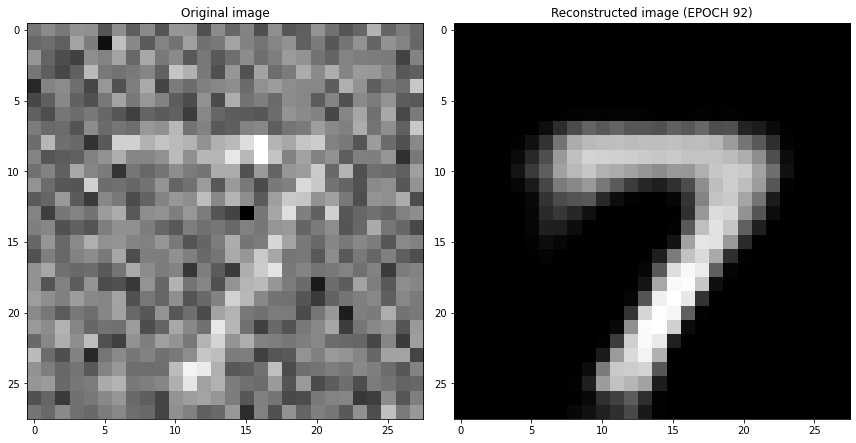

EPOCH 93/100
	 partial train loss (single batch): 0.200243
	 partial train loss (single batch): 0.199681
	 partial train loss (single batch): 0.202727
	 partial train loss (single batch): 0.202793
	 partial train loss (single batch): 0.203043
	 partial train loss (single batch): 0.201203
	 partial train loss (single batch): 0.202874
	 partial train loss (single batch): 0.202169
	 partial train loss (single batch): 0.201965
	 partial train loss (single batch): 0.202794
	 partial train loss (single batch): 0.203243
	 partial train loss (single batch): 0.200759
	 partial train loss (single batch): 0.201212
	 partial train loss (single batch): 0.203294
	 partial train loss (single batch): 0.199988
	 partial train loss (single batch): 0.201980
	 partial train loss (single batch): 0.201839
	 partial train loss (single batch): 0.203978
	 partial train loss (single batch): 0.203374
	 partial train loss (single batch): 0.204167
	 partial train loss (single batch): 0.201823
	 partial train loss 

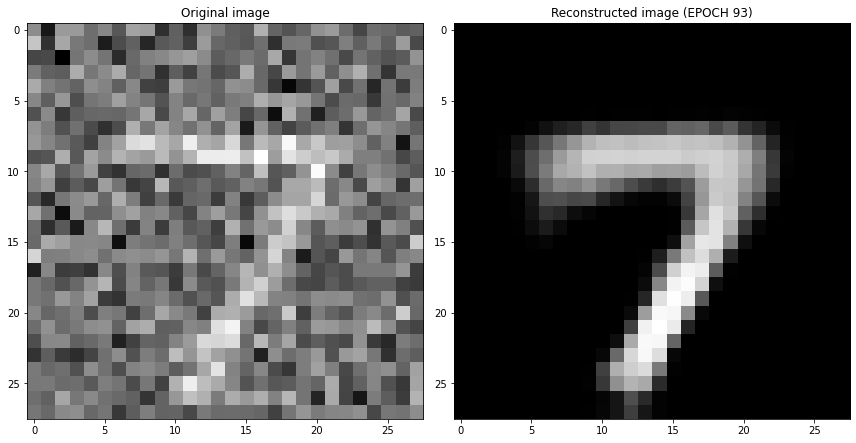

EPOCH 94/100
	 partial train loss (single batch): 0.204028
	 partial train loss (single batch): 0.202320
	 partial train loss (single batch): 0.204069
	 partial train loss (single batch): 0.202520
	 partial train loss (single batch): 0.200238
	 partial train loss (single batch): 0.204687
	 partial train loss (single batch): 0.201267
	 partial train loss (single batch): 0.203315
	 partial train loss (single batch): 0.202135
	 partial train loss (single batch): 0.202469
	 partial train loss (single batch): 0.201798
	 partial train loss (single batch): 0.202598
	 partial train loss (single batch): 0.199404
	 partial train loss (single batch): 0.202797
	 partial train loss (single batch): 0.203525
	 partial train loss (single batch): 0.201202
	 partial train loss (single batch): 0.201148
	 partial train loss (single batch): 0.204015
	 partial train loss (single batch): 0.201284
	 partial train loss (single batch): 0.201642
	 partial train loss (single batch): 0.203660
	 partial train loss 

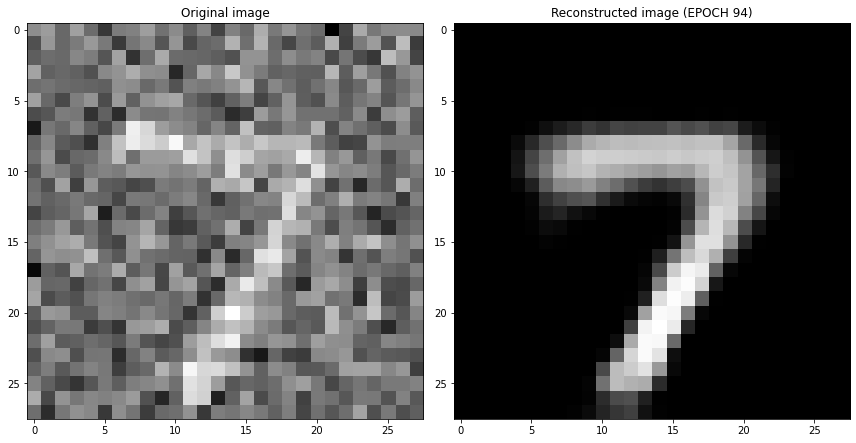

EPOCH 95/100
	 partial train loss (single batch): 0.203456
	 partial train loss (single batch): 0.200589
	 partial train loss (single batch): 0.201556
	 partial train loss (single batch): 0.204335
	 partial train loss (single batch): 0.200601
	 partial train loss (single batch): 0.200428
	 partial train loss (single batch): 0.201123
	 partial train loss (single batch): 0.201631
	 partial train loss (single batch): 0.201399
	 partial train loss (single batch): 0.203326
	 partial train loss (single batch): 0.202342
	 partial train loss (single batch): 0.203055
	 partial train loss (single batch): 0.201644
	 partial train loss (single batch): 0.203014
	 partial train loss (single batch): 0.202684
	 partial train loss (single batch): 0.202147
	 partial train loss (single batch): 0.202203
	 partial train loss (single batch): 0.202240
	 partial train loss (single batch): 0.202935
	 partial train loss (single batch): 0.203453
	 partial train loss (single batch): 0.202543
	 partial train loss 

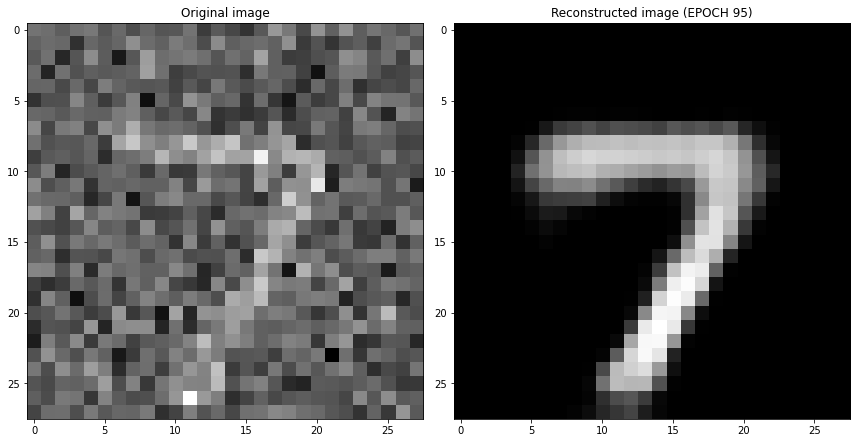

EPOCH 96/100
	 partial train loss (single batch): 0.201819
	 partial train loss (single batch): 0.202572
	 partial train loss (single batch): 0.202909
	 partial train loss (single batch): 0.200223
	 partial train loss (single batch): 0.201352
	 partial train loss (single batch): 0.200628
	 partial train loss (single batch): 0.201846
	 partial train loss (single batch): 0.201130
	 partial train loss (single batch): 0.202795
	 partial train loss (single batch): 0.203577
	 partial train loss (single batch): 0.200361
	 partial train loss (single batch): 0.201934
	 partial train loss (single batch): 0.201344
	 partial train loss (single batch): 0.203672
	 partial train loss (single batch): 0.202441
	 partial train loss (single batch): 0.203989
	 partial train loss (single batch): 0.202106
	 partial train loss (single batch): 0.203764
	 partial train loss (single batch): 0.201045
	 partial train loss (single batch): 0.201438
	 partial train loss (single batch): 0.202792
	 partial train loss 

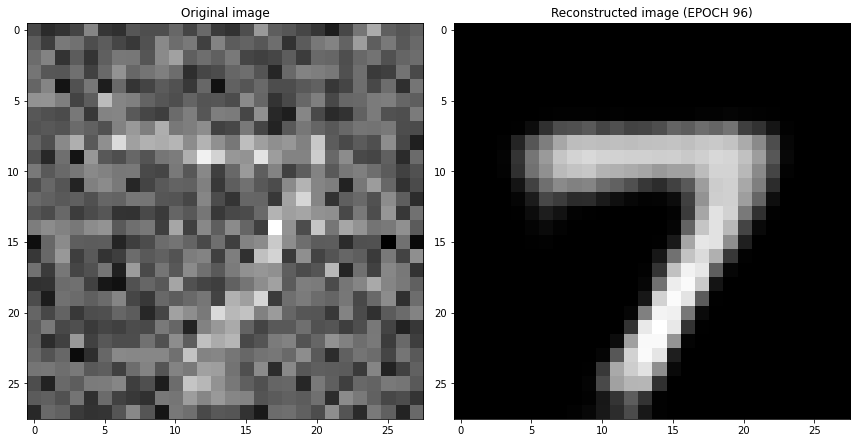

EPOCH 97/100
	 partial train loss (single batch): 0.201176
	 partial train loss (single batch): 0.200967
	 partial train loss (single batch): 0.201274
	 partial train loss (single batch): 0.203061
	 partial train loss (single batch): 0.201188
	 partial train loss (single batch): 0.199920
	 partial train loss (single batch): 0.200283
	 partial train loss (single batch): 0.201261
	 partial train loss (single batch): 0.200416
	 partial train loss (single batch): 0.200831
	 partial train loss (single batch): 0.201293
	 partial train loss (single batch): 0.203110
	 partial train loss (single batch): 0.202068
	 partial train loss (single batch): 0.200637
	 partial train loss (single batch): 0.202106
	 partial train loss (single batch): 0.201131
	 partial train loss (single batch): 0.201126
	 partial train loss (single batch): 0.201964
	 partial train loss (single batch): 0.202783
	 partial train loss (single batch): 0.201160
	 partial train loss (single batch): 0.201109
	 partial train loss 

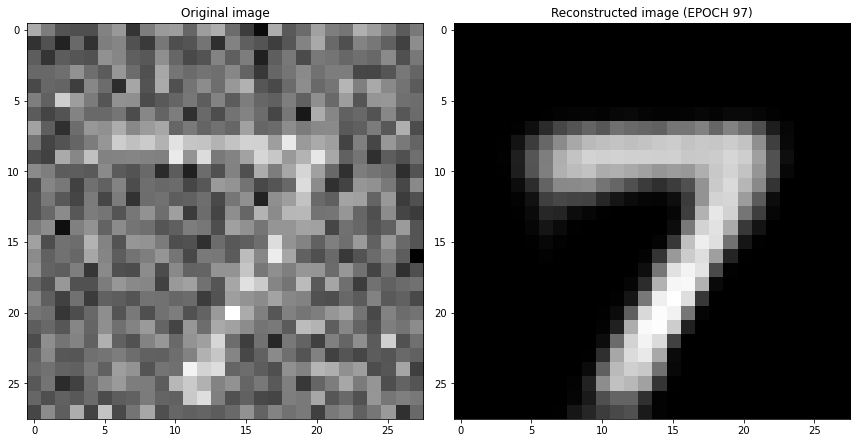

EPOCH 98/100
	 partial train loss (single batch): 0.201891
	 partial train loss (single batch): 0.202257
	 partial train loss (single batch): 0.199463
	 partial train loss (single batch): 0.202741
	 partial train loss (single batch): 0.203296
	 partial train loss (single batch): 0.204559
	 partial train loss (single batch): 0.197877
	 partial train loss (single batch): 0.201576
	 partial train loss (single batch): 0.202339
	 partial train loss (single batch): 0.202598
	 partial train loss (single batch): 0.201024
	 partial train loss (single batch): 0.201055
	 partial train loss (single batch): 0.202551
	 partial train loss (single batch): 0.203751
	 partial train loss (single batch): 0.201706
	 partial train loss (single batch): 0.201264
	 partial train loss (single batch): 0.201485
	 partial train loss (single batch): 0.203306
	 partial train loss (single batch): 0.201789
	 partial train loss (single batch): 0.203678
	 partial train loss (single batch): 0.201878
	 partial train loss 

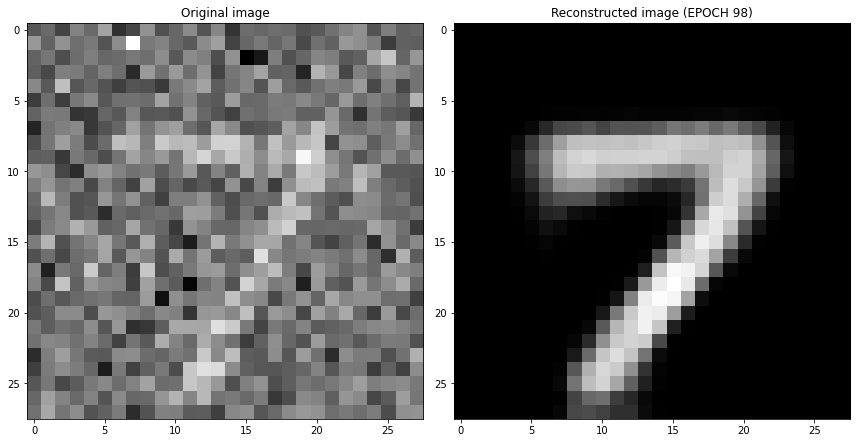

EPOCH 99/100
	 partial train loss (single batch): 0.201009
	 partial train loss (single batch): 0.202307
	 partial train loss (single batch): 0.201950
	 partial train loss (single batch): 0.203416
	 partial train loss (single batch): 0.202175
	 partial train loss (single batch): 0.202591
	 partial train loss (single batch): 0.199859
	 partial train loss (single batch): 0.203738
	 partial train loss (single batch): 0.200957
	 partial train loss (single batch): 0.202898
	 partial train loss (single batch): 0.201844
	 partial train loss (single batch): 0.203140
	 partial train loss (single batch): 0.201422
	 partial train loss (single batch): 0.203262
	 partial train loss (single batch): 0.201526
	 partial train loss (single batch): 0.200922
	 partial train loss (single batch): 0.201642
	 partial train loss (single batch): 0.203541
	 partial train loss (single batch): 0.200518
	 partial train loss (single batch): 0.203025
	 partial train loss (single batch): 0.203440
	 partial train loss 

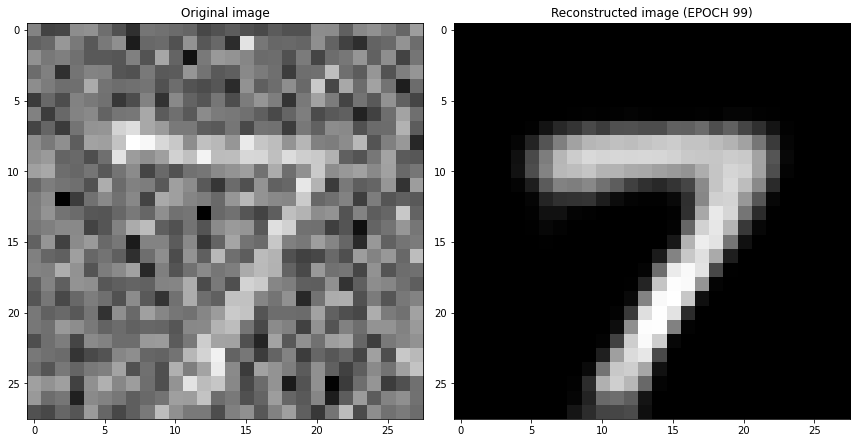

EPOCH 100/100
	 partial train loss (single batch): 0.204170
	 partial train loss (single batch): 0.202602
	 partial train loss (single batch): 0.201958
	 partial train loss (single batch): 0.203702
	 partial train loss (single batch): 0.203784
	 partial train loss (single batch): 0.202860
	 partial train loss (single batch): 0.199816
	 partial train loss (single batch): 0.202858
	 partial train loss (single batch): 0.201728
	 partial train loss (single batch): 0.201197
	 partial train loss (single batch): 0.201576
	 partial train loss (single batch): 0.201199
	 partial train loss (single batch): 0.204397
	 partial train loss (single batch): 0.203274
	 partial train loss (single batch): 0.202326
	 partial train loss (single batch): 0.202044
	 partial train loss (single batch): 0.202079
	 partial train loss (single batch): 0.202758
	 partial train loss (single batch): 0.202222
	 partial train loss (single batch): 0.202372
	 partial train loss (single batch): 0.203903
	 partial train loss

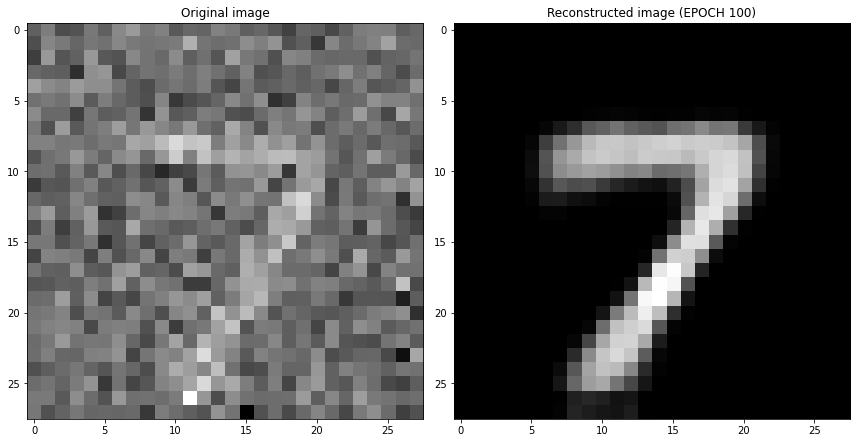

	Train Loss: 0.2 	Val Loss: 0.199


In [18]:
import gc
best_hyper=None
best_loss=None
for i,hyper in enumerate(iterations):
    print("\n\nIteration:",i,hyper)
    encoded_space_dim,conv1,conv2,conv3,fc,lr,l2, drop=hyper
    
    ### Initialize the two networks
    encoder = Encoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)
    decoder = Decoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)

    # Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=l2)

    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)
    
    
    #TRAINING CYCLE
    train_loss_log,val_loss_log=training_cycle(num_epochs,
                                           early_stopping,
                                           encoder,
                                           decoder,
                                           loss_fn,
                                           optim,
                                           train_dataloader,
                                           device, 
                                           test_dataset, 0.4)
    train_loss=train_loss_log[-1]
    val_loss=val_loss_log[-1]
    print("\tTrain Loss:",round(float(train_loss),3),"\tVal Loss:",round(float(val_loss),3))
    
    if not best_loss or val_loss<best_loss:
        best_loss=val_loss
        best_hyper=hyper


    gc.collect()
        


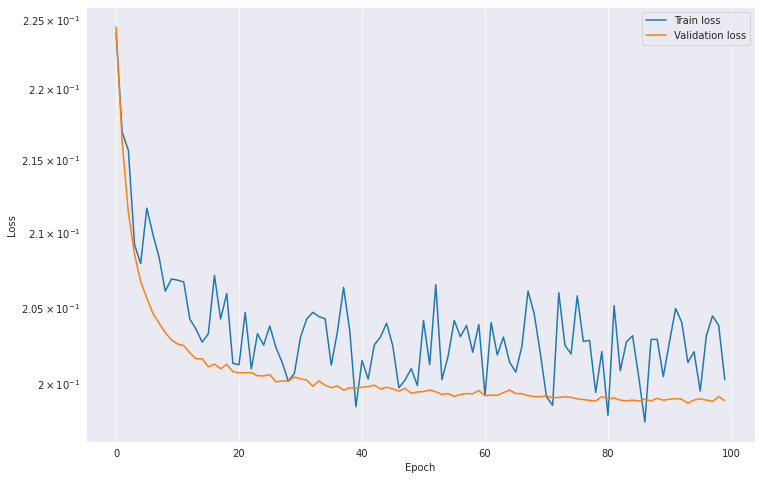

In [19]:
# Plot losses of the best model
import seaborn as sb 
sb.set_style( "darkgrid")
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [20]:
test_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn, noise_amount =0.4)

In [21]:
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]
print("Train Loss:\t",round(float(train_loss),3))
print("Val Loss:\t",round(float(val_loss),3))
print("Test Loss:\t",round(float(test_loss),3))

Train Loss:	 0.2
Val Loss:	 0.199
Test Loss:	 0.199


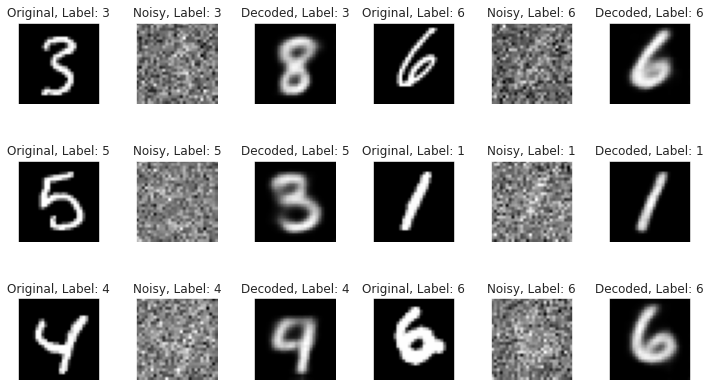

In [23]:
### Plot some sample
fig, axs = plt.subplots(3, 6, figsize=(10,6))
for ax in axs:
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(test_dataset)
    img1 = img[0]
    ax[0].imshow(np.array(img1), cmap='gist_gray')
    ax[0].set_title('Original, Label: %d' % label)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    img1 = img1 + np.random.normal(0, 1, size=img1.shape)
    ax[1].imshow(np.array(img1), cmap='gist_gray')
    ax[1].set_title('Noisy, Label: %d' % label)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    img = img.unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
        decoded_img  = decoder(encoded_img)
    ax[2].imshow(np.array(decoded_img.cpu()[0][0]), cmap='gist_gray')
    ax[2].set_title('Decoded, Label: %d' % label)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    img1 = img[0]
    ax[3].imshow(np.array(img1), cmap='gist_gray')
    ax[3].set_title('Original, Label: %d' % label)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
    img1 = img1 + np.random.normal(0, 1, size=img1.shape)
    ax[4].imshow(np.array(img1), cmap='gist_gray')
    ax[4].set_title('Noisy, Label: %d' % label)
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    
    img = img.unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
        decoded_img  = decoder(encoded_img)
    ax[5].imshow(np.array(decoded_img.cpu()[0][0]), cmap='gist_gray')
    ax[5].set_title('Decoded, Label: %d' % label)
    ax[5].set_xticks([])
    ax[5].set_yticks([])
    
    
    
plt.tight_layout()